In [6143]:
###### PARAM FOR LAST GOOD DATE BELOW TO BE SET ######
###### PARAM FOR LAST COMPLETE MONTH DOWNSTREAM TO BET MANUALLY SET! ####
###### PARAM for linreg start_year to be set #####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

sns.set()

#param
#linreg_start_year = 1861
linreg_start_year = 2010


In [6144]:
#### the pymc models are weird - most times the don't sample first time ####


In [6145]:
##### excess calculation example #####

df_foo = pd.DataFrame({'pop' : [1000,10000],'dead' : [10,100]},index=['Y1','Y2'])
excess_foo = df_foo.loc['Y2','dead'] - df_foo.loc['Y1','dead']
df_foo['mortality'] = df_foo['dead'] / df_foo['pop']
diff_mortality = df_foo.loc['Y2','mortality'] - df_foo.loc['Y1','mortality']
print (df_foo)
print ('abs_exess',excess_foo)
print ('diff mortality',diff_mortality)
print ('scaled excess', diff_mortality * df_foo.loc['Y2','pop'])


      pop  dead  mortality
Y1   1000    10       0.01
Y2  10000   100       0.01
abs_exess 90
diff mortality 0.0
scaled excess 0.0


In [6146]:
def parse_scb_prel(YTD=True):
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
    
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    
    df = df.replace(np.nan,0)

    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    #if YTD:
        #df = df.loc[df['2020'] != 0]
        
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    if YTD:
        index = pd.date_range('2020-01-01',periods=len(all_deaths))
    else:
        index = pd.date_range('2020-01-01','2020-12-31')
        
    
        
    all_deaths.index = index
    
    if YTD:
        all_deaths = all_deaths.loc[all_deaths['2020'] != 0]
    
    return all_deaths
    
    

In [6147]:
def parse_scb_prel_2021(YTD=True):
    
    df = pd.read_csv('scb-dead_per_day.csv',sep=';',thousands=',',header=0,usecols=[1,2,3,4,5,6,7,8,9])
    unknown_date = df.loc[366]
    df = df.loc[:365]
    
    daily_ratio = df / df.sum()
    
    df = df + daily_ratio * unknown_date
    df.index = pd.date_range('2020-01-01','2020-12-31')
    return df

In [6148]:
df = parse_scb_prel_2021()



In [6149]:
df.sum()

2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         97164.0
2021           552.0
2015-2019    91161.0
2016-2020    92364.0
dtype: float64

In [6150]:
df['2015-2018_avg'] = df.loc[:,'2015' : '2018'].mean(axis=1)

In [6151]:
#### PARAM ##### 
last_good_date = '2020-12-31'
df = df.loc[:last_good_date].copy()
df

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
2020-01-06  258.732276  251.424662  311.554100  275.510527  289.532745   
2020-01-07  312.297942  275.953897  320.777741  279.622625  288.502380   
2020-01-08  297.137848  298.439030  303.355307  267.286332  282.320186   
2020-01-09  274.903043  282.086206  295.156515  281.678673  246.257388   
2020-01-10  288.041791  261.645177  311.554100  295.042990  261.712873   
2020-01-11  285.009772  276.975949  330.001382  276.538552  277.168358   
2020-01-12  290.063137  306.615442  305.405005  290.930893  257.591410   
2020-01-13  264.796313  254.490817  318.728043  307.379282  261.712873   
2020-01-14  274.903043  265.733383  297.206213  276.538552  269.955798   
2020-01-15  302.191213  275.953897  316.678345  299.155087  292.623842   
2020-01-16  290.063137  280.042103  313.603798  303.267185  267.895067   
2020-01-17  267.828332  296.394927  311.554100  274.482503  269.955798   
2020-01-18  265.806986  281.064155  303.355307  275.510527  268.925432   
2020-01-19  277.935062  282.086206  304.380156  288.874844  257.591410   
2020-01-20  267.828332  314.791853  302.330458  280.650649  267.895067   
2020-01-21  286.020445  282.086206  287.982572  277.566576  262.743239   
2020-01-22  311.287269  260.623125  287.982572  286.818795  274.077261   
2020-01-23  280.967081  274.931846  295.156515  277.566576  254.500313   
2020-01-24  261.764295  305.593390  259.286800  287.846820  282.320186   
2020-01-25  280.967081  322.968265  311.554100  296.071014  270.986164   
2020-01-26  263.785640  283.108258  263.386196  265.230284  298.806036   
2020-01-27  271.871024  292.306721  282.858327  285.790771  240.075194   
2020-01-28  278.945735  281.064155  269.535290  282.706698  241.105560   
2020-01-29  295.116502  315.813905  275.684384  281.678673  260.682507   
2020-01-30  303.201886  272.887743  262.361347  249.809918  278.198723   
2020-01-31  291.073810  282.086206  271.584988  255.978065  252.439582   
2020-02-01  292.084483  255.512868  300.280760  277.566576  284.380917   
2020-02-02  281.977754  267.777486  300.280760  267.286332  251.409216   
2020-02-03  266.817659  306.615442  287.982572  277.566576  298.806036   
2020-02-04  256.710930  272.887743  262.361347  296.071014  301.897133   
2020-02-05  257.721603  266.755434  244.938914  299.155087  293.654208   
2020-02-06  271.871024  271.865692  253.137706  296.071014  257.591410   
2020-02-07  287.031118  309.681596  264.411045  305.323234  246.257388   
2020-02-08  265.806986  265.733383  305.405005  269.342381  273.046895   
2020-02-09  283.999099  287.196464  284.908025  267.286332  276.137992   
2020-02-10  280.967081  251.424662  295.156515  300.183112  290.563111   
2020-02-11  291.073810  302.527236  230.591028  301.211136  265.834335   
2020-02-12  329.479382  262.667228  294.131666  280.650649  276.137992   
2020-02-13  269.849678  263.689280  284.908025  318.687550  280.259454   
2020-02-14  268.839005  244.270302  286.957723  301.211136  270.986164   
2020-02-15  298.148521  262.667228  276.709233  303.267185  228.741172   
2020-02-16  299.159194  254.490817  294.131666  317.659526  260.682507   
2020-02-17  299.159194  285.152361  312.578949  286.818795  234.923366   
2020-02-18  307.244577  249.380559  304.380156  272.426454  255.530679   
2020-02-19  293.095156  273.909795  300.280760  309.435331  301.897133   
2020-02-20  340.596785  285.152361  299.255911  299.155087  268.925432   
2020-02-21  291.073810  267.777486  317.703194  340.276062  273.046895   
2020-02-22  299.159194  260.623125  301.305609  311.491380  281.289820   
2020-02-23  296.127175

In [6152]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2021               552.0
2015-2019        91161.0
2016-2020        92364.0
2015-2018_avg    91511.5
dtype: float64

In [6153]:
df['excess'] = df['2020'] - df['2015-2018_avg']
df.drop(['2021','2016-2020','2015-2019'],axis=1,inplace=True)
df

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
2020-01-06  258.732276  251.424662  311.554100  275.510527  289.532745   
2020-01-07  312.297942  275.953897  320.777741  279.622625  288.502380   
2020-01-08  297.137848  298.439030  303.355307  267.286332  282.320186   
2020-01-09  274.903043  282.086206  295.156515  281.678673  246.257388   
2020-01-10  288.041791  261.645177  311.554100  295.042990  261.712873   
2020-01-11  285.009772  276.975949  330.001382  276.538552  277.168358   
2020-01-12  290.063137  306.615442  305.405005  290.930893  257.591410   
2020-01-13  264.796313  254.490817  318.728043  307.379282  261.712873   
2020-01-14  274.903043  265.733383  297.206213  276.538552  269.955798   
2020-01-15  302.191213  275.953897  316.678345  299.155087  292.623842   
2020-01-16  290.063137  280.042103  313.603798  303.267185  267.895067   
2020-01-17  267.828332  296.394927  311.554100  274.482503  269.955798   
2020-01-18  265.806986  281.064155  303.355307  275.510527  268.925432   
2020-01-19  277.935062  282.086206  304.380156  288.874844  257.591410   
2020-01-20  267.828332  314.791853  302.330458  280.650649  267.895067   
2020-01-21  286.020445  282.086206  287.982572  277.566576  262.743239   
2020-01-22  311.287269  260.623125  287.982572  286.818795  274.077261   
2020-01-23  280.967081  274.931846  295.156515  277.566576  254.500313   
2020-01-24  261.764295  305.593390  259.286800  287.846820  282.320186   
2020-01-25  280.967081  322.968265  311.554100  296.071014  270.986164   
2020-01-26  263.785640  283.108258  263.386196  265.230284  298.806036   
2020-01-27  271.871024  292.306721  282.858327  285.790771  240.075194   
2020-01-28  278.945735  281.064155  269.535290  282.706698  241.105560   
2020-01-29  295.116502  315.813905  275.684384  281.678673  260.682507   
2020-01-30  303.201886  272.887743  262.361347  249.809918  278.198723   
2020-01-31  291.073810  282.086206  271.584988  255.978065  252.439582   
2020-02-01  292.084483  255.512868  300.280760  277.566576  284.380917   
2020-02-02  281.977754  267.777486  300.280760  267.286332  251.409216   
2020-02-03  266.817659  306.615442  287.982572  277.566576  298.806036   
2020-02-04  256.710930  272.887743  262.361347  296.071014  301.897133   
2020-02-05  257.721603  266.755434  244.938914  299.155087  293.654208   
2020-02-06  271.871024  271.865692  253.137706  296.071014  257.591410   
2020-02-07  287.031118  309.681596  264.411045  305.323234  246.257388   
2020-02-08  265.806986  265.733383  305.405005  269.342381  273.046895   
2020-02-09  283.999099  287.196464  284.908025  267.286332  276.137992   
2020-02-10  280.967081  251.424662  295.156515  300.183112  290.563111   
2020-02-11  291.073810  302.527236  230.591028  301.211136  265.834335   
2020-02-12  329.479382  262.667228  294.131666  280.650649  276.137992   
2020-02-13  269.849678  263.689280  284.908025  318.687550  280.259454   
2020-02-14  268.839005  244.270302  286.957723  301.211136  270.986164   
2020-02-15  298.148521  262.667228  276.709233  303.267185  228.741172   
2020-02-16  299.159194  254.490817  294.131666  317.659526  260.682507   
2020-02-17  299.159194  285.152361  312.578949  286.818795  234.923366   
2020-02-18  307.244577  249.380559  304.380156  272.426454  255.530679   
2020-02-19  293.095156  273.909795  300.280760  309.435331  301.897133   
2020-02-20  340.596785  285.152361  299.255911  299.155087  268.925432   
2020-02-21  291.073810  267.777486  317.703194  340.276062  273.046895   
2020-02-22  299.159194  260.623125  301.305609  311.491380  281.289820   
2020-02-23  296.127175

In [6154]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [6155]:
pop = pd.read_pickle('pop_2015_2020.pkl')
pop.loc['excess'] = pop.loc['2020']
pop.loc['2015-2018_avg'] = pop.loc['2015' : '2018'].mean()

### setting the baseline pop to 2020 yields correct erroneous excess !!! #
#pop.loc['2015-2018_avg'] = pop.loc['2020']
###

pop

year
2015              9747355.00
2016              9851017.00
2017              9995153.00
2018             10120242.00
2019             10230185.00
2020             10327589.00
excess           10327589.00
2015-2018_avg     9928441.75
Name: population, dtype: float64

In [6156]:
## for excess to be correct, the diff must be obtained from dividing the abs diff with the pop ! ##
df_per_m = df / (pop / 1e6 )

# taking the diff after having made fractions yields wrong result! b/c populations are different!

# that is: df_per_m['excess'] which gives correct result is divided by population 2020, 
# while df_per_m['wrong_excess'] is calculated by diff 2020 - baseline, where the deaths are 
# already divided by population 2015-2018_avg, a smaller population which results in larger abs numbers. 

### BOTTOM LINE : dont add/subtract fractions where the denominator is different! ###

df_per_m['wrong_excess'] = df_per_m['2020'] - df_per_m['2015-2018_avg']

df_per_m

2015  2015-2018_avg       2016       2017       2018  \
2020-01-01  30.587633      29.679422  25.418960  34.759229  27.934776   
2020-01-02  28.202835      30.179000  28.220234  32.503468  31.693274   
2020-01-03  29.136017      30.327784  30.399002  31.785726  29.966397   
2020-01-04  26.543845      28.454403  26.975223  31.273053  28.950586   
2020-01-05  27.788087      28.889300  26.975223  31.170518  29.560073   
2020-01-06  26.543845      27.628242  25.522711  31.170518  27.223709   
2020-01-07  32.039250      29.930482  28.012732  32.093330  27.630033   
2020-01-08  30.483946      29.365598  30.295251  30.350242  26.411061   
2020-01-09  28.202835      28.549909  28.635237  29.529965  27.833195   
2020-01-10  29.550764      29.115446  26.560220  31.170518  29.153748   
2020-01-11  29.239704      29.423692  28.116483  33.016141  27.325290   
2020-01-12  29.758138      30.040325  31.125258  30.555311  28.747424   
2020-01-13  27.165966      28.841244  25.833964  31.888261  30.372721   
2020-01-14  28.202835      28.060325  26.975223  29.735034  27.325290   
2020-01-15  31.002381      30.064601  28.012732  31.683191  29.560073   
2020-01-16  29.758138      29.888281  28.427735  31.375588  29.966397   
2020-01-17  27.477027      28.963756  30.087749  31.170518  27.122128   
2020-01-18  27.269653      28.346265  28.531486  30.350242  27.223709   
2020-01-19  28.513895      29.039710  28.635237  30.452776  28.544262   
2020-01-20  27.477027      29.350056  31.955264  30.247707  27.731614   
2020-01-21  29.343391      28.545663  28.635237  28.812223  27.426871   
2020-01-22  31.935563      28.874414  26.456469  28.812223  28.341100   
2020-01-23  28.824956      28.418911  27.908981  29.529965  27.426871   
2020-01-24  26.854905      28.063097  31.021507  25.941254  28.442681   
2020-01-25  28.824956      30.507317  32.785271  31.170518  29.255330   
2020-01-26  27.062279      27.081550  28.738988  26.351392  26.207899   
2020-01-27  27.891774      28.524789  29.672746  28.299550  28.239519   
2020-01-28  28.617582      28.006708  28.531486  26.966600  27.934776   
2020-01-29  30.276573      29.417846  32.059015  27.581807  27.833195   
2020-01-30  31.106068      27.402611  27.701479  26.248858  24.684184   
2020-01-31  29.861825      27.716411  28.635237  27.171669  25.293670   
2020-02-01  29.965512      28.338905  25.937715  30.042638  27.426871   
2020-02-02  28.928643      28.134383  27.182725  30.042638  26.411061   
2020-02-03  27.373340      28.679784  31.125258  28.812223  27.426871   
2020-02-04  26.336471      27.396823  27.701479  26.248858  29.255330   
2020-02-05  26.440158      26.906816  27.078974  24.505769  29.560073   
2020-02-06  27.891774      27.520568  27.597728  25.326046  29.255330   
2020-02-07  29.447078      29.371351  31.436510  26.453927  30.169559   
2020-02-08  27.269653      27.856530  26.975223  30.555311  26.614223   
2020-02-09  29.136017      28.287166  29.153991  28.504619  26.411061   
2020-02-10  28.824956      28.396485  25.522711  29.529965  29.661654   
2020-02-11  29.861825      28.337861  30.710254  23.070285  29.763235   
2020-02-12  33.801927      29.383486  26.663971  29.427430  27.731614   
2020-02-13  27.684400      28.633258  26.767722  28.504619  31.490112   
2020-02-14  27.580713      27.730388  24.796455  28.709688  29.763235   
2020-02-15  30.587633      28.725358  26.663971  27.684342  29.966397   
2020-02-16  30.691320      29.346025  25.833964  29.427430  31.388531   
2020-02-17  30.691320      29.806019  28.946490  31.273053  28.341100   
2020-02-18  31.520815      28.540021  25.315210  30.452776  26.918966   
2020-02-19  30.069199      29.630054  27.805230  30.042638  30.575883   
2020-02-20  34.942483      30.824579  28.946490  29.940103  29.560073   
2020-02-21  29.861825      30.640018  27.182725  31.785726  33.623313   
2020-02-22  30.691320      29.525764  26.456469  30.145172  30.779045   
2020-02-23  30.380260      30.894629  28.220234  32.503468  32.404341   
20

In [6157]:
# if you subtract fractions youll get wrong result! #
per_m_diff = df_per_m['2020'] - df_per_m['2015-2018_avg']
per_m_diff.sum()

191.0917919109186

In [6158]:
df_per_m.sum()

2015             9326.324936
2015-2018_avg    9217.105998
2016             9235.797685
2017             9201.660045
2018             9108.971900
2019             8676.871435
2020             9408.197789
excess            547.320386
wrong_excess      191.091792
dtype: float64

<AxesSubplot:>

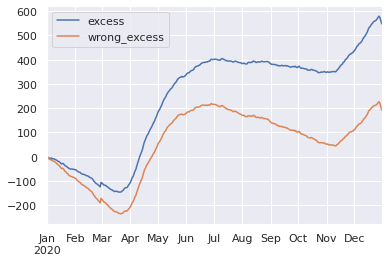

In [6159]:
df_per_m.cumsum().plot(y=['excess','wrong_excess'])

<AxesSubplot:>

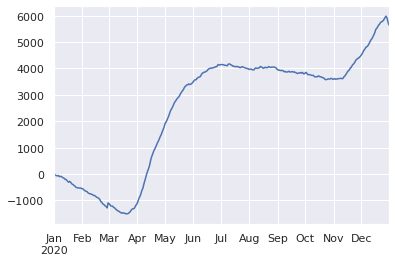

In [6160]:
df['excess'].cumsum().plot()

In [6161]:
df.sum() / pop

2015             0.009326
2015-2018_avg    0.009217
2016             0.009236
2017             0.009202
2018             0.009109
2019             0.008677
2020             0.009408
excess           0.000547
dtype: float64

In [6162]:
(df['excess'] / (pop.loc['2020'] / 1e6)).cumsum()

2020-01-01     -3.266366
2020-01-02     -2.238329
2020-01-03     -5.929054
2020-01-04     -6.028300
2020-01-05     -7.440885
2020-01-06     -5.651703
2020-01-07     -9.955206
2020-01-08     -9.239399
2020-01-09     -9.132042
2020-01-10    -11.955703
2020-01-11    -14.080971
2020-01-12    -15.704845
2020-01-13    -19.458569
2020-01-14    -19.875273
2020-01-15    -23.511932
2020-01-16    -26.979085
2020-01-17    -30.552169
2020-01-18    -27.662757
2020-01-19    -29.219939
2020-01-20    -34.457534
2020-01-21    -37.927101
2020-01-22    -39.225904
2020-01-23    -43.070979
2020-01-24    -45.081907
2020-01-25    -49.144171
2020-01-26    -50.012543
2020-01-27    -51.572067
2020-01-28    -51.041976
2020-01-29    -52.067428
2020-01-30    -51.652893
2020-01-31    -53.728422
2020-02-01    -53.517689
2020-02-02    -56.193982
2020-02-03    -59.792486
2020-02-04    -62.058141
2020-02-05    -63.852728
2020-02-06    -64.645788
2020-02-07    -68.809659
2020-02-08    -71.218838
2020-02-09    -72.748867


In [6163]:
df.sum().loc['2020'] - df.sum().loc['2015-2018_avg']

5652.499999999913

In [6164]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [6165]:
pop_diff = pop.loc['2020'] - pop.loc['2015-2018_avg']
pop_diff

399147.25

In [6166]:
dead_diff = df.sum().loc['2020'] - df.sum().loc['2015-2018_avg']
dead_diff

5652.499999999913

In [6167]:
dead_diff / (pop.loc['2020'] / 1e6)

547.3203862004881

In [6168]:
df_per_m.sum()

2015             9326.324936
2015-2018_avg    9217.105998
2016             9235.797685
2017             9201.660045
2018             9108.971900
2019             8676.871435
2020             9408.197789
excess            547.320386
wrong_excess      191.091792
dtype: float64

In [6169]:
dead_per_m_2020 = df_per_m.sum().loc['2020']
dead_per_m_15_18 = df_per_m.sum().loc['2015-2018_avg']

print (dead_per_m_15_18)
print (dead_per_m_2020)

9217.105997524744
9408.19778943565


In [6170]:
# diff in cum mortality expressed in millions
dead_per_m_2020 - dead_per_m_15_18

191.09179191090516

In [6171]:
# diff in mortality
mort_diff = ((df.sum() / pop).loc['2020'] - (df.sum() / pop).loc['2015-2018_avg']) 
mort_diff

0.00019109179191091098

In [6172]:
mortality = df_per_m.sum() / 1e6
mortality


2015             0.009326
2015-2018_avg    0.009217
2016             0.009236
2017             0.009202
2018             0.009109
2019             0.008677
2020             0.009408
excess           0.000547
wrong_excess     0.000191
dtype: float64

In [6173]:
dead_2020 = mortality.loc['2020'] * pop.loc['2020']
dead_15_18 = mortality.loc['2015-2018_avg'] * pop.loc['2015-2018_avg']

print (dead_2020)
print (dead_15_18)

print (dead_2020 - dead_15_18)

97163.99999999993
91511.50000000007
5652.4999999998545


In [6174]:
pop

year
2015              9747355.00
2016              9851017.00
2017              9995153.00
2018             10120242.00
2019             10230185.00
2020             10327589.00
excess           10327589.00
2015-2018_avg     9928441.75
Name: population, dtype: float64

In [6175]:
abs_totals = df.sum()
abs_totals

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [6176]:
mortality = abs_totals / pop
mortality

2015             0.009326
2015-2018_avg    0.009217
2016             0.009236
2017             0.009202
2018             0.009109
2019             0.008677
2020             0.009408
excess           0.000547
dtype: float64

In [6177]:
mortality.loc['excess']

0.0005473203862004964

In [6178]:
mort_diff * pop.loc['2020']

1973.5174881294133

In [6179]:
calc_deaths = mortality * pop
calc_deaths

2015             90907.0
2015-2018_avg    91511.5
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
excess            5652.5
dtype: float64

In [6180]:
calc_diff = calc_deaths.loc['2020'] - calc_deaths.loc['2015-2018_avg']
calc_diff

5652.499999999913

In [6181]:
mortality

2015             0.009326
2015-2018_avg    0.009217
2016             0.009236
2017             0.009202
2018             0.009109
2019             0.008677
2020             0.009408
excess           0.000547
dtype: float64

In [6182]:
pop_adj_deaths = mortality * pop.loc['2020']

pop_adj_deaths.index = pd.Categorical(pop_adj_deaths.index,
                                      ['2015','2016','2017','2018','2019','2015-2018_avg','2020','excess'])

pop_adj_deaths.sort_index(inplace=True)
pop_adj_deaths

2015             96318.450823
2016             95383.522574
2017             95030.963059
2018             94073.717997
2019             89611.161985
2015-2018_avg    95190.482512
2020             97164.000000
excess            5652.500000
dtype: float64

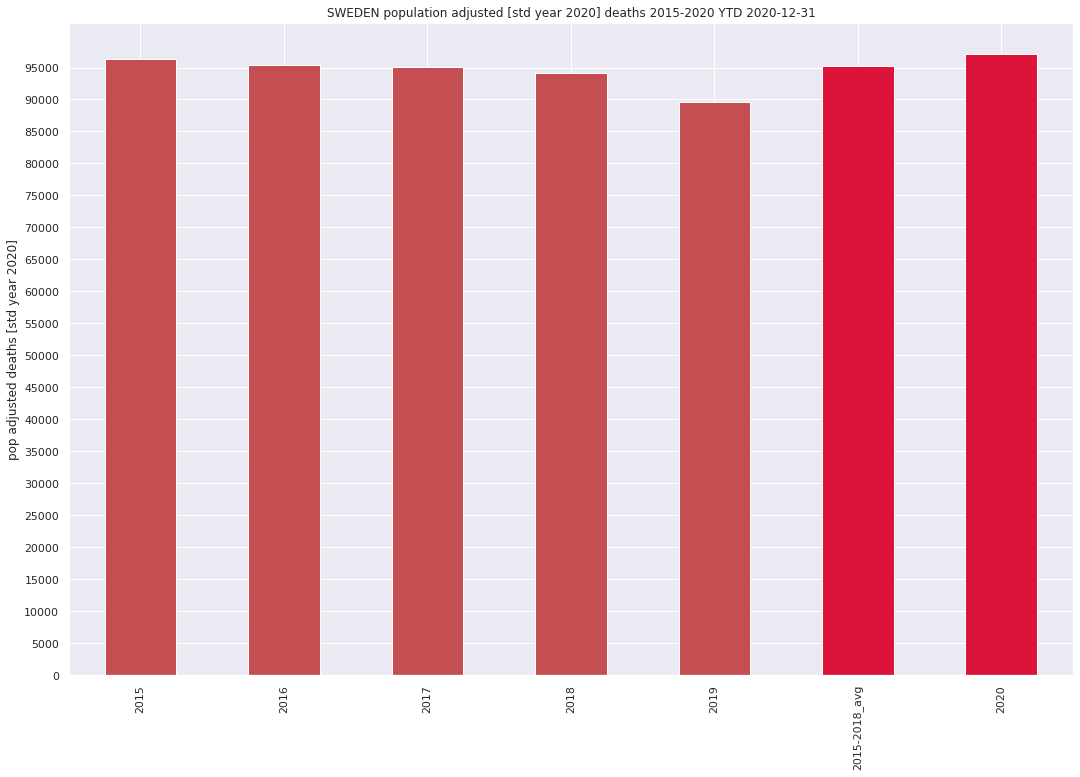

In [6183]:
colors = ['r'] * 5
colors.extend(['crimson','crimson'])


title = 'SWEDEN population adjusted [std year 2020] deaths 2015-2020 YTD {}'.format(df_per_m.index[-1].date())
pop_adj_deaths[:-1].plot(kind='bar',figsize=(18,12),title=title,color=colors)
_= plt.yticks(np.arange(0,100000,5000))
plt.ylabel('pop adjusted deaths [std year 2020]')
plt.savefig('swe_pop_adj_deaths_ytd_15_20.jpg',format='jpg')


In [6184]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [6185]:
from pandas.tseries.offsets import MonthEnd
month_ends = df_per_m.index + MonthEnd(0)
month_ends

DatetimeIndex(['2020-01-31', '2020-01-31', '2020-01-31', '2020-01-31',
               '2020-01-31', '2020-01-31', '2020-01-31', '2020-01-31',
               '2020-01-31', '2020-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

In [6186]:
#### historical monthly deaths

url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/ManadFoddDod'

data = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Manad",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12",
          "90"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000000NF"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [6187]:
r = requests.post(url,json=data)

In [6188]:
r.status_code

200

In [6189]:
json = r.json()
json['data'][0]

{'key': ['1', '01', '1851'], 'values': ['3245']}

In [6190]:
data_list = []

nr_records = (len(json['data']))

for rec in range(nr_records):

    data_list.append ((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['key'][2],
                        json['data'][rec]['values'][0]))



In [6191]:
hist_deaths = pd.DataFrame(data_list,columns=['gender','month','year','deaths'])
hist_deaths['deaths'] = hist_deaths['deaths'].astype(int)
hist_deaths.head()

gender month  year  deaths
0      1    01  1851    3245
1      1    01  1852    3403
2      1    01  1853    3559
3      1    01  1854    2980
4      1    01  1855    3244

In [6192]:
hist_deaths = hist_deaths.groupby(['year','month']).sum()
hist_deaths

deaths
year month        
1851 01       6261
     02       6007
     03       8812
     04       7818
     05       7406
...            ...
2019 09       6855
     10       7536
     11       7438
     12       7896
     90        262

[2197 rows x 1 columns]

In [6193]:
yearly_sums = hist_deaths.groupby('year').sum()
yearly_sums

deaths
year        
1851   72506
1852   80090
1853   84047
1854   70846
1855   77734
1856   79618
1857  101491
1858   80498
1859   75720
1860   67502
1861   71829
1862   84350
1863   77227
1864   81937
1865   79216
1866   82666
1867   82072
1868   87807
1869   92775
1870   82449
1871   72046
1872   68802
1873   73525
1874   87760
1875   88439
1876   86334
1877   83175
1878   81418
1879   77152
1880   82753
1881   80800
1882   79406
1883   79487
1884   81077
1885   82781
1886   78045
1887   76227
1888   75831
1889   76124
1890   81824
1891   80603
1892   85894
1893   81027
1894   79444
1895   74368
1896   77259
1897   76558
1898   75949
1899   89678
1900   86146
1901   82772
1902   79722
1903   78610
1904   80152
1905   82443
1906   76366
1907   78149
1908   80568
1909   74538
1910   77212
1911   76462
1912   79241
1913   76724
1914   78311
1915   83587
1916   77771
1917   77385
1918  104591
1919   84289
1920   78128
1921   73536
1922   76343
1923   68424
1924   72001
1925   70918
1926   71344
1927   77219
1928   73267
1929   74538
1930   71790
1931   77121
1932   71459
1933   69607
1934   69921
1935   72813
1936   74836
1937   75392
1938   72693
1939   72876
1940   72748
1941   71910
1942   63741
1943   66105
1944   72284
1945   71901
1946   70635
1947   73579
1948   67693
1949   69537
1950   70296
1951   69799
1952   68270
1953   69553
1954   69030
1955   68634
1956   70205
1957   73132
1958   71065
1959   70889
1960   75093
1961   73555
1962   76791
1963   76460
1964   76661
1965   78194
1966   78440
1967   79783
1968   82476
1969   83352
1970   80026
1971   82717
1972   84056
1973   85640
1974   86316
1975   88208
1976   90677
1977   88202
1978   89681
1979   91074
1980   91800
1981   92034
1982   90671
1983   90791
1984   90483
1985   94032
1986   93295
1987   93307
1988   96743
1989   92110
1990   95161
1991   95202
1992   94710
1993   97008
1994   91844
1995   93955
1996   94133
1997   93326
1998   93271
1999   94726
2000   93461
2001   93752
2002   95009
2003   92961
2004   90532
2005   91710
2006   91177
2007   91729
2008   91449
2009   90080
2010   90487
2011   89938
2012   91938
2013   90402
2014   88976
2015   90907
2016   90982
2017   91972
2018   92185
2019   88766

In [6194]:
unknown_month_mask = hist_deaths.index.get_level_values('month') == '90'
unknown_month_mask

array([False, False, False, ..., False, False,  True])

In [6195]:
unknown_death_months = hist_deaths.loc[unknown_month_mask]['deaths']
unknown_death_months = unknown_death_months.reset_index().set_index('year')
unknown_death_months

month  deaths
year              
1851    90       0
1852    90       0
1853    90       0
1854    90       0
1855    90       0
1856    90       0
1857    90       0
1858    90       0
1859    90       0
1860    90       0
1861    90       0
1862    90       0
1863    90       0
1864    90       0
1865    90     272
1866    90       0
1867    90       0
1868    90      15
1869    90       0
1870    90       0
1871    90       0
1872    90       0
1873    90       0
1874    90       0
1875    90       0
1876    90       0
1877    90       0
1878    90       0
1879    90       0
1880    90       0
1881    90       0
1882    90       0
1883    90       0
1884    90       0
1885    90       0
1886    90       0
1887    90       0
1888    90       0
1889    90       0
1890    90       0
1891    90       0
1892    90       0
1893    90       0
1894    90       0
1895    90       0
1896    90       0
1897    90       0
1898    90       0
1899    90       0
1900    90       0
1901    90       0
1902    90       0
1903    90       0
1904    90       0
1905    90       0
1906    90       0
1907    90       0
1908    90       0
1909    90       0
1910    90       0
1911    90       0
1912    90       0
1913    90       0
1914    90       0
1915    90       0
1916    90       0
1917    90       0
1918    90       0
1919    90       0
1920    90       0
1921    90       0
1922    90       0
1923    90       0
1924    90       0
1925    90       0
1926    90       0
1927    90       0
1928    90       0
1929    90       0
1930    90       0
1931    90       0
1932    90       0
1933    90       0
1934    90       0
1935    90       0
1936    90       0
1937    90       0
1938    90       0
1939    90       0
1940    90       0
1941    90       0
1942    90       0
1943    90       0
1944    90       0
1945    90       0
1946    90       0
1947    90       0
1948    90       0
1949    90       0
1950    90       0
1951    90       0
1952    90       0
1953    90       0
1954    90       0
1955    90       0
1956    90       0
1957    90       0
1958    90       0
1959    90       0
1960    90       0
1961    90       0
1962    90       0
1963    90       0
1964    90       0
1965    90       0
1966    90       0
1967    90       0
1968    90     102
1969    90      14
1970    90      11
1971    90       4
1972    90       0
1973    90       1
1974    90       2
1975    90      10
1976    90      40
1977    90      52
1978    90      41
1979    90      58
1980    90      60
1981    90      79
1982    90      71
1983    90      72
1984    90      88
1985    90      85
1986    90      97
1987    90     152
1988    90     151
1989    90     152
1990    90     196
1991    90     208
1992    90     247
1993    90     294
1994    90     323
1995    90     375
1996    90     360
1997    90     429
1998    90     360
1999    90     378
2000    90     383
2001    90     419
2002    90     401
2003    90     415
2004    90     346
2005    90     206
2006    90     159
2007    90     138
2008    90     112
2009    90     120
2010    90      45
2011    90      52
2012    90      22
2013    90      20
2014    90      22
2015    90      91
2016    90     186
2017    90     197
2018    90     248
2019    90     262

In [6196]:
hist_deaths = (hist_deaths.loc[~unknown_month_mask]).copy()
hist_deaths

deaths
year month        
1851 01       6261
     02       6007
     03       8812
     04       7818
     05       7406
...            ...
2019 08       7031
     09       6855
     10       7536
     11       7438
     12       7896

[2028 rows x 1 columns]

In [6197]:
# wow! 
hist_deaths['ratio_of_year'] = hist_deaths / hist_deaths.groupby('year').sum()
hist_deaths

deaths  ratio_of_year
year month                       
1851 01       6261       0.086351
     02       6007       0.082848
     03       8812       0.121535
     04       7818       0.107826
     05       7406       0.102143
...            ...            ...
2019 08       7031       0.079443
     09       6855       0.077454
     10       7536       0.085149
     11       7438       0.084041
     12       7896       0.089216

[2028 rows x 2 columns]

In [6198]:
hist_deaths.groupby('year').sum()

deaths  ratio_of_year
year                       
1851   72506            1.0
1852   80090            1.0
1853   84047            1.0
1854   70846            1.0
1855   77734            1.0
1856   79618            1.0
1857  101491            1.0
1858   80498            1.0
1859   75720            1.0
1860   67502            1.0
1861   71829            1.0
1862   84350            1.0
1863   77227            1.0
1864   81937            1.0
1865   78944            1.0
1866   82666            1.0
1867   82072            1.0
1868   87792            1.0
1869   92775            1.0
1870   82449            1.0
1871   72046            1.0
1872   68802            1.0
1873   73525            1.0
1874   87760            1.0
1875   88439            1.0
1876   86334            1.0
1877   83175            1.0
1878   81418            1.0
1879   77152            1.0
1880   82753            1.0
1881   80800            1.0
1882   79406            1.0
1883   79487            1.0
1884   81077            1.0
1885   82781            1.0
1886   78045            1.0
1887   76227            1.0
1888   75831            1.0
1889   76124            1.0
1890   81824            1.0
1891   80603            1.0
1892   85894            1.0
1893   81027            1.0
1894   79444            1.0
1895   74368            1.0
1896   77259            1.0
1897   76558            1.0
1898   75949            1.0
1899   89678            1.0
1900   86146            1.0
1901   82772            1.0
1902   79722            1.0
1903   78610            1.0
1904   80152            1.0
1905   82443            1.0
1906   76366            1.0
1907   78149            1.0
1908   80568            1.0
1909   74538            1.0
1910   77212            1.0
1911   76462            1.0
1912   79241            1.0
1913   76724            1.0
1914   78311            1.0
1915   83587            1.0
1916   77771            1.0
1917   77385            1.0
1918  104591            1.0
1919   84289            1.0
1920   78128            1.0
1921   73536            1.0
1922   76343            1.0
1923   68424            1.0
1924   72001            1.0
1925   70918            1.0
1926   71344            1.0
1927   77219            1.0
1928   73267            1.0
1929   74538            1.0
1930   71790            1.0
1931   77121            1.0
1932   71459            1.0
1933   69607            1.0
1934   69921            1.0
1935   72813            1.0
1936   74836            1.0
1937   75392            1.0
1938   72693            1.0
1939   72876            1.0
1940   72748            1.0
1941   71910            1.0
1942   63741            1.0
1943   66105            1.0
1944   72284            1.0
1945   71901            1.0
1946   70635            1.0
1947   73579            1.0
1948   67693            1.0
1949   69537            1.0
1950   70296            1.0
1951   69799            1.0
1952   68270            1.0
1953   69553            1.0
1954   69030            1.0
1955   68634            1.0
1956   70205            1.0
1957   73132            1.0
1958   71065            1.0
1959   70889            1.0
1960   75093            1.0
1961   73555            1.0
1962   76791            1.0
1963   76460            1.0
1964   76661            1.0
1965   78194            1.0
1966   78440            1.0
1967   79783            1.0
1968   82374            1.0
1969   83338            1.0
1970   80015            1.0
1971   82713            1.0
1972   84056            1.0
1973   85639            1.0
1974   86314            1.0
1975   88198            1.0
1976   90637            1.0
1977   88150            1.0
1978   89640            1.0
1979   91016            1.0
1980   91740            1.0
1981   91955            1.0
1982   90600            1.0
1983   90719            1.0
1984   90395            1.0
1985   93947            1.0
1986   93198            1.0
1987   93155            1.0
1988   96592            1.0
1989   91958            1.0
1990   94965            1.0
1991   94994            1.0
19

In [6199]:
hist_deaths


deaths  ratio_of_year
year month                       
1851 01       6261       0.086351
     02       6007       0.082848
     03       8812       0.121535
     04       7818       0.107826
     05       7406       0.102143
...            ...            ...
2019 08       7031       0.079443
     09       6855       0.077454
     10       7536       0.085149
     11       7438       0.084041
     12       7896       0.089216

[2028 rows x 2 columns]

In [6200]:
hist_deaths = hist_deaths.reset_index().set_index('year')
hist_deaths

month  deaths  ratio_of_year
year                             
1851    01    6261       0.086351
1851    02    6007       0.082848
1851    03    8812       0.121535
1851    04    7818       0.107826
1851    05    7406       0.102143
...    ...     ...            ...
2019    08    7031       0.079443
2019    09    6855       0.077454
2019    10    7536       0.085149
2019    11    7438       0.084041
2019    12    7896       0.089216

[2028 rows x 3 columns]

In [6201]:
hist_deaths['corr_deaths'] = unknown_death_months['deaths'] * hist_deaths['ratio_of_year'] + hist_deaths['deaths']
hist_deaths['delta'] = hist_deaths['corr_deaths'] - hist_deaths['deaths']
hist_deaths

month  deaths  ratio_of_year  corr_deaths      delta
year                                                     
1851    01    6261       0.086351  6261.000000   0.000000
1851    02    6007       0.082848  6007.000000   0.000000
1851    03    8812       0.121535  8812.000000   0.000000
1851    04    7818       0.107826  7818.000000   0.000000
1851    05    7406       0.102143  7406.000000   0.000000
...    ...     ...            ...          ...        ...
2019    08    7031       0.079443  7051.813997  20.813997
2019    09    6855       0.077454  6875.292981  20.292981
2019    10    7536       0.085149  7558.308958  22.308958
2019    11    7438       0.084041  7460.018847  22.018847
2019    12    7896       0.089216  7919.374672  23.374672

[2028 rows x 5 columns]

In [6202]:
hist_deaths.groupby(hist_deaths.index).sum()

deaths  ratio_of_year  corr_deaths  delta
year                                           
1851   72506            1.0      72506.0    0.0
1852   80090            1.0      80090.0    0.0
1853   84047            1.0      84047.0    0.0
1854   70846            1.0      70846.0    0.0
1855   77734            1.0      77734.0    0.0
1856   79618            1.0      79618.0    0.0
1857  101491            1.0     101491.0    0.0
1858   80498            1.0      80498.0    0.0
1859   75720            1.0      75720.0    0.0
1860   67502            1.0      67502.0    0.0
1861   71829            1.0      71829.0    0.0
1862   84350            1.0      84350.0    0.0
1863   77227            1.0      77227.0    0.0
1864   81937            1.0      81937.0    0.0
1865   78944            1.0      79216.0  272.0
1866   82666            1.0      82666.0    0.0
1867   82072            1.0      82072.0    0.0
1868   87792            1.0      87807.0   15.0
1869   92775            1.0      92775.0    0.0
1870   82449            1.0      82449.0    0.0
1871   72046            1.0      72046.0    0.0
1872   68802            1.0      68802.0    0.0
1873   73525            1.0      73525.0    0.0
1874   87760            1.0      87760.0    0.0
1875   88439            1.0      88439.0    0.0
1876   86334            1.0      86334.0    0.0
1877   83175            1.0      83175.0    0.0
1878   81418            1.0      81418.0    0.0
1879   77152            1.0      77152.0    0.0
1880   82753            1.0      82753.0    0.0
1881   80800            1.0      80800.0    0.0
1882   79406            1.0      79406.0    0.0
1883   79487            1.0      79487.0    0.0
1884   81077            1.0      81077.0    0.0
1885   82781            1.0      82781.0    0.0
1886   78045            1.0      78045.0    0.0
1887   76227            1.0      76227.0    0.0
1888   75831            1.0      75831.0    0.0
1889   76124            1.0      76124.0    0.0
1890   81824            1.0      81824.0    0.0
1891   80603            1.0      80603.0    0.0
1892   85894            1.0      85894.0    0.0
1893   81027            1.0      81027.0    0.0
1894   79444            1.0      79444.0    0.0
1895   74368            1.0      74368.0    0.0
1896   77259            1.0      77259.0    0.0
1897   76558            1.0      76558.0    0.0
1898   75949            1.0      75949.0    0.0
1899   89678            1.0      89678.0    0.0
1900   86146            1.0      86146.0    0.0
1901   82772            1.0      82772.0    0.0
1902   79722            1.0      79722.0    0.0
1903   78610            1.0      78610.0    0.0
1904   80152            1.0      80152.0    0.0
1905   82443            1.0      82443.0    0.0
1906   76366            1.0      76366.0    0.0
1907   78149            1.0      78149.0    0.0
1908   80568            1.0      80568.0    0.0
1909   74538            1.0      74538.0    0.0
1910   77212            1.0      77212.0    0.0
1911   76462            1.0      76462.0    0.0
1912   79241            1.0      79241.0    0.0
1913   76724            1.0      76724.0    0.0
1914   78311            1.0      78311.0    0.0
1915   83587            1.0      83587.0    0.0
1916   77771            1.0      77771.0    0.0
1917   77385            1.0      77385.0    0.0
1918  104591            1.0     104591.0    0.0
1919   84289            1.0      84289.0    0.0
1920   78128            1.0      78128.0    0.0
1921   73536            1.0      73536.0    0.0
1922   76343            1.0      76343.0    0.0
1923   68424            1.0      68424.0    0.0
1924   72001            1.0      72001.0    0.0
1925   70918            1.0      70918.0    0.0
1926   71344            1.0      71344.0    0.0
1927   77219            1.0      77219.0    0.0
1928   73267            1.0      73267.0    0.0
1929   74538            1.0      74538.0    0.0
1930   71790            1.0      71790.0    0.0
1931   77121            1.0      77121.0    0.0
1932   71459          

In [6203]:
yearly_sums

deaths
year        
1851   72506
1852   80090
1853   84047
1854   70846
1855   77734
1856   79618
1857  101491
1858   80498
1859   75720
1860   67502
1861   71829
1862   84350
1863   77227
1864   81937
1865   79216
1866   82666
1867   82072
1868   87807
1869   92775
1870   82449
1871   72046
1872   68802
1873   73525
1874   87760
1875   88439
1876   86334
1877   83175
1878   81418
1879   77152
1880   82753
1881   80800
1882   79406
1883   79487
1884   81077
1885   82781
1886   78045
1887   76227
1888   75831
1889   76124
1890   81824
1891   80603
1892   85894
1893   81027
1894   79444
1895   74368
1896   77259
1897   76558
1898   75949
1899   89678
1900   86146
1901   82772
1902   79722
1903   78610
1904   80152
1905   82443
1906   76366
1907   78149
1908   80568
1909   74538
1910   77212
1911   76462
1912   79241
1913   76724
1914   78311
1915   83587
1916   77771
1917   77385
1918  104591
1919   84289
1920   78128
1921   73536
1922   76343
1923   68424
1924   72001
1925   70918
1926   71344
1927   77219
1928   73267
1929   74538
1930   71790
1931   77121
1932   71459
1933   69607
1934   69921
1935   72813
1936   74836
1937   75392
1938   72693
1939   72876
1940   72748
1941   71910
1942   63741
1943   66105
1944   72284
1945   71901
1946   70635
1947   73579
1948   67693
1949   69537
1950   70296
1951   69799
1952   68270
1953   69553
1954   69030
1955   68634
1956   70205
1957   73132
1958   71065
1959   70889
1960   75093
1961   73555
1962   76791
1963   76460
1964   76661
1965   78194
1966   78440
1967   79783
1968   82476
1969   83352
1970   80026
1971   82717
1972   84056
1973   85640
1974   86316
1975   88208
1976   90677
1977   88202
1978   89681
1979   91074
1980   91800
1981   92034
1982   90671
1983   90791
1984   90483
1985   94032
1986   93295
1987   93307
1988   96743
1989   92110
1990   95161
1991   95202
1992   94710
1993   97008
1994   91844
1995   93955
1996   94133
1997   93326
1998   93271
1999   94726
2000   93461
2001   93752
2002   95009
2003   92961
2004   90532
2005   91710
2006   91177
2007   91729
2008   91449
2009   90080
2010   90487
2011   89938
2012   91938
2013   90402
2014   88976
2015   90907
2016   90982
2017   91972
2018   92185
2019   88766

In [6204]:
hist_deaths

month  deaths  ratio_of_year  corr_deaths      delta
year                                                     
1851    01    6261       0.086351  6261.000000   0.000000
1851    02    6007       0.082848  6007.000000   0.000000
1851    03    8812       0.121535  8812.000000   0.000000
1851    04    7818       0.107826  7818.000000   0.000000
1851    05    7406       0.102143  7406.000000   0.000000
...    ...     ...            ...          ...        ...
2019    08    7031       0.079443  7051.813997  20.813997
2019    09    6855       0.077454  6875.292981  20.292981
2019    10    7536       0.085149  7558.308958  22.308958
2019    11    7438       0.084041  7460.018847  22.018847
2019    12    7896       0.089216  7919.374672  23.374672

[2028 rows x 5 columns]

In [6205]:
dates = pd.to_datetime(hist_deaths.index + '-' + hist_deaths['month'],infer_datetime_format=True)
dates

year
1851   1851-01-01
1851   1851-02-01
1851   1851-03-01
1851   1851-04-01
1851   1851-05-01
          ...    
2019   2019-08-01
2019   2019-09-01
2019   2019-10-01
2019   2019-11-01
2019   2019-12-01
Length: 2028, dtype: datetime64[ns]

In [6206]:
hist_deaths.index = dates
hist_deaths

month  deaths  ratio_of_year  corr_deaths      delta
1851-01-01    01    6261       0.086351  6261.000000   0.000000
1851-02-01    02    6007       0.082848  6007.000000   0.000000
1851-03-01    03    8812       0.121535  8812.000000   0.000000
1851-04-01    04    7818       0.107826  7818.000000   0.000000
1851-05-01    05    7406       0.102143  7406.000000   0.000000
...          ...     ...            ...          ...        ...
2019-08-01    08    7031       0.079443  7051.813997  20.813997
2019-09-01    09    6855       0.077454  6875.292981  20.292981
2019-10-01    10    7536       0.085149  7558.308958  22.308958
2019-11-01    11    7438       0.084041  7460.018847  22.018847
2019-12-01    12    7896       0.089216  7919.374672  23.374672

[2028 rows x 5 columns]

In [6207]:
hist_deaths_ytd = hist_deaths.copy()
hist_deaths_ytd = hist_deaths_ytd['corr_deaths']
hist_deaths_ytd

1851-01-01    6261.000000
1851-02-01    6007.000000
1851-03-01    8812.000000
1851-04-01    7818.000000
1851-05-01    7406.000000
                 ...     
2019-08-01    7051.813997
2019-09-01    6875.292981
2019-10-01    7558.308958
2019-11-01    7460.018847
2019-12-01    7919.374672
Name: corr_deaths, Length: 2028, dtype: float64

In [6208]:
(hist_deaths_ytd[hist_deaths_ytd.index.get_level_values(0) == 2019]).sum()

0.0

In [6209]:
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2015           366 non-null    float64
 1   2016           366 non-null    float64
 2   2017           366 non-null    float64
 3   2018           366 non-null    float64
 4   2019           366 non-null    float64
 5   2020           366 non-null    float64
 6   2015-2018_avg  366 non-null    float64
 7   excess         366 non-null    float64
dtypes: float64(8)
memory usage: 25.7 KB


In [6210]:
df_monthly = df.resample('M').sum()
df_monthly.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [6211]:
hist_deaths_ytd = pd.concat([hist_deaths_ytd,df_monthly['2020']])
hist_deaths_ytd

1851-01-01    6261.000000
1851-02-01    6007.000000
1851-03-01    8812.000000
1851-04-01    7818.000000
1851-05-01    7406.000000
                 ...     
2020-08-31    6973.379770
2020-09-30    6766.890475
2020-10-31    7246.644210
2020-11-30    8222.588638
2020-12-31    9362.902655
Length: 2040, dtype: float64

In [6212]:
hist_deaths_ytd.tail(50)

2016-11-01     7565.466540
2016-12-01     8475.326622
2017-01-01     9301.924315
2017-02-01     8042.226096
2017-03-01     8265.704778
2017-04-01     7747.595010
2017-05-01     7504.073397
2017-06-01     6851.675990
2017-07-01     6941.869180
2017-08-01     7011.017292
2017-09-01     6927.839128
2017-10-01     7603.285906
2017-11-01     7498.060518
2017-12-01     8276.728390
2018-01-01     8826.746087
2018-02-01     8359.489052
2018-03-01     9462.456302
2018-04-01     7818.032403
2018-05-01     6971.755713
2018-06-01     6680.973438
2018-07-01     7488.144925
2018-08-01     6989.804268
2018-09-01     6970.753016
2018-10-01     7460.069395
2018-11-01     7121.157641
2018-12-01     8035.617760
2019-01-01     8396.783784
2019-02-01     7509.163902
2019-03-01     7814.063839
2019-04-01     7394.826426
2019-05-01     7168.157394
2019-06-01     6653.638751
2019-07-01     6964.556449
2019-08-01     7051.813997
2019-09-01     6875.292981
2019-10-01     7558.308958
2019-11-01     7460.018847
2

<AxesSubplot:>

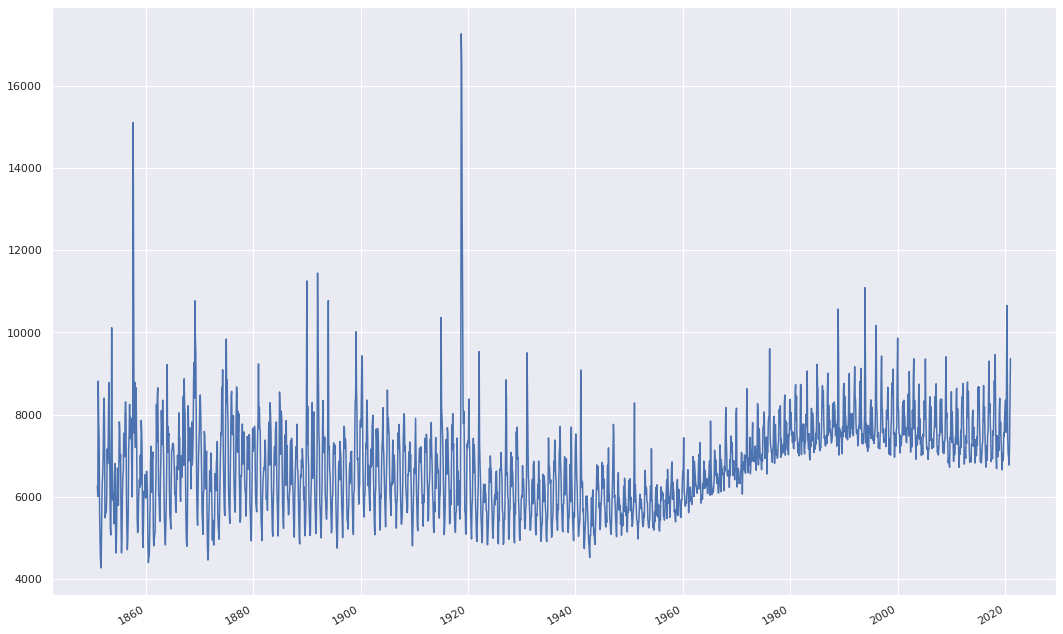

In [6213]:
hist_deaths_ytd.plot(figsize=(18,12))

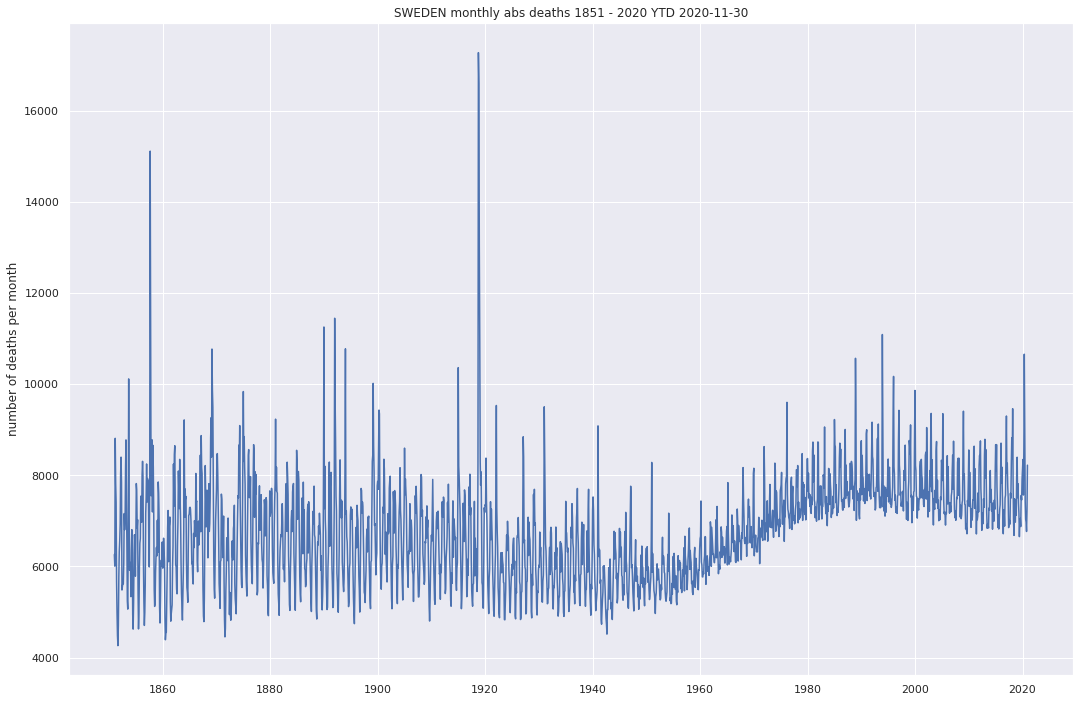

In [6214]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN monthly abs deaths 1851 - 2020 YTD {}'.format(hist_deaths_ytd.index[-2].date()))
plt.plot(hist_deaths_ytd[:-1])
plt.ylabel('number of deaths per month')
plt.savefig('swe_historical_abs_deaths.jpg',format='jpg')

In [6215]:
## population 1860 - 2020

pop_url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'

pop_data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [6216]:
r_pop = requests.post(pop_url, json=pop_data)

In [6217]:
r_pop.status_code

200

In [6218]:
pop_json = r_pop.json()
pop_json['data'][0]

{'key': ['0', '1', '1860'], 'values': ['60589']}

In [6219]:
pop_list = []

nr_records = (len(pop_json['data']))

for rec in range(nr_records):

    pop_list.append ((pop_json['data'][rec]['key'][0],pop_json['data'][rec]['key'][1],
                       pop_json['data'][rec]['key'][2],
                        pop_json['data'][rec]['values'][0]))



In [6220]:
l = list(range(0,100))

str_l = [str(i) for i in l]

str_l.append('100+')
str_l

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100+']

In [6221]:
pop_df = pd.DataFrame(pop_list,columns=['age','gender','year','pop'])
pop_df['pop'] = pop_df['pop'].astype(int)
pop_df['age'] = pd.Categorical(pop_df['age'],str_l)


In [6222]:
pop_df = pop_df.sort_values(['year','age'])
pop_df

age gender  year    pop
0         0      1  1860  60589
160       0      2  1860  58837
320       1      1  1860  56001
480       1      2  1860  54833
640       2      1  1860  52502
...     ...    ...   ...    ...
31679    98      2  2019   2126
31839    99      1  2019    377
31999    99      2  2019   1477
32159  100+      1  2019    375
32319  100+      2  2019   1832

[32320 rows x 4 columns]

In [6223]:
pop_df = pop_df.groupby(['year','age']).sum()
pop_df

pop
year age         
1860 0     119426
     1     110834
     2     104550
     3      92409
     4      86322
...           ...
2019 96      5241
     97      3655
     98      2709
     99      1854
     100+    2207

[16160 rows x 1 columns]

In [6224]:
pop_df.loc['2019'].sum()

pop    10327589
dtype: int64

In [6225]:
total_pops = pop_df.groupby('year').sum()
total_pops.index = pd.to_datetime(total_pops.index).year

In [6226]:
total_pops

pop
year          
1860   3859728
1861   3912498
1862   3957501
1863   4011652
1864   4060806
1865   4108964
1866   4156245
1867   4193830
1868   4194051
1869   4180029
1870   4168525
1871   4206465
1872   4248826
1873   4293477
1874   4331345
1875   4372029
1876   4429713
1877   4484542
1878   4531863
1879   4578901
1880   4565668
1881   4572245
1882   4579115
1883   4603595
1884   4644448
1885   4682769
1886   4717189
1887   4734901
1888   4748257
1889   4774409
1890   4784981
1891   4802751
1892   4806865
1893   4824150
1894   4873183
1895   4919260
1896   4962568
1897   5009632
1898   5062918
1899   5097402
1900   5136441
1901   5175228
1902   5198752
1903   5221291
1904   5260811
1905   5294885
1906   5337055
1907   5377713
1908   5429600
1909   5476441
1910   5522403
1911   5561799
1912   5604192
1913   5638583
1914   5679607
1915   5712740
1916   5757566
1917   5800847
1918   5813850
1919   5847037
1920   5904489
1921   5954316
1922   5987520
1923   6005759
1924   6036118
1925   6053562
1926   6074368
1927   6087923
1928   6105190
1929   6120080
1930   6142191
1931   6162446
1932   6190364
1933   6211566
1934   6233090
1935   6250506
1936   6266888
1937   6284722
1938   6310214
1939   6341303
1940   6371432
1941   6406474
1942   6458200
1943   6522827
1944   6597348
1945   6673749
1946   6763685
1947   6842046
1948   6924888
1949   6986181
1950   7041829
1951   7098740
1952   7150606
1953   7192316
1954   7234664
1955   7290112
1956   7341122
1957   7392872
1958   7436066
1959   7471345
1960   7497967
1961   7542028
1962   7581148
1963   7627507
1964   7695200
1965   7772506
1966   7843088
1967   7892774
1968   7931193
1969   8004270
1970   8081229
1971   8115165
1972   8129129
1973   8144428
1974   8176691
1975   8208442
1976   8236179
1977   8267116
1978   8284437
1979   8303010
1980   8317937
1981   8323033
1982   8327484
1983   8330573
1984   8342621
1985   8358139
1986   8381515
1987   8414083
1988   8458888
1989   8527036
1990   8590630
1991   8644119
1992   8692013
1993   8745109
1994   8816381
1995   8837496
1996   8844499
1997   8847625
1998   8854322
1999   8861426
2000   8882792
2001   8909128
2002   8940788
2003   8975670
2004   9011392
2005   9047752
2006   9113257
2007   9182927
2008   9256347
2009   9340682
2010   9415570
2011   9482855
2012   9555893
2013   9644864
2014   9747355
2015   9851017
2016   9995153
2017  10120242
2018  10230185
2019  10327589

In [6227]:
hist_deaths_ytd.resample('Y').sum()

1851-12-31     72506.0
1852-12-31     80090.0
1853-12-31     84047.0
1854-12-31     70846.0
1855-12-31     77734.0
1856-12-31     79618.0
1857-12-31    101491.0
1858-12-31     80498.0
1859-12-31     75720.0
1860-12-31     67502.0
1861-12-31     71829.0
1862-12-31     84350.0
1863-12-31     77227.0
1864-12-31     81937.0
1865-12-31     79216.0
1866-12-31     82666.0
1867-12-31     82072.0
1868-12-31     87807.0
1869-12-31     92775.0
1870-12-31     82449.0
1871-12-31     72046.0
1872-12-31     68802.0
1873-12-31     73525.0
1874-12-31     87760.0
1875-12-31     88439.0
1876-12-31     86334.0
1877-12-31     83175.0
1878-12-31     81418.0
1879-12-31     77152.0
1880-12-31     82753.0
1881-12-31     80800.0
1882-12-31     79406.0
1883-12-31     79487.0
1884-12-31     81077.0
1885-12-31     82781.0
1886-12-31     78045.0
1887-12-31     76227.0
1888-12-31     75831.0
1889-12-31     76124.0
1890-12-31     81824.0
1891-12-31     80603.0
1892-12-31     85894.0
1893-12-31     81027.0
1894-12-31 

In [6228]:
yearly_abs_deaths = hist_deaths_ytd.resample('Y').sum()

yearly_abs_deaths.index = yearly_abs_deaths.index.year

In [6229]:
yearly_abs_deaths

1851     72506.0
1852     80090.0
1853     84047.0
1854     70846.0
1855     77734.0
1856     79618.0
1857    101491.0
1858     80498.0
1859     75720.0
1860     67502.0
1861     71829.0
1862     84350.0
1863     77227.0
1864     81937.0
1865     79216.0
1866     82666.0
1867     82072.0
1868     87807.0
1869     92775.0
1870     82449.0
1871     72046.0
1872     68802.0
1873     73525.0
1874     87760.0
1875     88439.0
1876     86334.0
1877     83175.0
1878     81418.0
1879     77152.0
1880     82753.0
1881     80800.0
1882     79406.0
1883     79487.0
1884     81077.0
1885     82781.0
1886     78045.0
1887     76227.0
1888     75831.0
1889     76124.0
1890     81824.0
1891     80603.0
1892     85894.0
1893     81027.0
1894     79444.0
1895     74368.0
1896     77259.0
1897     76558.0
1898     75949.0
1899     89678.0
1900     86146.0
1901     82772.0
1902     79722.0
1903     78610.0
1904     80152.0
1905     82443.0
1906     76366.0
1907     78149.0
1908     80568.0
1909     74538

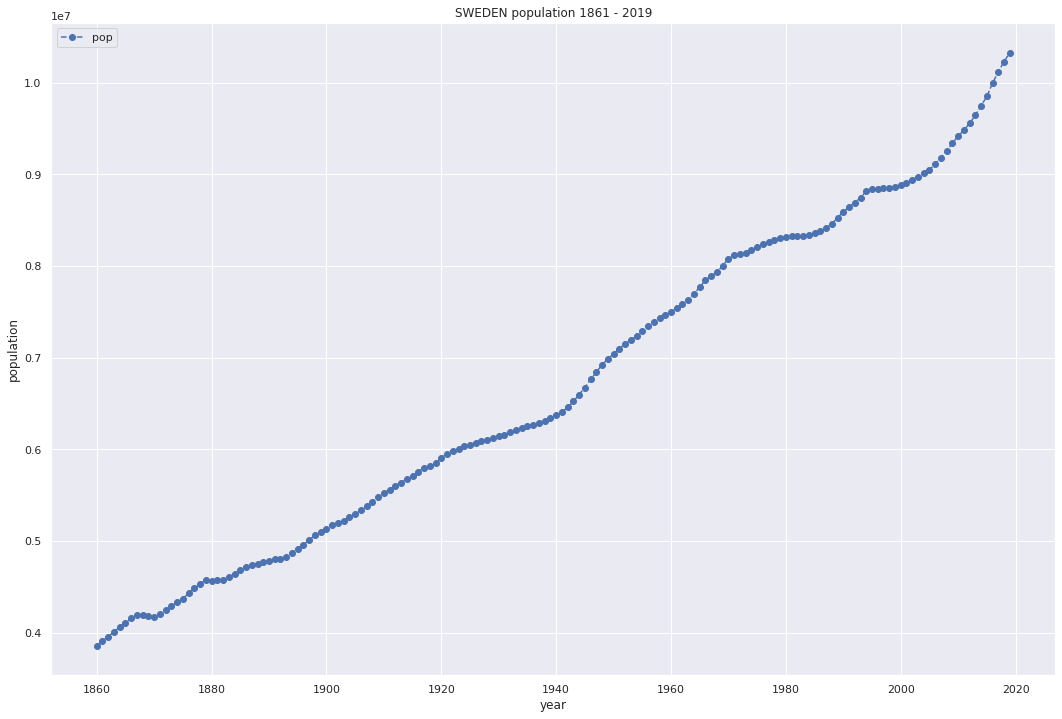

In [6230]:
# includes partial 2020 deaths ! #

title='SWEDEN population 1861 - 2019'
#ax = yearly_abs_deaths[:-1].plot(label='abs_deaths',style='ro--',figsize=(18,12),title=title)
#ax.legend(loc='upper left')
#ax.set_ylabel('abs deaths')
#ax = plt.gca()
#ax2 = plt.twinx()
total_pops.plot(style='bo--',figsize=(18,12),title=title)
plt.ylabel('population')
plt.xlabel('year')
plt.legend(loc='upper left')
#ax2.legend(loc='upper right')
#ax2.set_ylabel('population')

plt.savefig('awe_pop_1861_2019.jpg',format='jpg')

In [6231]:
hist_deaths_ytd

1851-01-01    6261.000000
1851-02-01    6007.000000
1851-03-01    8812.000000
1851-04-01    7818.000000
1851-05-01    7406.000000
                 ...     
2020-08-31    6973.379770
2020-09-30    6766.890475
2020-10-31    7246.644210
2020-11-30    8222.588638
2020-12-31    9362.902655
Length: 2040, dtype: float64

In [6232]:
total_pops.loc['2020','pop'] = np.nan
total_pops = total_pops.shift()
total_pops

pop
year            
1860         NaN
1861   3859728.0
1862   3912498.0
1863   3957501.0
1864   4011652.0
1865   4060806.0
1866   4108964.0
1867   4156245.0
1868   4193830.0
1869   4194051.0
1870   4180029.0
1871   4168525.0
1872   4206465.0
1873   4248826.0
1874   4293477.0
1875   4331345.0
1876   4372029.0
1877   4429713.0
1878   4484542.0
1879   4531863.0
1880   4578901.0
1881   4565668.0
1882   4572245.0
1883   4579115.0
1884   4603595.0
1885   4644448.0
1886   4682769.0
1887   4717189.0
1888   4734901.0
1889   4748257.0
1890   4774409.0
1891   4784981.0
1892   4802751.0
1893   4806865.0
1894   4824150.0
1895   4873183.0
1896   4919260.0
1897   4962568.0
1898   5009632.0
1899   5062918.0
1900   5097402.0
1901   5136441.0
1902   5175228.0
1903   5198752.0
1904   5221291.0
1905   5260811.0
1906   5294885.0
1907   5337055.0
1908   5377713.0
1909   5429600.0
1910   5476441.0
1911   5522403.0
1912   5561799.0
1913   5604192.0
1914   5638583.0
1915   5679607.0
1916   5712740.0
1917   5757566.0
1918   5800847.0
1919   5813850.0
1920   5847037.0
1921   5904489.0
1922   5954316.0
1923   5987520.0
1924   6005759.0
1925   6036118.0
1926   6053562.0
1927   6074368.0
1928   6087923.0
1929   6105190.0
1930   6120080.0
1931   6142191.0
1932   6162446.0
1933   6190364.0
1934   6211566.0
1935   6233090.0
1936   6250506.0
1937   6266888.0
1938   6284722.0
1939   6310214.0
1940   6341303.0
1941   6371432.0
1942   6406474.0
1943   6458200.0
1944   6522827.0
1945   6597348.0
1946   6673749.0
1947   6763685.0
1948   6842046.0
1949   6924888.0
1950   6986181.0
1951   7041829.0
1952   7098740.0
1953   7150606.0
1954   7192316.0
1955   7234664.0
1956   7290112.0
1957   7341122.0
1958   7392872.0
1959   7436066.0
1960   7471345.0
1961   7497967.0
1962   7542028.0
1963   7581148.0
1964   7627507.0
1965   7695200.0
1966   7772506.0
1967   7843088.0
1968   7892774.0
1969   7931193.0
1970   8004270.0
1971   8081229.0
1972   8115165.0
1973   8129129.0
1974   8144428.0
1975   8176691.0
1976   8208442.0
1977   8236179.0
1978   8267116.0
1979   8284437.0
1980   8303010.0
1981   8317937.0
1982   8323033.0
1983   8327484.0
1984   8330573.0
1985   8342621.0
1986   8358139.0
1987   8381515.0
1988   8414083.0
1989   8458888.0
1990   8527036.0
1991   8590630.0
1992   8644119.0
1993   8692013.0
1994   8745109.0
1995   8816381.0
1996   8837496.0
1997   8844499.0
1998   8847625.0
1999   8854322.0
2000   8861426.0
2001   8882792.0
2002   8909128.0
2003   8940788.0
2004   8975670.0
2005   9011392.0
2006   9047752.0
2007   9113257.0
2008   9182927.0
2009   9256347.0
2010   9340682.0
2011   9415570.0
2012   9482855.0
2013   9555893.0
2014   9644864.0
2015   9747355.0
2016   9851017.0
2017   9995153.0
2018  10120242.0
2019  10230185.0
2020  10327589.0

In [6233]:
foo = hist_deaths_ytd.groupby([hist_deaths_ytd.index.year]).sum()
foo.index.name='year'
foo

year
1851     72506.0
1852     80090.0
1853     84047.0
1854     70846.0
1855     77734.0
1856     79618.0
1857    101491.0
1858     80498.0
1859     75720.0
1860     67502.0
1861     71829.0
1862     84350.0
1863     77227.0
1864     81937.0
1865     79216.0
1866     82666.0
1867     82072.0
1868     87807.0
1869     92775.0
1870     82449.0
1871     72046.0
1872     68802.0
1873     73525.0
1874     87760.0
1875     88439.0
1876     86334.0
1877     83175.0
1878     81418.0
1879     77152.0
1880     82753.0
1881     80800.0
1882     79406.0
1883     79487.0
1884     81077.0
1885     82781.0
1886     78045.0
1887     76227.0
1888     75831.0
1889     76124.0
1890     81824.0
1891     80603.0
1892     85894.0
1893     81027.0
1894     79444.0
1895     74368.0
1896     77259.0
1897     76558.0
1898     75949.0
1899     89678.0
1900     86146.0
1901     82772.0
1902     79722.0
1903     78610.0
1904     80152.0
1905     82443.0
1906     76366.0
1907     78149.0
1908     80568.0
1909     

In [6234]:
hist_deaths_ytd = pd.DataFrame(hist_deaths_ytd)
hist_deaths_ytd['year'] = hist_deaths_ytd.index.year
hist_deaths_ytd.columns=['dead','year']

In [6235]:
hist_deaths_ytd

dead  year
1851-01-01  6261.000000  1851
1851-02-01  6007.000000  1851
1851-03-01  8812.000000  1851
1851-04-01  7818.000000  1851
1851-05-01  7406.000000  1851
...                 ...   ...
2020-08-31  6973.379770  2020
2020-09-30  6766.890475  2020
2020-10-31  7246.644210  2020
2020-11-30  8222.588638  2020
2020-12-31  9362.902655  2020

[2040 rows x 2 columns]

In [6236]:
total_pops.index = pd.to_datetime(total_pops.index,format='%Y')
total_pops['y'] = total_pops.index.year
total_pops

pop     y
year                        
1860-01-01         NaN  1860
1861-01-01   3859728.0  1861
1862-01-01   3912498.0  1862
1863-01-01   3957501.0  1863
1864-01-01   4011652.0  1864
1865-01-01   4060806.0  1865
1866-01-01   4108964.0  1866
1867-01-01   4156245.0  1867
1868-01-01   4193830.0  1868
1869-01-01   4194051.0  1869
1870-01-01   4180029.0  1870
1871-01-01   4168525.0  1871
1872-01-01   4206465.0  1872
1873-01-01   4248826.0  1873
1874-01-01   4293477.0  1874
1875-01-01   4331345.0  1875
1876-01-01   4372029.0  1876
1877-01-01   4429713.0  1877
1878-01-01   4484542.0  1878
1879-01-01   4531863.0  1879
1880-01-01   4578901.0  1880
1881-01-01   4565668.0  1881
1882-01-01   4572245.0  1882
1883-01-01   4579115.0  1883
1884-01-01   4603595.0  1884
1885-01-01   4644448.0  1885
1886-01-01   4682769.0  1886
1887-01-01   4717189.0  1887
1888-01-01   4734901.0  1888
1889-01-01   4748257.0  1889
1890-01-01   4774409.0  1890
1891-01-01   4784981.0  1891
1892-01-01   4802751.0  1892
1893-01-01   4806865.0  1893
1894-01-01   4824150.0  1894
1895-01-01   4873183.0  1895
1896-01-01   4919260.0  1896
1897-01-01   4962568.0  1897
1898-01-01   5009632.0  1898
1899-01-01   5062918.0  1899
1900-01-01   5097402.0  1900
1901-01-01   5136441.0  1901
1902-01-01   5175228.0  1902
1903-01-01   5198752.0  1903
1904-01-01   5221291.0  1904
1905-01-01   5260811.0  1905
1906-01-01   5294885.0  1906
1907-01-01   5337055.0  1907
1908-01-01   5377713.0  1908
1909-01-01   5429600.0  1909
1910-01-01   5476441.0  1910
1911-01-01   5522403.0  1911
1912-01-01   5561799.0  1912
1913-01-01   5604192.0  1913
1914-01-01   5638583.0  1914
1915-01-01   5679607.0  1915
1916-01-01   5712740.0  1916
1917-01-01   5757566.0  1917
1918-01-01   5800847.0  1918
1919-01-01   5813850.0  1919
1920-01-01   5847037.0  1920
1921-01-01   5904489.0  1921
1922-01-01   5954316.0  1922
1923-01-01   5987520.0  1923
1924-01-01   6005759.0  1924
1925-01-01   6036118.0  1925
1926-01-01   6053562.0  1926
1927-01-01   6074368.0  1927
1928-01-01   6087923.0  1928
1929-01-01   6105190.0  1929
1930-01-01   6120080.0  1930
1931-01-01   6142191.0  1931
1932-01-01   6162446.0  1932
1933-01-01   6190364.0  1933
1934-01-01   6211566.0  1934
1935-01-01   6233090.0  1935
1936-01-01   6250506.0  1936
1937-01-01   6266888.0  1937
1938-01-01   6284722.0  1938
1939-01-01   6310214.0  1939
1940-01-01   6341303.0  1940
1941-01-01   6371432.0  1941
1942-01-01   6406474.0  1942
1943-01-01   6458200.0  1943
1944-01-01   6522827.0  1944
1945-01-01   6597348.0  1945
1946-01-01   6673749.0  1946
1947-01-01   6763685.0  1947
1948-01-01   6842046.0  1948
1949-01-01   6924888.0  1949
1950-01-01   6986181.0  1950
1951-01-01   7041829.0  1951
1952-01-01   7098740.0  1952
1953-01-01   7150606.0  1953
1954-01-01   7192316.0  1954
1955-01-01   7234664.0  1955
1956-01-01   7290112.0  1956
1957-01-01   7341122.0  1957
1958-01-01   7392872.0  1958
1959-01-01   7436066.0  1959
1960-01-01   7471345.0  1960
1961-01-01   7497967.0  1961
1962-01-01   7542028.0  1962
1963-01-01   7581148.0  1963
1964-01-01   7627507.0  1964
1965-01-01   7695200.0  1965
1966-01-01   7772506.0  1966
1967-01-01   7843088.0  1967
1968-01-01   7892774.0  1968
1969-01-01   7931193.0  1969
1970-01-01   8004270.0  1970
1971-01-01   8081229.0  1971
1972-01-01   8115165.0  1972
1973-01-01   8129129.0  1973
1974-01-01   8144428.0  1974
1975-01-01   8176691.0  1975
1976-01-01   8208442.0  1976
1977-01-01   8236179.0  1977
1978-01-01   8267116.0  1978
1979-01-01   8284437.0  1979
1980-01-01   8303010.0  1980
1981-01-01   8317937.0  1981
1982-01-01   8323033.0  1982
1983-01-01   8327484.0  1983
1984-01-01   8330573.0  1984
1985-01-01   8342621.0  1985
1986-01-01   8358139.0  1986
1987-01-01   8381515.0  1987
1988-01-01   8414083.0  1988
1989-01-01   8458888.0  1989
1990-01-01   8527036.0  1990
1991-01-01   8590630.0  1991
1992-01-01   8644119.0  1992
1993-01-01   8692013.0  1993
1994-01-01   8745109.0  1994
1995-01-01   8816381.0  1995
1996-01-01   8837

In [6237]:
total_pops.reset_index()

year         pop     y
0   1860-01-01         NaN  1860
1   1861-01-01   3859728.0  1861
2   1862-01-01   3912498.0  1862
3   1863-01-01   3957501.0  1863
4   1864-01-01   4011652.0  1864
5   1865-01-01   4060806.0  1865
6   1866-01-01   4108964.0  1866
7   1867-01-01   4156245.0  1867
8   1868-01-01   4193830.0  1868
9   1869-01-01   4194051.0  1869
10  1870-01-01   4180029.0  1870
11  1871-01-01   4168525.0  1871
12  1872-01-01   4206465.0  1872
13  1873-01-01   4248826.0  1873
14  1874-01-01   4293477.0  1874
15  1875-01-01   4331345.0  1875
16  1876-01-01   4372029.0  1876
17  1877-01-01   4429713.0  1877
18  1878-01-01   4484542.0  1878
19  1879-01-01   4531863.0  1879
20  1880-01-01   4578901.0  1880
21  1881-01-01   4565668.0  1881
22  1882-01-01   4572245.0  1882
23  1883-01-01   4579115.0  1883
24  1884-01-01   4603595.0  1884
25  1885-01-01   4644448.0  1885
26  1886-01-01   4682769.0  1886
27  1887-01-01   4717189.0  1887
28  1888-01-01   4734901.0  1888
29  1889-01-01   4748257.0  1889
30  1890-01-01   4774409.0  1890
31  1891-01-01   4784981.0  1891
32  1892-01-01   4802751.0  1892
33  1893-01-01   4806865.0  1893
34  1894-01-01   4824150.0  1894
35  1895-01-01   4873183.0  1895
36  1896-01-01   4919260.0  1896
37  1897-01-01   4962568.0  1897
38  1898-01-01   5009632.0  1898
39  1899-01-01   5062918.0  1899
40  1900-01-01   5097402.0  1900
41  1901-01-01   5136441.0  1901
42  1902-01-01   5175228.0  1902
43  1903-01-01   5198752.0  1903
44  1904-01-01   5221291.0  1904
45  1905-01-01   5260811.0  1905
46  1906-01-01   5294885.0  1906
47  1907-01-01   5337055.0  1907
48  1908-01-01   5377713.0  1908
49  1909-01-01   5429600.0  1909
50  1910-01-01   5476441.0  1910
51  1911-01-01   5522403.0  1911
52  1912-01-01   5561799.0  1912
53  1913-01-01   5604192.0  1913
54  1914-01-01   5638583.0  1914
55  1915-01-01   5679607.0  1915
56  1916-01-01   5712740.0  1916
57  1917-01-01   5757566.0  1917
58  1918-01-01   5800847.0  1918
59  1919-01-01   5813850.0  1919
60  1920-01-01   5847037.0  1920
61  1921-01-01   5904489.0  1921
62  1922-01-01   5954316.0  1922
63  1923-01-01   5987520.0  1923
64  1924-01-01   6005759.0  1924
65  1925-01-01   6036118.0  1925
66  1926-01-01   6053562.0  1926
67  1927-01-01   6074368.0  1927
68  1928-01-01   6087923.0  1928
69  1929-01-01   6105190.0  1929
70  1930-01-01   6120080.0  1930
71  1931-01-01   6142191.0  1931
72  1932-01-01   6162446.0  1932
73  1933-01-01   6190364.0  1933
74  1934-01-01   6211566.0  1934
75  1935-01-01   6233090.0  1935
76  1936-01-01   6250506.0  1936
77  1937-01-01   6266888.0  1937
78  1938-01-01   6284722.0  1938
79  1939-01-01   6310214.0  1939
80  1940-01-01   6341303.0  1940
81  1941-01-01   6371432.0  1941
82  1942-01-01   6406474.0  1942
83  1943-01-01   6458200.0  1943
84  1944-01-01   6522827.0  1944
85  1945-01-01   6597348.0  1945
86  1946-01-01   6673749.0  1946
87  1947-01-01   6763685.0  1947
88  1948-01-01   6842046.0  1948
89  1949-01-01   6924888.0  1949
90  1950-01-01   6986181.0  1950
91  1951-01-01   7041829.0  1951
92  1952-01-01   7098740.0  1952
93  1953-01-01   7150606.0  1953
94  1954-01-01   7192316.0  1954
95  1955-01-01   7234664.0  1955
96  1956-01-01   7290112.0  1956
97  1957-01-01   7341122.0  1957
98  1958-01-01   7392872.0  1958
99  1959-01-01   7436066.0  1959
100 1960-01-01   7471345.0  1960
101 1961-01-01   7497967.0  1961
102 1962-01-01   7542028.0  1962
103 1963-01-01   7581148.0  1963
104 1964-01-01   7627507.0  1964
105 1965-01-01   7695200.0  1965
106 1966-01-01   7772506.0  1966
107 1967-01-01   7843088.0  1967
108 1968-01-01   7892774.0  1968
109 1969-01-01   7931193.0  1969
110 1970-01-01   8004270.0  1970
111 1971-01-01   8081229.0  1971
112 1972-01-01   8115165.0  1972
113 1973-01-01   8129129.0  1973
114 1974-01-01   8144428.0  1974
115 1975-01-01   8176691.0  1975
116 1976-01-01   8208442.0  1976
117 1977-01-01   8236179.0  1977
118 1978-01-01   8267116.0  1978
119 1979-01-01   8284437.0  1979
120 1980-01-01   

In [6238]:
hist_deaths_ytd = hist_deaths_ytd.reset_index()
hist_deaths_ytd

index         dead  year
0    1851-01-01  6261.000000  1851
1    1851-02-01  6007.000000  1851
2    1851-03-01  8812.000000  1851
3    1851-04-01  7818.000000  1851
4    1851-05-01  7406.000000  1851
...         ...          ...   ...
2035 2020-08-31  6973.379770  2020
2036 2020-09-30  6766.890475  2020
2037 2020-10-31  7246.644210  2020
2038 2020-11-30  8222.588638  2020
2039 2020-12-31  9362.902655  2020

[2040 rows x 3 columns]

In [6239]:
hist_deaths_ytd = hist_deaths_ytd.set_index('year')
hist_deaths_ytd

index         dead
year                        
1851 1851-01-01  6261.000000
1851 1851-02-01  6007.000000
1851 1851-03-01  8812.000000
1851 1851-04-01  7818.000000
1851 1851-05-01  7406.000000
...         ...          ...
2020 2020-08-31  6973.379770
2020 2020-09-30  6766.890475
2020 2020-10-31  7246.644210
2020 2020-11-30  8222.588638
2020 2020-12-31  9362.902655

[2040 rows x 2 columns]

In [6240]:
total_pops = total_pops.set_index('y')
total_pops

pop
y               
1860         NaN
1861   3859728.0
1862   3912498.0
1863   3957501.0
1864   4011652.0
1865   4060806.0
1866   4108964.0
1867   4156245.0
1868   4193830.0
1869   4194051.0
1870   4180029.0
1871   4168525.0
1872   4206465.0
1873   4248826.0
1874   4293477.0
1875   4331345.0
1876   4372029.0
1877   4429713.0
1878   4484542.0
1879   4531863.0
1880   4578901.0
1881   4565668.0
1882   4572245.0
1883   4579115.0
1884   4603595.0
1885   4644448.0
1886   4682769.0
1887   4717189.0
1888   4734901.0
1889   4748257.0
1890   4774409.0
1891   4784981.0
1892   4802751.0
1893   4806865.0
1894   4824150.0
1895   4873183.0
1896   4919260.0
1897   4962568.0
1898   5009632.0
1899   5062918.0
1900   5097402.0
1901   5136441.0
1902   5175228.0
1903   5198752.0
1904   5221291.0
1905   5260811.0
1906   5294885.0
1907   5337055.0
1908   5377713.0
1909   5429600.0
1910   5476441.0
1911   5522403.0
1912   5561799.0
1913   5604192.0
1914   5638583.0
1915   5679607.0
1916   5712740.0
1917   5757566.0
1918   5800847.0
1919   5813850.0
1920   5847037.0
1921   5904489.0
1922   5954316.0
1923   5987520.0
1924   6005759.0
1925   6036118.0
1926   6053562.0
1927   6074368.0
1928   6087923.0
1929   6105190.0
1930   6120080.0
1931   6142191.0
1932   6162446.0
1933   6190364.0
1934   6211566.0
1935   6233090.0
1936   6250506.0
1937   6266888.0
1938   6284722.0
1939   6310214.0
1940   6341303.0
1941   6371432.0
1942   6406474.0
1943   6458200.0
1944   6522827.0
1945   6597348.0
1946   6673749.0
1947   6763685.0
1948   6842046.0
1949   6924888.0
1950   6986181.0
1951   7041829.0
1952   7098740.0
1953   7150606.0
1954   7192316.0
1955   7234664.0
1956   7290112.0
1957   7341122.0
1958   7392872.0
1959   7436066.0
1960   7471345.0
1961   7497967.0
1962   7542028.0
1963   7581148.0
1964   7627507.0
1965   7695200.0
1966   7772506.0
1967   7843088.0
1968   7892774.0
1969   7931193.0
1970   8004270.0
1971   8081229.0
1972   8115165.0
1973   8129129.0
1974   8144428.0
1975   8176691.0
1976   8208442.0
1977   8236179.0
1978   8267116.0
1979   8284437.0
1980   8303010.0
1981   8317937.0
1982   8323033.0
1983   8327484.0
1984   8330573.0
1985   8342621.0
1986   8358139.0
1987   8381515.0
1988   8414083.0
1989   8458888.0
1990   8527036.0
1991   8590630.0
1992   8644119.0
1993   8692013.0
1994   8745109.0
1995   8816381.0
1996   8837496.0
1997   8844499.0
1998   8847625.0
1999   8854322.0
2000   8861426.0
2001   8882792.0
2002   8909128.0
2003   8940788.0
2004   8975670.0
2005   9011392.0
2006   9047752.0
2007   9113257.0
2008   9182927.0
2009   9256347.0
2010   9340682.0
2011   9415570.0
2012   9482855.0
2013   9555893.0
2014   9644864.0
2015   9747355.0
2016   9851017.0
2017   9995153.0
2018  10120242.0
2019  10230185.0
2020  10327589.0

In [6241]:
mortality_per_month = hist_deaths_ytd['dead'] / total_pops['pop']
mortality_per_month = pd.DataFrame(mortality_per_month,columns=['mortality'])
mortality_per_month

mortality
1851        NaN
1851        NaN
1851        NaN
1851        NaN
1851        NaN
...         ...
2020   0.000675
2020   0.000655
2020   0.000702
2020   0.000796
2020   0.000907

[2040 rows x 1 columns]

In [6242]:
mortality_per_month.index = hist_deaths_ytd['index']
mortality_per_month['month'] = mortality_per_month.index.month
mortality_per_month

mortality  month
index                       
1851-01-01        NaN      1
1851-02-01        NaN      2
1851-03-01        NaN      3
1851-04-01        NaN      4
1851-05-01        NaN      5
...               ...    ...
2020-08-31   0.000675      8
2020-09-30   0.000655      9
2020-10-31   0.000702     10
2020-11-30   0.000796     11
2020-12-31   0.000907     12

[2040 rows x 2 columns]

In [6243]:
mortality_per_month = mortality_per_month.dropna()

In [6244]:
mortality_per_month

mortality  month
index                       
1861-01-01   0.001873      1
1861-02-01   0.001581      2
1861-03-01   0.001775      3
1861-04-01   0.001792      4
1861-05-01   0.001836      5
...               ...    ...
2020-08-31   0.000675      8
2020-09-30   0.000655      9
2020-10-31   0.000702     10
2020-11-30   0.000796     11
2020-12-31   0.000907     12

[1920 rows x 2 columns]

In [6245]:
### param ### 
last_complete_month = 12
###

full_mortality_per_month = mortality_per_month.copy()

mortality_per_month = mortality_per_month.loc[mortality_per_month['month'] <= last_complete_month]


In [6246]:
yearly_mortality = mortality_per_month.groupby(mortality_per_month.index.year).sum()
yearly_mortality

mortality  month
index                  
1861    0.018610     78
1862    0.021559     78
1863    0.019514     78
1864    0.020425     78
1865    0.019507     78
1866    0.020118     78
1867    0.019747     78
1868    0.020937     78
1869    0.022121     78
1870    0.019725     78
1871    0.017283     78
1872    0.016356     78
1873    0.017305     78
1874    0.020440     78
1875    0.020418     78
1876    0.019747     78
1877    0.018777     78
1878    0.018155     78
1879    0.017024     78
1880    0.018073     78
1881    0.017697     78
1882    0.017367     78
1883    0.017359     78
1884    0.017612     78
1885    0.017824     78
1886    0.016666     78
1887    0.016159     78
1888    0.016015     78
1889    0.016032     78
1890    0.017138     78
1891    0.016845     78
1892    0.017884     78
1893    0.016857     78
1894    0.016468     78
1895    0.015261     78
1896    0.015705     78
1897    0.015427     78
1898    0.015161     78
1899    0.017713     78
1900    0.016900     78
1901    0.016115     78
1902    0.015405     78
1903    0.015121     78
1904    0.015351     78
1905    0.015671     78
1906    0.014423     78
1907    0.014643     78
1908    0.014982     78
1909    0.013728     78
1910    0.014099     78
1911    0.013846     78
1912    0.014247     78
1913    0.013690     78
1914    0.013888     78
1915    0.014717     78
1916    0.013614     78
1917    0.013441     78
1918    0.018030     78
1919    0.014498     78
1920    0.013362     78
1921    0.012454     78
1922    0.012821     78
1923    0.011428     78
1924    0.011989     78
1925    0.011749     78
1926    0.011785     78
1927    0.012712     78
1928    0.012035     78
1929    0.012209     78
1930    0.011730     78
1931    0.012556     78
1932    0.011596     78
1933    0.011244     78
1934    0.011257     78
1935    0.011682     78
1936    0.011973     78
1937    0.012030     78
1938    0.011567     78
1939    0.011549     78
1940    0.011472     78
1941    0.011286     78
1942    0.009949     78
1943    0.010236     78
1944    0.011082     78
1945    0.010898     78
1946    0.010584     78
1947    0.010879     78
1948    0.009894     78
1949    0.010042     78
1950    0.010062     78
1951    0.009912     78
1952    0.009617     78
1953    0.009727     78
1954    0.009598     78
1955    0.009487     78
1956    0.009630     78
1957    0.009962     78
1958    0.009613     78
1959    0.009533     78
1960    0.010051     78
1961    0.009810     78
1962    0.010182     78
1963    0.010086     78
1964    0.010051     78
1965    0.010161     78
1966    0.010092     78
1967    0.010172     78
1968    0.010450     78
1969    0.010509     78
1970    0.009998     78
1971    0.010236     78
1972    0.010358     78
1973    0.010535     78
1974    0.010598     78
1975    0.010788     78
1976    0.011047     78
1977    0.010709     78
1978    0.010848     78
1979    0.010993     78
1980    0.011056     78
1981    0.011065     78
1982    0.010894     78
1983    0.010903     78
1984    0.010862     78
1985    0.011271     78
1986    0.011162     78
1987    0.011132     78
1988    0.011498     78
1989    0.010889     78
1990    0.011160     78
1991    0.011082     78
1992    0.010957     78
1993    0.011161     78
1994    0.010502     78
1995    0.010657     78
1996    0.010652     78
1997    0.010552     78
1998    0.010542     78
1999    0.010698     78
2000    0.010547     78
2001    0.010554     78
2002    0.010664     78
2003    0.010397     78
2004    0.010086     78
2005    0.010177     78
2006    0.010077     78
2007    0.010065     78
2008    0.009959     78
2009    0.009732     78
2010    0.009687     78
2011    0.009552     78
2012    0.009695     78
2013    0.009460     78
2014    0.009225     78
2015    0.009326     78
2016    0.009236     78
2017    0.009202     78
2018    0.009109     78
2019    0.008677     78
2020    0.009408     78

Text(0.5, 0, 'year')

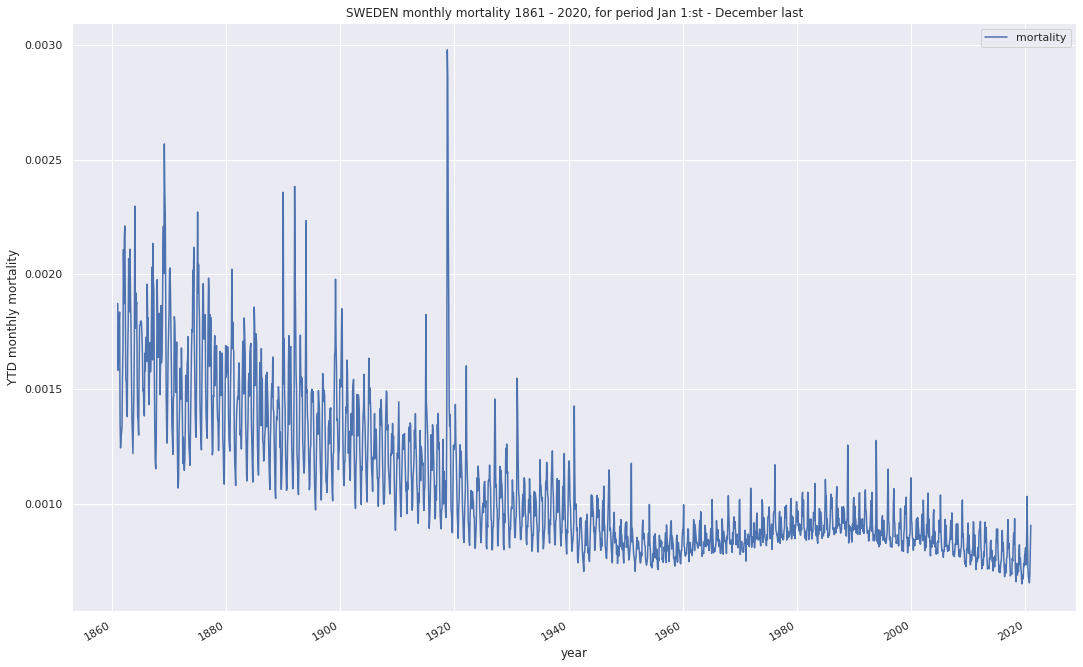

In [6247]:
title = 'SWEDEN monthly mortality 1861 - 2020, for period Jan 1:st - {} last'.format(
mortality_per_month.index[-1].month_name())
mortality_per_month.plot(y='mortality',figsize=(18,12),title=title)
plt.ylabel('YTD monthly mortality')
plt.xlabel('year')

In [6248]:
mortality_per_month.index[-1].date()

datetime.date(2020, 12, 31)

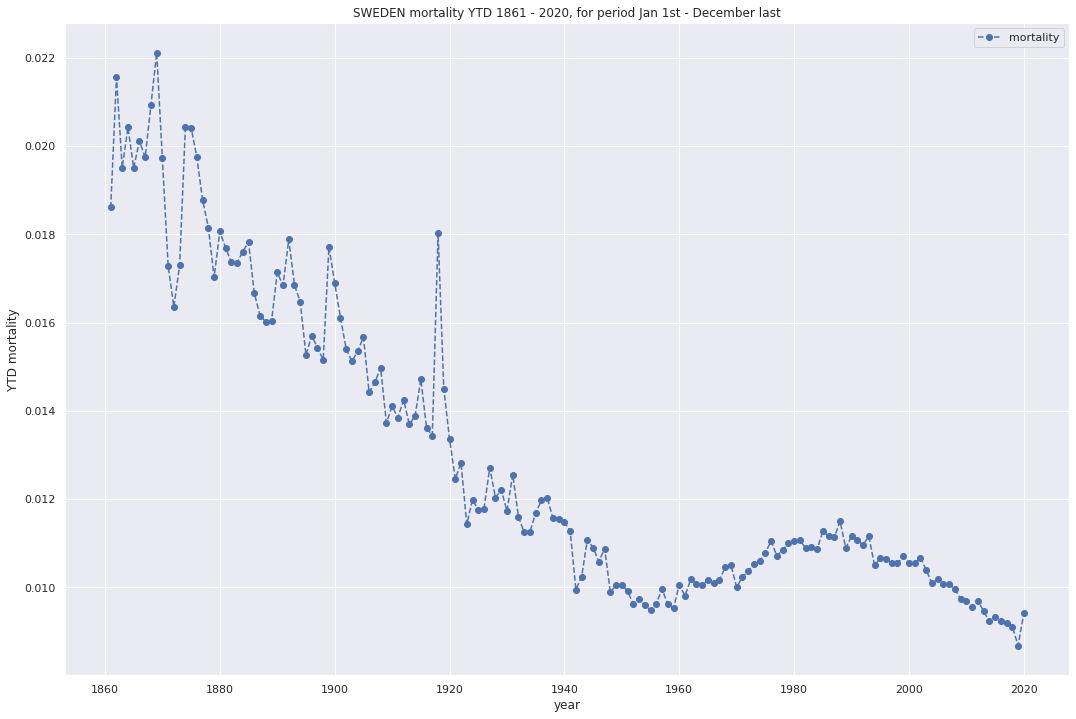

In [6249]:
yearly_mortality.plot(y='mortality',figsize=(18,12),style='o--',
                      title='SWEDEN mortality YTD 1861 - 2020, for period Jan 1st - {} last'.format(
mortality_per_month.index[-1].month_name()))

plt.ylabel('YTD mortality')
plt.xlabel('year')

plt.savefig('swe_historical_mortality_YTD_1861_2020.jpg',format='jpg')

mortality  month
index                       
1861-01-01   0.001873      1
1861-02-01   0.001581      2
1861-03-01   0.001775      3
1861-04-01   0.001792      4
1861-05-01   0.001836      5
...               ...    ...
2020-08-31   0.000675      8
2020-09-30   0.000655      9
2020-10-31   0.000702     10
2020-11-30   0.000796     11
2020-12-31   0.000907     12

[1920 rows x 2 columns]

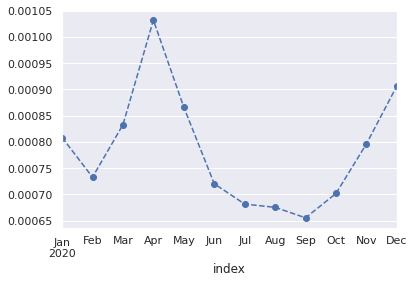

In [6250]:
(mortality_per_month.loc['2020-01-01' :,'mortality' ]).plot(style='o--')
mortality_per_month

In [6251]:
year_month_mortality = mortality_per_month.groupby([mortality_per_month.index.year,
                                                    mortality_per_month.index.month]).mean()

year_month_mortality = year_month_mortality.droplevel(level=1)
year_month_mortality

mortality  month
index                  
1861    0.001873      1
1861    0.001581      2
1861    0.001775      3
1861    0.001792      4
1861    0.001836      5
...          ...    ...
2020    0.000675      8
2020    0.000655      9
2020    0.000702     10
2020    0.000796     11
2020    0.000907     12

[1920 rows x 2 columns]

In [6252]:
avg_mortality_15_18 = year_month_mortality.loc['2015' : '2018'].groupby('month').mean()
avg_mortality_15_18

mortality
month           
1       0.000894
2       0.000814
3       0.000871
4       0.000777
5       0.000730
6       0.000683
7       0.000725
8       0.000705
9       0.000700
10      0.000751
11      0.000744
12      0.000825

In [6253]:
monthly_mort_2020 = mortality_per_month.loc['2020-01-01' :,'mortality']
monthly_mort_2020

index
2020-01-31    0.000808
2020-02-29    0.000733
2020-03-31    0.000833
2020-04-30    0.001032
2020-05-31    0.000866
2020-06-30    0.000720
2020-07-31    0.000681
2020-08-31    0.000675
2020-09-30    0.000655
2020-10-31    0.000702
2020-11-30    0.000796
2020-12-31    0.000907
Name: mortality, dtype: float64

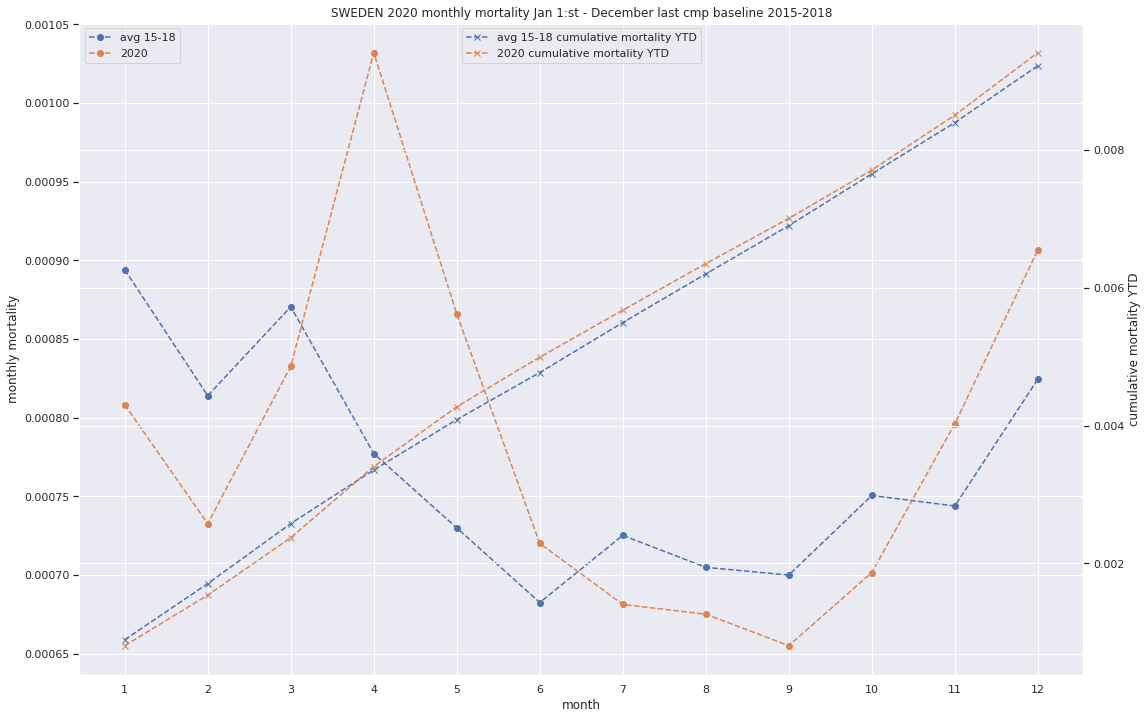

In [6254]:
title = 'SWEDEN 2020 monthly mortality Jan 1:st - {} last cmp baseline 2015-2018'.format(
    mortality_per_month.index[-1].month_name())

ax = avg_mortality_15_18.reset_index().plot(y='mortality',title=title,
                                            style='o--',label='avg 15-18',figsize=(18,12))

(mortality_per_month.loc['2020-01-01' :,'mortality' ]).reset_index().plot(style='o--',y='mortality',
                                                                          label='2020',ax=ax)

plt.xticks(range(len(avg_mortality_15_18)),range(1,len(avg_mortality_15_18) + 1))
plt.xlabel('month')
plt.ylabel('monthly mortality')
plt.legend(loc='upper left')

ax2 = plt.twinx()

ax2.plot(avg_mortality_15_18['mortality'].values.cumsum(),'x--',label='avg 15-18 cumulative mortality YTD')
ax2.plot(monthly_mort_2020.values.cumsum(),'x--',label='2020 cumulative mortality YTD')

ax2.set_ylabel('cumulative mortality YTD')
ax2.legend(loc='upper center')
plt.savefig('swe_monthly_mortality_vs_baseline.jpg',format='jpg')

In [6255]:
death_url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/DodaFodelsearK'

death_data = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": [
          "00"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [6256]:
r_death_age = requests.post(death_url,json=death_data)
r_death_age.status_code

200

In [6257]:
death_age_json = r_death_age.json()
death_age_json['data'][0]

{'key': ['00', '0', '1', '1968'], 'values': ['783']}

In [6258]:
death_age_list = []

nr_records = (len(death_age_json['data']))

for rec in range(nr_records):

    death_age_list.append ((death_age_json['data'][rec]['key'][0],death_age_json['data'][rec]['key'][1],
                       death_age_json['data'][rec]['key'][2],death_age_json['data'][rec]['key'][3],
                        death_age_json['data'][rec]['values'][0]))



In [6259]:
death_age_df = pd.DataFrame(death_age_list,columns=['riket','age','gender','year','deaths'])
death_age_df['deaths'] = death_age_df['deaths'].astype(int)
death_age_df

riket   age gender  year  deaths
0        00     0      1  1968     783
1        00     0      1  1969     712
2        00     0      1  1970     662
3        00     0      1  1971     689
4        00     0      1  1972     689
...     ...   ...    ...   ...     ...
10499    00  100+      2  2015    1025
10500    00  100+      2  2016     979
10501    00  100+      2  2017    1047
10502    00  100+      2  2018    1070
10503    00  100+      2  2019    1005

[10504 rows x 5 columns]

In [6260]:
death_age_df['age'] = pd.Categorical(death_age_df['age'],str_l)

death_age_df = death_age_df.groupby(['year','age']).sum()

death_age_df

deaths
year age         
1968 0       1349
     1        169
     2         79
     3         62
     4         50
...           ...
2019 96      1760
     97      1324
     98      1160
     99       868
     100+    1253

[5252 rows x 1 columns]

In [6261]:
pop_df

pop
year age         
1860 0     119426
     1     110834
     2     104550
     3      92409
     4      86322
...           ...
2019 96      5241
     97      3655
     98      2709
     99      1854
     100+    2207

[16160 rows x 1 columns]

In [6262]:
age_mortality = death_age_df['deaths'] /pop_df['pop'] 
age_mortality.dropna(inplace=True)

In [6263]:
age_mortality = pd.DataFrame(age_mortality,columns=['mortality'])
age_mortality = age_mortality.reset_index().set_index('year')
age_mortality

age  mortality
year                 
1968     0   0.012165
1968     1   0.001406
1968     2   0.000649
1968     3   0.000508
1968     4   0.000409
...    ...        ...
2019    96   0.335814
2019    97   0.362244
2019    98   0.428202
2019    99   0.468177
2019  100+   0.567739

[5252 rows x 2 columns]

In [6264]:
pop_df_mask = pop_df.index.get_level_values(0) == '2019'
age_std_pop = pop_df[pop_df_mask]
age_std_pop = age_std_pop.reset_index().set_index('year')
age_std_pop

age     pop
year              
2019     0  115383
2019     1  118776
2019     2  120030
2019     3  124681
2019     4  122848
2019     5  124569
2019     6  123335
2019     7  124541
2019     8  123471
2019     9  128168
2019    10  124897
2019    11  123654
2019    12  121905
2019    13  121199
2019    14  117364
2019    15  116944
2019    16  115523
2019    17  113220
2019    18  110326
2019    19  112896
2019    20  116615
2019    21  113130
2019    22  112295
2019    23  118181
2019    24  127478
2019    25  137195
2019    26  143233
2019    27  149623
2019    28  153357
2019    29  156288
2019    30  149862
2019    31  147879
2019    32  141166
2019    33  139859
2019    34  137125
2019    35  132541
2019    36  129376
2019    37  129609
2019    38  127537
2019    39  131535
2019    40  127439
2019    41  123405
2019    42  124745
2019    43  125676
2019    44  129998
2019    45  135272
2019    46  132678
2019    47  134736
2019    48  133927
2019    49  130479
2019    50  127993
2019    51  132894
2019    52  138613
2019    53  139269
2019    54  138986
2019    55  137804
2019    56  128099
2019    57  121763
2019    58  117040
2019    59  115402
2019    60  115014
2019    61  113959
2019    62  114438
2019    63  113841
2019    64  111138
2019    65  108095
2019    66  109510
2019    67  107927
2019    68  105509
2019    69  109007
2019    70  111522
2019    71  113904
2019    72  113141
2019    73  112310
2019    74  109538
2019    75  105077
2019    76   95932
2019    77   85993
2019    78   73767
2019    79   67829
2019    80   65302
2019    81   60124
2019    82   54029
2019    83   49510
2019    84   44085
2019    85   39486
2019    86   35646
2019    87   33049
2019    88   29430
2019    89   26018
2019    90   21450
2019    91   18531
2019    92   15006
2019    93   12119
2019    94    9538
2019    95    7317
2019    96    5241
2019    97    3655
2019    98    2709
2019    99    1854
2019  100+    2207

In [6265]:
nr_unique_years = len(age_mortality.index.unique())

age_mortality['std_pop'] = np.tile(age_std_pop['pop'],nr_unique_years)
age_mortality['age_adj_deaths'] = age_mortality['mortality'] * age_mortality['std_pop']
age_mortality

age  mortality  std_pop  age_adj_deaths
year                                          
1968     0   0.012165   115383     1403.670941
1968     1   0.001406   118776      167.027051
1968     2   0.000649   120030       77.944762
1968     3   0.000508   124681       63.303842
1968     4   0.000409   122848       50.266785
...    ...        ...      ...             ...
2019    96   0.335814     5241     1760.000000
2019    97   0.362244     3655     1324.000000
2019    98   0.428202     2709     1160.000000
2019    99   0.468177     1854      868.000000
2019  100+   0.567739     2207     1253.000000

[5252 rows x 4 columns]

In [6266]:
age_adj_deaths = age_mortality.groupby('year').sum()
age_adj_deaths['age_pop_adj_mortality'] = age_adj_deaths['age_adj_deaths'] / age_std_pop['pop'].sum()
age_adj_deaths

mortality   std_pop  age_adj_deaths  age_pop_adj_mortality
year                                                            
1968   7.910322  10327589   192447.503662               0.018634
1969   7.378283  10327589   188470.279907               0.018249
1970   6.742434  10327589   174723.843678               0.016918
1971   6.711811  10327589   175558.359079               0.016999
1972   7.161116  10327589   176400.120914               0.017080
1973   6.777326  10327589   175074.933125               0.016952
1974   6.794628  10327589   172565.464650               0.016709
1975   6.838526  10327589   173075.141733               0.016759
1976   7.038916  10327589   176096.825069               0.017051
1977   6.414906  10327589   166045.756978               0.016078
1978   6.411491  10327589   165000.826437               0.015977
1979   6.499791  10327589   164735.520590               0.015951
1980   6.548866  10327589   163566.919823               0.015838
1981   6.412136  10327589   161251.463836               0.015614
1982   6.119663  10327589   155104.027738               0.015018
1983   6.168865  10327589   153043.468160               0.014819
1984   5.963334  10327589   148838.131011               0.014412
1985   6.294339  10327589   152896.493230               0.014805
1986   6.008658  10327589   148523.779624               0.014381
1987   5.954834  10327589   145995.570115               0.014136
1988   6.399560  10327589   149786.681550               0.014504
1989   5.913057  10327589   139698.645873               0.013527
1990   6.018720  10327589   141937.667084               0.013744
1991   6.010575  10327589   139803.051162               0.013537
1992   5.904898  10327589   137107.046419               0.013276
1993   6.239817  10327589   139262.069774               0.013484
1994   5.580311  10327589   128748.975804               0.012467
1995   5.600896  10327589   129630.959035               0.012552
1996   5.803900  10327589   128619.113145               0.012454
1997   5.769938  10327589   125923.589515               0.012193
1998   5.482690  10327589   123719.086784               0.011979
1999   5.751007  10327589   124543.650838               0.012059
2000   5.578273  10327589   121273.220040               0.011743
2001   5.582049  10327589   120272.127814               0.011646
2002   5.705810  10327589   120960.661125               0.011712
2003   5.547367  10327589   116930.772565               0.011322
2004   5.262088  10327589   112150.065182               0.010859
2005   5.293151  10327589   112088.620658               0.010853
2006   5.316734  10327589   109970.149390               0.010648
2007   5.362980  10327589   109359.381971               0.010589
2008   5.302400  10327589   107636.158560               0.010422
2009   5.205486  10327589   104654.080882               0.010133
2010   5.084711  10327589   103606.357825               0.010032
2011   5.046269  10327589   101559.021788               0.009834
2012   5.261044  10327589   102799.024897               0.009954
2013   5.109698  10327589    99711.091169               0.009655
2014   4.937015  10327589    96443.580765               0.009338
2015   5.023273  10327589    97201.239201               0.009412
2016   4.916679  10327589    95710.225952               0.009267
2017   5.070704  10327589    95481.556967               0.009245
2018   4.958721  10327589    94190.305325               0.009120
2019   4.597594  10327589    88766.000000               0.008595

In [6267]:
yearly_mortality

mortality  month
index                  
1861    0.018610     78
1862    0.021559     78
1863    0.019514     78
1864    0.020425     78
1865    0.019507     78
1866    0.020118     78
1867    0.019747     78
1868    0.020937     78
1869    0.022121     78
1870    0.019725     78
1871    0.017283     78
1872    0.016356     78
1873    0.017305     78
1874    0.020440     78
1875    0.020418     78
1876    0.019747     78
1877    0.018777     78
1878    0.018155     78
1879    0.017024     78
1880    0.018073     78
1881    0.017697     78
1882    0.017367     78
1883    0.017359     78
1884    0.017612     78
1885    0.017824     78
1886    0.016666     78
1887    0.016159     78
1888    0.016015     78
1889    0.016032     78
1890    0.017138     78
1891    0.016845     78
1892    0.017884     78
1893    0.016857     78
1894    0.016468     78
1895    0.015261     78
1896    0.015705     78
1897    0.015427     78
1898    0.015161     78
1899    0.017713     78
1900    0.016900     78
1901    0.016115     78
1902    0.015405     78
1903    0.015121     78
1904    0.015351     78
1905    0.015671     78
1906    0.014423     78
1907    0.014643     78
1908    0.014982     78
1909    0.013728     78
1910    0.014099     78
1911    0.013846     78
1912    0.014247     78
1913    0.013690     78
1914    0.013888     78
1915    0.014717     78
1916    0.013614     78
1917    0.013441     78
1918    0.018030     78
1919    0.014498     78
1920    0.013362     78
1921    0.012454     78
1922    0.012821     78
1923    0.011428     78
1924    0.011989     78
1925    0.011749     78
1926    0.011785     78
1927    0.012712     78
1928    0.012035     78
1929    0.012209     78
1930    0.011730     78
1931    0.012556     78
1932    0.011596     78
1933    0.011244     78
1934    0.011257     78
1935    0.011682     78
1936    0.011973     78
1937    0.012030     78
1938    0.011567     78
1939    0.011549     78
1940    0.011472     78
1941    0.011286     78
1942    0.009949     78
1943    0.010236     78
1944    0.011082     78
1945    0.010898     78
1946    0.010584     78
1947    0.010879     78
1948    0.009894     78
1949    0.010042     78
1950    0.010062     78
1951    0.009912     78
1952    0.009617     78
1953    0.009727     78
1954    0.009598     78
1955    0.009487     78
1956    0.009630     78
1957    0.009962     78
1958    0.009613     78
1959    0.009533     78
1960    0.010051     78
1961    0.009810     78
1962    0.010182     78
1963    0.010086     78
1964    0.010051     78
1965    0.010161     78
1966    0.010092     78
1967    0.010172     78
1968    0.010450     78
1969    0.010509     78
1970    0.009998     78
1971    0.010236     78
1972    0.010358     78
1973    0.010535     78
1974    0.010598     78
1975    0.010788     78
1976    0.011047     78
1977    0.010709     78
1978    0.010848     78
1979    0.010993     78
1980    0.011056     78
1981    0.011065     78
1982    0.010894     78
1983    0.010903     78
1984    0.010862     78
1985    0.011271     78
1986    0.011162     78
1987    0.011132     78
1988    0.011498     78
1989    0.010889     78
1990    0.011160     78
1991    0.011082     78
1992    0.010957     78
1993    0.011161     78
1994    0.010502     78
1995    0.010657     78
1996    0.010652     78
1997    0.010552     78
1998    0.010542     78
1999    0.010698     78
2000    0.010547     78
2001    0.010554     78
2002    0.010664     78
2003    0.010397     78
2004    0.010086     78
2005    0.010177     78
2006    0.010077     78
2007    0.010065     78
2008    0.009959     78
2009    0.009732     78
2010    0.009687     78
2011    0.009552     78
2012    0.009695     78
2013    0.009460     78
2014    0.009225     78
2015    0.009326     78
2016    0.009236     78
2017    0.009202     78
2018    0.009109     78
2019    0.008677     78
2020    0.009408     78

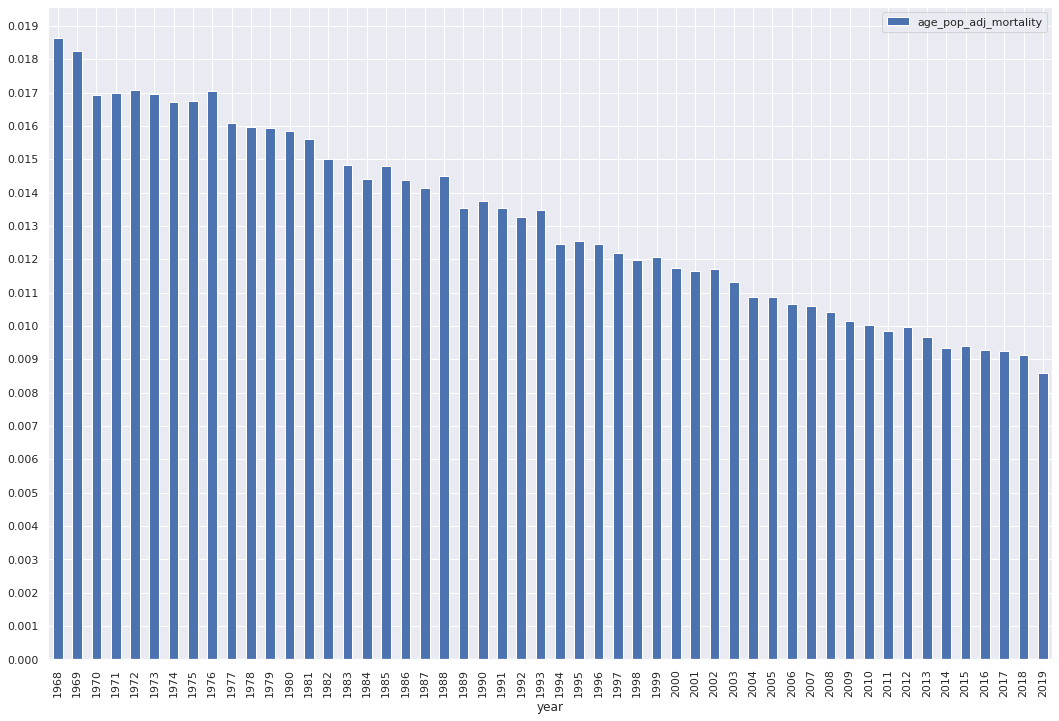

In [6268]:

age_adj_deaths.plot(kind='bar',y='age_pop_adj_mortality',figsize=(18,12))
_= plt.yticks(np.arange(0,0.02,0.001))

In [6269]:
yearly_mortality.loc[1968:2019]

mortality  month
index                  
1968    0.010450     78
1969    0.010509     78
1970    0.009998     78
1971    0.010236     78
1972    0.010358     78
1973    0.010535     78
1974    0.010598     78
1975    0.010788     78
1976    0.011047     78
1977    0.010709     78
1978    0.010848     78
1979    0.010993     78
1980    0.011056     78
1981    0.011065     78
1982    0.010894     78
1983    0.010903     78
1984    0.010862     78
1985    0.011271     78
1986    0.011162     78
1987    0.011132     78
1988    0.011498     78
1989    0.010889     78
1990    0.011160     78
1991    0.011082     78
1992    0.010957     78
1993    0.011161     78
1994    0.010502     78
1995    0.010657     78
1996    0.010652     78
1997    0.010552     78
1998    0.010542     78
1999    0.010698     78
2000    0.010547     78
2001    0.010554     78
2002    0.010664     78
2003    0.010397     78
2004    0.010086     78
2005    0.010177     78
2006    0.010077     78
2007    0.010065     78
2008    0.009959     78
2009    0.009732     78
2010    0.009687     78
2011    0.009552     78
2012    0.009695     78
2013    0.009460     78
2014    0.009225     78
2015    0.009326     78
2016    0.009236     78
2017    0.009202     78
2018    0.009109     78
2019    0.008677     78

In [6270]:
pop_df

pop
year age         
1860 0     119426
     1     110834
     2     104550
     3      92409
     4      86322
...           ...
2019 96      5241
     97      3655
     98      2709
     99      1854
     100+    2207

[16160 rows x 1 columns]

In [6271]:
death_age_df.reset_index(inplace=True)

In [6272]:
def str_2_int(s):
    if s[-1] == '+':
        return int(s[:-1])
    return int(s)

death_age_df['age_num'] = (death_age_df['age'].apply(str_2_int)).astype(int)

In [6273]:
death_age_df

year   age  deaths  age_num
0     1968     0    1349        0
1     1968     1     169        1
2     1968     2      79        2
3     1968     3      62        3
4     1968     4      50        4
...    ...   ...     ...      ...
5247  2019    96    1760       96
5248  2019    97    1324       97
5249  2019    98    1160       98
5250  2019    99     868       99
5251  2019  100+    1253      100

[5252 rows x 4 columns]

In [6274]:
death_age_df['grp'] = pd.cut(death_age_df.reset_index()['age_num'],[-1,64,79,89,1000])
death_age_df

year   age  deaths  age_num         grp
0     1968     0    1349        0    (-1, 64]
1     1968     1     169        1    (-1, 64]
2     1968     2      79        2    (-1, 64]
3     1968     3      62        3    (-1, 64]
4     1968     4      50        4    (-1, 64]
...    ...   ...     ...      ...         ...
5247  2019    96    1760       96  (89, 1000]
5248  2019    97    1324       97  (89, 1000]
5249  2019    98    1160       98  (89, 1000]
5250  2019    99     868       99  (89, 1000]
5251  2019  100+    1253      100  (89, 1000]

[5252 rows x 5 columns]

In [6275]:
grp_death = death_age_df.groupby(['year','grp']).sum()
grp_death

deaths  age_num
year grp                        
1968 (-1, 64]     20248     2080
     (64, 79]     33867     1080
     (79, 89]     23470      845
     (89, 1000]    4879     1045
1969 (-1, 64]     20474     2080
     (64, 79]     34692     1080
     (79, 89]     23154      845
     (89, 1000]    5018     1045
1970 (-1, 64]     19906     2080
     (64, 79]     33057     1080
     (79, 89]     22180      845
     (89, 1000]    4873     1045
1971 (-1, 64]     20133     2080
     (64, 79]     34295     1080
     (79, 89]     23163      845
     (89, 1000]    5143     1045
1972 (-1, 64]     19974     2080
     (64, 79]     35047     1080
     (79, 89]     23504      845
     (89, 1000]    5531     1045
1973 (-1, 64]     19497     2080
     (64, 79]     35664     1080
     (79, 89]     24823      845
     (89, 1000]    5656     1045
1974 (-1, 64]     19363     2080
     (64, 79]     36129     1080
     (79, 89]     24745      845
     (89, 1000]    6079     1045
1975 (-1, 64]     19412     2080
     (64, 79]     36661     1080
     (79, 89]     25764      845
     (89, 1000]    6371     1045
1976 (-1, 64]     19319     2080
     (64, 79]     37448     1080
     (79, 89]     26843      845
     (89, 1000]    7067     1045
1977 (-1, 64]     18855     2080
     (64, 79]     36487     1080
     (79, 89]     26003      845
     (89, 1000]    6855     1045
1978 (-1, 64]     18402     2080
     (64, 79]     37338     1080
     (79, 89]     26863      845
     (89, 1000]    7078     1045
1979 (-1, 64]     18501     2080
     (64, 79]     37556     1080
     (79, 89]     27503      845
     (89, 1000]    7514     1045
1980 (-1, 64]     18193     2080
     (64, 79]     37380     1080
     (79, 89]     28301      845
     (89, 1000]    7923     1045
1981 (-1, 64]     17422     2080
     (64, 79]     37342     1080
     (79, 89]     29105      845
     (89, 1000]    8165     1045
1982 (-1, 64]     17043     2080
     (64, 79]     36609     1080
     (79, 89]     28795      845
     (89, 1000]    8223     1045
1983 (-1, 64]     16496     2080
     (64, 79]     36046     1080
     (79, 89]     29476      845
     (89, 1000]    8772     1045
1984 (-1, 64]     16312     2080
     (64, 79]     35848     1080
     (79, 89]     29406      845
     (89, 1000]    8916     1045
1985 (-1, 64]     16026     2080
     (64, 79]     36773     1080
     (79, 89]     31431      845
     (89, 1000]    9802     1045
1986 (-1, 64]     15498     2080
     (64, 79]     36161     1080
     (79, 89]     31806      845
     (89, 1000]    9830     1045
1987 (-1, 64]     15429     2080
     (64, 79]     35535     1080
     (79, 89]     32115      845
     (89, 1000]   10227     1045
1988 (-1, 64]     15467     2080
     (64, 79]     35982     1080
     (79, 89]     34119      845
     (89, 1000]   11170     1045
1989 (-1, 64]     14640     2080
     (64, 79]     33825     1080
     (79, 89]     32715      845
     (89, 1000]   10929     1045
1990 (-1, 64]     14609     2080
     (64, 79]     34259     1080
     (79, 89]     34663      845
     (89, 1000]   11630     1045
1991 (-1, 64]     14713     2080
     (64, 79]     33595     1080
     (79, 89]     34623      845
     (89, 1000]   12269     1045
1992 (-1, 64]     14104     2080
     (64, 79]     32953     1080
     (79, 89]     34888      845
     (89, 1000]   12765     1045
1993 (-1, 64]     13761     2080
     (64, 79]     32726     1080
     (79, 89]     36718      845
     (89, 1000]   13802     1045
1994 (-1, 64]     13543     2080
     (64, 79]     30510     1080
     (79, 89]     34687      845
     (89, 1000]   13104     1045
1995 (-1, 64]     13299     2080
     (64, 79]     30760     1080
     (79, 89]     35899      845
     (89, 1000]   13997     1045
1996 (-1, 64]     12942     2080
     (64, 79]     30087     1080
     (79, 89]     36142      845
     (89, 1000]   14962     1045
1997 (-1, 64]     12777     2080
     (64, 79]     29422     1080
     (79, 89]     35639      845
     (89, 1000]   15488 

In [6276]:
pop_df.reset_index(inplace=True)
pop_df['age_num'] = (pop_df['age'].apply(str_2_int)).astype(int)

In [6277]:
pop_df

year   age     pop  age_num
0      1860     0  119426        0
1      1860     1  110834        1
2      1860     2  104550        2
3      1860     3   92409        3
4      1860     4   86322        4
...     ...   ...     ...      ...
16155  2019    96    5241       96
16156  2019    97    3655       97
16157  2019    98    2709       98
16158  2019    99    1854       99
16159  2019  100+    2207      100

[16160 rows x 4 columns]

In [6278]:
pop_df['grp'] = pd.cut(pop_df['age_num'],[-1,64,79,89,1000])
pop_df

year   age     pop  age_num         grp
0      1860     0  119426        0    (-1, 64]
1      1860     1  110834        1    (-1, 64]
2      1860     2  104550        2    (-1, 64]
3      1860     3   92409        3    (-1, 64]
4      1860     4   86322        4    (-1, 64]
...     ...   ...     ...      ...         ...
16155  2019    96    5241       96  (89, 1000]
16156  2019    97    3655       97  (89, 1000]
16157  2019    98    2709       98  (89, 1000]
16158  2019    99    1854       99  (89, 1000]
16159  2019  100+    2207      100  (89, 1000]

[16160 rows x 5 columns]

In [6279]:
grp_pop = pop_df.groupby(['year','grp']).sum()
grp_pop

pop  age_num
year grp                         
1860 (-1, 64]    3658083     2080
     (64, 79]     181778     1080
     (79, 89]      18478      845
     (89, 1000]     1389     1045
1861 (-1, 64]    3704392     2080
     (64, 79]     187642     1080
     (79, 89]      19088      845
     (89, 1000]     1376     1045
1862 (-1, 64]    3744694     2080
     (64, 79]     192039     1080
     (79, 89]      19387      845
     (89, 1000]     1381     1045
1863 (-1, 64]    3793991     2080
     (64, 79]     196779     1080
     (79, 89]      19586      845
     (89, 1000]     1296     1045
1864 (-1, 64]    3841232     2080
     (64, 79]     198797     1080
     (79, 89]      19382      845
     (89, 1000]     1395     1045
1865 (-1, 64]    3888039     2080
     (64, 79]     199949     1080
     (79, 89]      19568      845
     (89, 1000]     1408     1045
1866 (-1, 64]    3933755     2080
     (64, 79]     200810     1080
     (79, 89]      20310      845
     (89, 1000]     1370     1045
1867 (-1, 64]    3970178     2080
     (64, 79]     202668     1080
     (79, 89]      19759      845
     (89, 1000]     1225     1045
1868 (-1, 64]    3970004     2080
     (64, 79]     202609     1080
     (79, 89]      20301      845
     (89, 1000]     1137     1045
1869 (-1, 64]    3955441     2080
     (64, 79]     203228     1080
     (79, 89]      20326      845
     (89, 1000]     1034     1045
1870 (-1, 64]    3941319     2080
     (64, 79]     204166     1080
     (79, 89]      21311      845
     (89, 1000]     1729     1045
1871 (-1, 64]    3977998     2080
     (64, 79]     204584     1080
     (79, 89]      22164      845
     (89, 1000]     1719     1045
1872 (-1, 64]    4015755     2080
     (64, 79]     207514     1080
     (79, 89]      23830      845
     (89, 1000]     1727     1045
1873 (-1, 64]    4058023     2080
     (64, 79]     208539     1080
     (79, 89]      25203      845
     (89, 1000]     1712     1045
1874 (-1, 64]    4096952     2080
     (64, 79]     206650     1080
     (79, 89]      26005      845
     (89, 1000]     1738     1045
1875 (-1, 64]    4134218     2080
     (64, 79]     209860     1080
     (79, 89]      26270      845
     (89, 1000]     1681     1045
1876 (-1, 64]    4184685     2080
     (64, 79]     216416     1080
     (79, 89]      27531      845
     (89, 1000]     1081     1045
1877 (-1, 64]    4232760     2080
     (64, 79]     222269     1080
     (79, 89]      28554      845
     (89, 1000]      959     1045
1878 (-1, 64]    4276484     2080
     (64, 79]     224924     1080
     (79, 89]      29357      845
     (89, 1000]     1098     1045
1879 (-1, 64]    4317113     2080
     (64, 79]     230339     1080
     (79, 89]      30541      845
     (89, 1000]      908     1045
1880 (-1, 64]    4296448     2080
     (64, 79]     237563     1080
     (79, 89]      29951      845
     (89, 1000]     1706     1045
1881 (-1, 64]    4295483     2080
     (64, 79]     245442     1080
     (79, 89]      29722      845
     (89, 1000]     1598     1045
1882 (-1, 64]    4294082     2080
     (64, 79]     252015     1080
     (79, 89]      31226      845
     (89, 1000]     1792     1045
1883 (-1, 64]    4310162     2080
     (64, 79]     259541     1080
     (79, 89]      32017      845
     (89, 1000]     1875     1045
1884 (-1, 64]    4344126     2080
     (64, 79]     265819     1080
     (79, 89]      32652      845
     (89, 1000]     1851     1045
1885 (-1, 64]    4374962     2080
     (64, 79]     272757     1080
     (79, 89]      33238      845
     (89, 1000]     1812     1045
1886 (-1, 64]    4398113     2080
     (64, 79]     283504     1080
     (79, 89]      33687      845
     (89, 1000]     1885     1045
1887 (-1, 64]    4403141     2080
     (64, 79]     295198     1080
     (79, 89]      34672      845
     (89, 1000]     1890     1045
1888 (-1, 64]    4404176     2080
     (64, 79]     307451     1080
     (79, 89]      34657      845
     (89, 1000]     1973     1045
1889 (-1,

In [6280]:
age_pop_dead = pd.concat([grp_pop['pop'],grp_death['deaths']],axis=1)
age_pop_dead

pop   deaths
year grp                         
1860 (-1, 64]    3658083      NaN
     (64, 79]     181778      NaN
     (79, 89]      18478      NaN
     (89, 1000]     1389      NaN
1861 (-1, 64]    3704392      NaN
     (64, 79]     187642      NaN
     (79, 89]      19088      NaN
     (89, 1000]     1376      NaN
1862 (-1, 64]    3744694      NaN
     (64, 79]     192039      NaN
     (79, 89]      19387      NaN
     (89, 1000]     1381      NaN
1863 (-1, 64]    3793991      NaN
     (64, 79]     196779      NaN
     (79, 89]      19586      NaN
     (89, 1000]     1296      NaN
1864 (-1, 64]    3841232      NaN
     (64, 79]     198797      NaN
     (79, 89]      19382      NaN
     (89, 1000]     1395      NaN
1865 (-1, 64]    3888039      NaN
     (64, 79]     199949      NaN
     (79, 89]      19568      NaN
     (89, 1000]     1408      NaN
1866 (-1, 64]    3933755      NaN
     (64, 79]     200810      NaN
     (79, 89]      20310      NaN
     (89, 1000]     1370      NaN
1867 (-1, 64]    3970178      NaN
     (64, 79]     202668      NaN
     (79, 89]      19759      NaN
     (89, 1000]     1225      NaN
1868 (-1, 64]    3970004      NaN
     (64, 79]     202609      NaN
     (79, 89]      20301      NaN
     (89, 1000]     1137      NaN
1869 (-1, 64]    3955441      NaN
     (64, 79]     203228      NaN
     (79, 89]      20326      NaN
     (89, 1000]     1034      NaN
1870 (-1, 64]    3941319      NaN
     (64, 79]     204166      NaN
     (79, 89]      21311      NaN
     (89, 1000]     1729      NaN
1871 (-1, 64]    3977998      NaN
     (64, 79]     204584      NaN
     (79, 89]      22164      NaN
     (89, 1000]     1719      NaN
1872 (-1, 64]    4015755      NaN
     (64, 79]     207514      NaN
     (79, 89]      23830      NaN
     (89, 1000]     1727      NaN
1873 (-1, 64]    4058023      NaN
     (64, 79]     208539      NaN
     (79, 89]      25203      NaN
     (89, 1000]     1712      NaN
1874 (-1, 64]    4096952      NaN
     (64, 79]     206650      NaN
     (79, 89]      26005      NaN
     (89, 1000]     1738      NaN
1875 (-1, 64]    4134218      NaN
     (64, 79]     209860      NaN
     (79, 89]      26270      NaN
     (89, 1000]     1681      NaN
1876 (-1, 64]    4184685      NaN
     (64, 79]     216416      NaN
     (79, 89]      27531      NaN
     (89, 1000]     1081      NaN
1877 (-1, 64]    4232760      NaN
     (64, 79]     222269      NaN
     (79, 89]      28554      NaN
     (89, 1000]      959      NaN
1878 (-1, 64]    4276484      NaN
     (64, 79]     224924      NaN
     (79, 89]      29357      NaN
     (89, 1000]     1098      NaN
1879 (-1, 64]    4317113      NaN
     (64, 79]     230339      NaN
     (79, 89]      30541      NaN
     (89, 1000]      908      NaN
1880 (-1, 64]    4296448      NaN
     (64, 79]     237563      NaN
     (79, 89]      29951      NaN
     (89, 1000]     1706      NaN
1881 (-1, 64]    4295483      NaN
     (64, 79]     245442      NaN
     (79, 89]      29722      NaN
     (89, 1000]     1598      NaN
1882 (-1, 64]    4294082      NaN
     (64, 79]     252015      NaN
     (79, 89]      31226      NaN
     (89, 1000]     1792      NaN
1883 (-1, 64]    4310162      NaN
     (64, 79]     259541      NaN
     (79, 89]      32017      NaN
     (89, 1000]     1875      NaN
1884 (-1, 64]    4344126      NaN
     (64, 79]     265819      NaN
     (79, 89]      32652      NaN
     (89, 1000]     1851      NaN
1885 (-1, 64]    4374962      NaN
     (64, 79]     272757      NaN
     (79, 89]      33238      NaN
     (89, 1000]     1812      NaN
1886 (-1, 64]    4398113      NaN
     (64, 79]     283504      NaN
     (79, 89]      33687      NaN
     (89, 1000]     1885      NaN
1887 (-1, 64]    4403141      NaN
     (64, 79]     295198      NaN
     (79, 89]      34672      NaN
     (89, 1000]     1890      NaN
1888 (-1, 64]    4404176      NaN
     (64, 79]     307451      NaN
     (79, 89]      34657      NaN
     (89, 1000]     1973      NaN
1889 (-1,

In [6281]:
age_pop_dead.dropna(inplace=True)

In [6282]:
age_pop_dead

pop   deaths
year grp                         
1968 (-1, 64]    6869371  20248.0
     (64, 79]     882946  33867.0
     (79, 89]     164689  23470.0
     (89, 1000]    14187   4879.0
1969 (-1, 64]    6918698  20474.0
     (64, 79]     902009  34692.0
     (79, 89]     168491  23154.0
     (89, 1000]    15072   5018.0
1970 (-1, 64]    6967990  19906.0
     (64, 79]     923071  33057.0
     (79, 89]     174210  22180.0
     (89, 1000]    15958   4873.0
1971 (-1, 64]    6973910  20133.0
     (64, 79]     943584  34295.0
     (79, 89]     180857  23163.0
     (89, 1000]    16814   5143.0
1972 (-1, 64]    6962161  19974.0
     (64, 79]     963362  35047.0
     (79, 89]     186175  23504.0
     (89, 1000]    17431   5531.0
1973 (-1, 64]    6948446  19497.0
     (64, 79]     985256  35664.0
     (79, 89]     192143  24823.0
     (89, 1000]    18583   5656.0
1974 (-1, 64]    6951548  19363.0
     (64, 79]    1007657  36129.0
     (79, 89]     197554  24745.0
     (89, 1000]    19932   6079.0
1975 (-1, 64]    6957657  19412.0
     (64, 79]    1026175  36661.0
     (79, 89]     203465  25764.0
     (89, 1000]    21145   6371.0
1976 (-1, 64]    6962325  19319.0
     (64, 79]    1042969  37448.0
     (79, 89]     208869  26843.0
     (89, 1000]    22016   7067.0
1977 (-1, 64]    6966583  18855.0
     (64, 79]    1062064  36487.0
     (79, 89]     215051  26003.0
     (89, 1000]    23418   6855.0
1978 (-1, 64]    6960571  18402.0
     (64, 79]    1077035  37338.0
     (79, 89]     222260  26863.0
     (89, 1000]    24571   7078.0
1979 (-1, 64]    6957627  18501.0
     (64, 79]    1091063  37556.0
     (79, 89]     228900  27503.0
     (89, 1000]    25420   7514.0
1980 (-1, 64]    6955838  18193.0
     (64, 79]    1098758  37380.0
     (79, 89]     236971  28301.0
     (89, 1000]    26370   7923.0
1981 (-1, 64]    6945330  17422.0
     (64, 79]    1105102  37342.0
     (79, 89]     244968  29105.0
     (89, 1000]    27633   8165.0
1982 (-1, 64]    6932393  17043.0
     (64, 79]    1111633  36609.0
     (79, 89]     254447  28795.0
     (89, 1000]    29011   8223.0
1983 (-1, 64]    6920580  16496.0
     (64, 79]    1117060  36046.0
     (79, 89]     262470  29476.0
     (89, 1000]    30463   8772.0
1984 (-1, 64]    6918006  16312.0
     (64, 79]    1120500  35848.0
     (79, 89]     272154  29406.0
     (89, 1000]    31961   8916.0
1985 (-1, 64]    6904028  16026.0
     (64, 79]    1140908  36773.0
     (79, 89]     279993  31431.0
     (89, 1000]    33210   9802.0
1986 (-1, 64]    6904406  15498.0
     (64, 79]    1153258  36161.0
     (79, 89]     288879  31806.0
     (89, 1000]    34972   9830.0
1987 (-1, 64]    6921073  15429.0
     (64, 79]    1157679  35535.0
     (79, 89]     298807  32115.0
     (89, 1000]    36524  10227.0
1988 (-1, 64]    6954439  15467.0
     (64, 79]    1159194  35982.0
     (79, 89]     307498  34119.0
     (89, 1000]    37757  11170.0
1989 (-1, 64]    7009416  14640.0
     (64, 79]    1158683  33825.0
     (79, 89]     319532  32715.0
     (89, 1000]    39405  10929.0
1990 (-1, 64]    7064434  14609.0
     (64, 79]    1156618  34259.0
     (79, 89]     328002  34663.0
     (89, 1000]    41576  11630.0
1991 (-1, 64]    7112372  14713.0
     (64, 79]    1152127  33595.0
     (79, 89]     336113  34623.0
     (89, 1000]    43507  12269.0
1992 (-1, 64]    7157476  14104.0
     (64, 79]    1144296  32953.0
     (79, 89]     344435  34888.0
     (89, 1000]    45806  12765.0
1993 (-1, 64]    7208992  13761.0
     (64, 79]    1138328  32726.0
     (79, 89]     350553  36718.0
     (89, 1000]    47236  13802.0
1994 (-1, 64]    7276266  13543.0
     (64, 79]    1131983  30510.0
     (79, 89]     358023  34687.0
     (89, 1000]    50109  13104.0
1995 (-1, 64]    7294164  13299.0
     (64, 79]    1128593  30760.0
     (79, 89]     362117  35899.0
     (89, 1000]    52622  13997.0
1996 (-1, 64]    7301203  12942.0
     (64, 79]    1122509  30087.0
     (79, 89]     365720  36142.0
     (89, 1000]    55067  14962.0
1997 (-1,

In [6283]:
(age_pop_dead[age_pop_dead.index.get_level_values(0) == '2019']).sum()

pop       10327589.0
deaths       88766.0
dtype: float64

In [6284]:
age_pop_dead['mortality'] = age_pop_dead['deaths'] / age_pop_dead['pop']
age_pop_dead

pop   deaths  mortality
year grp                                    
1968 (-1, 64]    6869371  20248.0   0.002948
     (64, 79]     882946  33867.0   0.038357
     (79, 89]     164689  23470.0   0.142511
     (89, 1000]    14187   4879.0   0.343906
1969 (-1, 64]    6918698  20474.0   0.002959
     (64, 79]     902009  34692.0   0.038461
     (79, 89]     168491  23154.0   0.137420
     (89, 1000]    15072   5018.0   0.332935
1970 (-1, 64]    6967990  19906.0   0.002857
     (64, 79]     923071  33057.0   0.035812
     (79, 89]     174210  22180.0   0.127318
     (89, 1000]    15958   4873.0   0.305364
1971 (-1, 64]    6973910  20133.0   0.002887
     (64, 79]     943584  34295.0   0.036345
     (79, 89]     180857  23163.0   0.128074
     (89, 1000]    16814   5143.0   0.305876
1972 (-1, 64]    6962161  19974.0   0.002869
     (64, 79]     963362  35047.0   0.036380
     (79, 89]     186175  23504.0   0.126247
     (89, 1000]    17431   5531.0   0.317308
1973 (-1, 64]    6948446  19497.0   0.002806
     (64, 79]     985256  35664.0   0.036198
     (79, 89]     192143  24823.0   0.129190
     (89, 1000]    18583   5656.0   0.304364
1974 (-1, 64]    6951548  19363.0   0.002785
     (64, 79]    1007657  36129.0   0.035854
     (79, 89]     197554  24745.0   0.125257
     (89, 1000]    19932   6079.0   0.304987
1975 (-1, 64]    6957657  19412.0   0.002790
     (64, 79]    1026175  36661.0   0.035726
     (79, 89]     203465  25764.0   0.126626
     (89, 1000]    21145   6371.0   0.301301
1976 (-1, 64]    6962325  19319.0   0.002775
     (64, 79]    1042969  37448.0   0.035905
     (79, 89]     208869  26843.0   0.128516
     (89, 1000]    22016   7067.0   0.320994
1977 (-1, 64]    6966583  18855.0   0.002706
     (64, 79]    1062064  36487.0   0.034355
     (79, 89]     215051  26003.0   0.120916
     (89, 1000]    23418   6855.0   0.292724
1978 (-1, 64]    6960571  18402.0   0.002644
     (64, 79]    1077035  37338.0   0.034667
     (79, 89]     222260  26863.0   0.120863
     (89, 1000]    24571   7078.0   0.288063
1979 (-1, 64]    6957627  18501.0   0.002659
     (64, 79]    1091063  37556.0   0.034421
     (79, 89]     228900  27503.0   0.120153
     (89, 1000]    25420   7514.0   0.295594
1980 (-1, 64]    6955838  18193.0   0.002616
     (64, 79]    1098758  37380.0   0.034020
     (79, 89]     236971  28301.0   0.119428
     (89, 1000]    26370   7923.0   0.300455
1981 (-1, 64]    6945330  17422.0   0.002508
     (64, 79]    1105102  37342.0   0.033791
     (79, 89]     244968  29105.0   0.118811
     (89, 1000]    27633   8165.0   0.295480
1982 (-1, 64]    6932393  17043.0   0.002458
     (64, 79]    1111633  36609.0   0.032933
     (79, 89]     254447  28795.0   0.113167
     (89, 1000]    29011   8223.0   0.283444
1983 (-1, 64]    6920580  16496.0   0.002384
     (64, 79]    1117060  36046.0   0.032269
     (79, 89]     262470  29476.0   0.112302
     (89, 1000]    30463   8772.0   0.287956
1984 (-1, 64]    6918006  16312.0   0.002358
     (64, 79]    1120500  35848.0   0.031993
     (79, 89]     272154  29406.0   0.108049
     (89, 1000]    31961   8916.0   0.278965
1985 (-1, 64]    6904028  16026.0   0.002321
     (64, 79]    1140908  36773.0   0.032231
     (79, 89]     279993  31431.0   0.112256
     (89, 1000]    33210   9802.0   0.295152
1986 (-1, 64]    6904406  15498.0   0.002245
     (64, 79]    1153258  36161.0   0.031356
     (79, 89]     288879  31806.0   0.110101
     (89, 1000]    34972   9830.0   0.281082
1987 (-1, 64]    6921073  15429.0   0.002229
     (64, 79]    1157679  35535.0   0.030695
     (79, 89]     298807  32115.0   0.107477
     (89, 1000]    36524  10227.0   0.280008
1988 (-1, 64]    6954439  15467.0   0.002224
     (64, 79]    1159194  35982.0   0.031041
     (79, 89]     307498  34119.0   0.110957
     (89, 1000]    37757  11170.0   0.295839
1989 (-1, 64]    7009416  14640.0   0.002089
     (64, 79]    1158683  33825.0   0.029193
     (79, 89]     319532  32715.0   0.102384
     (89, 1000] 

In [6285]:
age_prel_deaths_2020 = pd.read_csv('scb_dead_per_age.csv',sep=';',header=0,usecols=[0,1,4,5,6,7,9,10,11,12])

age_prel_deaths_2020 = age_prel_deaths_2020.loc[age_prel_deaths_2020['År'] == 2020]

In [6286]:
dead_64 = age_prel_deaths_2020['M 0-64 år'] + age_prel_deaths_2020['K 0-64 år']
dead_79 = age_prel_deaths_2020['M 65-79 år'] + age_prel_deaths_2020['K 65-79 år']
dead_89 = age_prel_deaths_2020['M 80-89 år'] + age_prel_deaths_2020['K 80-89 år']
dead_90 = age_prel_deaths_2020['M 90+ år'] + age_prel_deaths_2020['K 90+ år']

dead_by_age = pd.concat([dead_64,dead_79,dead_89,dead_90],axis=1)
dead_by_age.columns = ['0-64','65-79','80-89','90+']
unknown_date_2020 = dead_by_age.iloc[-1]
dead_by_age = dead_by_age.iloc[:-1]
dead_by_age = (dead_by_age / dead_by_age.sum()) * unknown_date_2020 + dead_by_age
dead_by_age.index = pd.date_range('2020-01-01','2020-12-31')
### the sum will be about 750 smaller than the week nr based sum of swe_life_expectation.ipynb
print ('total deaths 2020 YTD',dead_by_age.sum(axis=1).sum())
dead_by_age

total deaths 2020 YTD 97164.0


0-64       65-79       80-89         90+
2020-01-01   9.894832   32.284546   56.658298   48.230682
2020-01-02  17.590812   32.284546   47.552500   44.211459
2020-01-03  25.286793   67.693403   77.905160   53.254712
2020-01-04  23.087941   97.895075  123.434150   78.374859
2020-01-05  25.286793   95.812201  108.257820   85.408500
2020-01-06  40.678754   92.687890  118.375373   76.365247
2020-01-07  24.187367   77.066336  121.410639   81.389277
2020-01-08  20.889090  102.060823  104.210798   72.346024
2020-01-09  21.988516   85.397831  109.269575   66.317188
2020-01-10  21.988516   81.232084  121.410639   83.398888
2020-01-11  32.982773   80.190647  109.269575   86.413306
2020-01-12  28.585070   92.687890  121.410639   73.350830
2020-01-13  27.485644   95.812201  107.246064   82.394082
2020-01-14  20.889090   96.853638  114.328352   65.312382
2020-01-15  30.783922   98.936512  127.481171  105.504618
2020-01-16  20.889090  112.475193  129.504681   85.408500
2020-01-17  18.690238   92.687890  130.516437   87.418112
2020-01-18  26.386219  105.185134  119.387128   86.413306
2020-01-19  26.386219   70.817714  117.363618   83.398888
2020-01-20  27.485644   87.480705  118.375373   72.346024
2020-01-21  36.281051   96.853638  112.304841   77.370053
2020-01-22  35.181625   94.770764  127.481171   79.379665
2020-01-23  36.281051   89.563579  101.175532   77.370053
2020-01-24  24.187367   95.812201  104.210798   76.365247
2020-01-25  29.684496   63.527655  123.434150   71.341218
2020-01-26  20.889090   83.314957  123.434150   92.442141
2020-01-27  20.889090   86.439268  111.293086   72.346024
2020-01-28  25.286793   87.480705  113.316596   88.422918
2020-01-29  25.286793   88.522142  142.657501   78.374859
2020-01-30  24.187367   99.977949  120.398884   74.355635
2020-01-31  24.187367   90.605016  105.222554  102.490200
2020-02-01  26.386219   83.314957   95.105000   79.379665
2020-02-02  25.286793   78.107773  109.269575   61.293159
2020-02-03  24.187367   79.149210  103.199043   58.278741
2020-02-04  25.286793   79.149210  111.293086   68.326800
2020-02-05  34.082199   81.232084  104.210798   74.355635
2020-02-06  26.386219   84.356394   97.128511   96.461365
2020-02-07  23.087941   87.480705  110.281330   76.365247
2020-02-08  31.883348   92.687890  103.199043   57.273935
2020-02-09  23.087941   94.770764  100.163777   75.360441
2020-02-10  37.380476   95.812201   92.069734   79.379665
2020-02-11  24.187367   76.024899   99.152022   73.350830
2020-02-12  30.783922   86.439268  106.234309   75.360441
2020-02-13  29.684496   76.024899  103.199043   69.331606
2020-02-14  38.479902  102.060823   99.152022   52.249906
2020-02-15  25.286793   73.942025  121.410639   75.360441
2020-02-16  31.883348   95.812201   85.999203   87.418112
2020-02-17  29.684496   82.273520  105.222554   80.384471
2020-02-18  31.883348   73.942025  113.316596   63.302771
2020-02-19  26.386219   92.687890  106.234309   68.326800
2020-02-20  21.988516   81.232084   94.093245   57.273935
2020-02-21  21.988516   61.444781   88.022713   69.331606
2020-02-22  26.386219   68.734840   84.987447   66.317188
2020-02-23  13.193109   69.776277   96.116756   64.307577
2020-02-24  25.286793   78.107773   89.034468   54.259518
2020-02-25  27.485644   78.107773   81.952181   66.317188
2020-02-26  24.187367   73.942025   82.963937   57.273935
2020-02-27  28.585070   80.190647   94.093245   53.254712
2020-02-28  24.187367   73.942025   76.893405   56.269130
2020-02-29  34.082199   68.734840   78.916915   66.317188
2020-03-01  23.087941   77.066336   89.034468   71.341218
2020-03-02  21.988516   62.486218   83.975692   62.297965
2020-03-03  21.988516   69.776277   84.987447   66.317188
2020-03-04  21.988516   83.314957  104.210798   56.269130
2020-03-05  20.889090   78.107773   84.987447   60.288353
2020-03-06  24.187367   73.942025   71.834628   62.297965
2020-03-07  35.181625   80.190647   80.940426   61.293159
2020-03-08  16.491387   79.149210  102.187288   51.245100
2020-03-09  30.

In [6287]:
df_age_2020 = dead_by_age
#df_age_2020 = df_age_2020[:-7]
df_age_2020

0-64       65-79       80-89         90+
2020-01-01   9.894832   32.284546   56.658298   48.230682
2020-01-02  17.590812   32.284546   47.552500   44.211459
2020-01-03  25.286793   67.693403   77.905160   53.254712
2020-01-04  23.087941   97.895075  123.434150   78.374859
2020-01-05  25.286793   95.812201  108.257820   85.408500
2020-01-06  40.678754   92.687890  118.375373   76.365247
2020-01-07  24.187367   77.066336  121.410639   81.389277
2020-01-08  20.889090  102.060823  104.210798   72.346024
2020-01-09  21.988516   85.397831  109.269575   66.317188
2020-01-10  21.988516   81.232084  121.410639   83.398888
2020-01-11  32.982773   80.190647  109.269575   86.413306
2020-01-12  28.585070   92.687890  121.410639   73.350830
2020-01-13  27.485644   95.812201  107.246064   82.394082
2020-01-14  20.889090   96.853638  114.328352   65.312382
2020-01-15  30.783922   98.936512  127.481171  105.504618
2020-01-16  20.889090  112.475193  129.504681   85.408500
2020-01-17  18.690238   92.687890  130.516437   87.418112
2020-01-18  26.386219  105.185134  119.387128   86.413306
2020-01-19  26.386219   70.817714  117.363618   83.398888
2020-01-20  27.485644   87.480705  118.375373   72.346024
2020-01-21  36.281051   96.853638  112.304841   77.370053
2020-01-22  35.181625   94.770764  127.481171   79.379665
2020-01-23  36.281051   89.563579  101.175532   77.370053
2020-01-24  24.187367   95.812201  104.210798   76.365247
2020-01-25  29.684496   63.527655  123.434150   71.341218
2020-01-26  20.889090   83.314957  123.434150   92.442141
2020-01-27  20.889090   86.439268  111.293086   72.346024
2020-01-28  25.286793   87.480705  113.316596   88.422918
2020-01-29  25.286793   88.522142  142.657501   78.374859
2020-01-30  24.187367   99.977949  120.398884   74.355635
2020-01-31  24.187367   90.605016  105.222554  102.490200
2020-02-01  26.386219   83.314957   95.105000   79.379665
2020-02-02  25.286793   78.107773  109.269575   61.293159
2020-02-03  24.187367   79.149210  103.199043   58.278741
2020-02-04  25.286793   79.149210  111.293086   68.326800
2020-02-05  34.082199   81.232084  104.210798   74.355635
2020-02-06  26.386219   84.356394   97.128511   96.461365
2020-02-07  23.087941   87.480705  110.281330   76.365247
2020-02-08  31.883348   92.687890  103.199043   57.273935
2020-02-09  23.087941   94.770764  100.163777   75.360441
2020-02-10  37.380476   95.812201   92.069734   79.379665
2020-02-11  24.187367   76.024899   99.152022   73.350830
2020-02-12  30.783922   86.439268  106.234309   75.360441
2020-02-13  29.684496   76.024899  103.199043   69.331606
2020-02-14  38.479902  102.060823   99.152022   52.249906
2020-02-15  25.286793   73.942025  121.410639   75.360441
2020-02-16  31.883348   95.812201   85.999203   87.418112
2020-02-17  29.684496   82.273520  105.222554   80.384471
2020-02-18  31.883348   73.942025  113.316596   63.302771
2020-02-19  26.386219   92.687890  106.234309   68.326800
2020-02-20  21.988516   81.232084   94.093245   57.273935
2020-02-21  21.988516   61.444781   88.022713   69.331606
2020-02-22  26.386219   68.734840   84.987447   66.317188
2020-02-23  13.193109   69.776277   96.116756   64.307577
2020-02-24  25.286793   78.107773   89.034468   54.259518
2020-02-25  27.485644   78.107773   81.952181   66.317188
2020-02-26  24.187367   73.942025   82.963937   57.273935
2020-02-27  28.585070   80.190647   94.093245   53.254712
2020-02-28  24.187367   73.942025   76.893405   56.269130
2020-02-29  34.082199   68.734840   78.916915   66.317188
2020-03-01  23.087941   77.066336   89.034468   71.341218
2020-03-02  21.988516   62.486218   83.975692   62.297965
2020-03-03  21.988516   69.776277   84.987447   66.317188
2020-03-04  21.988516   83.314957  104.210798   56.269130
2020-03-05  20.889090   78.107773   84.987447   60.288353
2020-03-06  24.187367   73.942025   71.834628   62.297965
2020-03-07  35.181625   80.190647   80.940426   61.293159
2020-03-08  16.491387   79.149210  102.187288   51.245100
2020-03-09  30.

In [6288]:
grps_2018 = grp_pop[grp_pop.index.get_level_values(0) == '2018']
grps_2019 = grp_pop[grp_pop.index.get_level_values(0) == '2019']

grp_growth = grps_2019['pop'].values / grps_2018['pop'].values
grp_growth

array([1.00826752, 1.0102294 , 1.0303164 , 1.01346856])

In [6289]:
grps_2020_extrapolated = grp_pop[grp_pop.index.get_level_values(0) == '2019']['pop'] * grp_growth
grps_2020_extrapolated = grps_2020_extrapolated.reset_index()
grps_2020_extrapolated['year'] = '2020'
grps_2020_extrapolated

year         grp           pop
0  2020    (-1, 64]  8.330530e+06
1  2020    (64, 79]  1.544702e+06
2  2020    (79, 89]  4.499175e+05
3  2020  (89, 1000]  1.009688e+05

In [6290]:
grp_pop = grp_pop.reset_index()
grp_pop

year         grp      pop  age_num
0    1860    (-1, 64]  3658083     2080
1    1860    (64, 79]   181778     1080
2    1860    (79, 89]    18478      845
3    1860  (89, 1000]     1389     1045
4    1861    (-1, 64]  3704392     2080
5    1861    (64, 79]   187642     1080
6    1861    (79, 89]    19088      845
7    1861  (89, 1000]     1376     1045
8    1862    (-1, 64]  3744694     2080
9    1862    (64, 79]   192039     1080
10   1862    (79, 89]    19387      845
11   1862  (89, 1000]     1381     1045
12   1863    (-1, 64]  3793991     2080
13   1863    (64, 79]   196779     1080
14   1863    (79, 89]    19586      845
15   1863  (89, 1000]     1296     1045
16   1864    (-1, 64]  3841232     2080
17   1864    (64, 79]   198797     1080
18   1864    (79, 89]    19382      845
19   1864  (89, 1000]     1395     1045
20   1865    (-1, 64]  3888039     2080
21   1865    (64, 79]   199949     1080
22   1865    (79, 89]    19568      845
23   1865  (89, 1000]     1408     1045
24   1866    (-1, 64]  3933755     2080
25   1866    (64, 79]   200810     1080
26   1866    (79, 89]    20310      845
27   1866  (89, 1000]     1370     1045
28   1867    (-1, 64]  3970178     2080
29   1867    (64, 79]   202668     1080
30   1867    (79, 89]    19759      845
31   1867  (89, 1000]     1225     1045
32   1868    (-1, 64]  3970004     2080
33   1868    (64, 79]   202609     1080
34   1868    (79, 89]    20301      845
35   1868  (89, 1000]     1137     1045
36   1869    (-1, 64]  3955441     2080
37   1869    (64, 79]   203228     1080
38   1869    (79, 89]    20326      845
39   1869  (89, 1000]     1034     1045
40   1870    (-1, 64]  3941319     2080
41   1870    (64, 79]   204166     1080
42   1870    (79, 89]    21311      845
43   1870  (89, 1000]     1729     1045
44   1871    (-1, 64]  3977998     2080
45   1871    (64, 79]   204584     1080
46   1871    (79, 89]    22164      845
47   1871  (89, 1000]     1719     1045
48   1872    (-1, 64]  4015755     2080
49   1872    (64, 79]   207514     1080
50   1872    (79, 89]    23830      845
51   1872  (89, 1000]     1727     1045
52   1873    (-1, 64]  4058023     2080
53   1873    (64, 79]   208539     1080
54   1873    (79, 89]    25203      845
55   1873  (89, 1000]     1712     1045
56   1874    (-1, 64]  4096952     2080
57   1874    (64, 79]   206650     1080
58   1874    (79, 89]    26005      845
59   1874  (89, 1000]     1738     1045
60   1875    (-1, 64]  4134218     2080
61   1875    (64, 79]   209860     1080
62   1875    (79, 89]    26270      845
63   1875  (89, 1000]     1681     1045
64   1876    (-1, 64]  4184685     2080
65   1876    (64, 79]   216416     1080
66   1876    (79, 89]    27531      845
67   1876  (89, 1000]     1081     1045
68   1877    (-1, 64]  4232760     2080
69   1877    (64, 79]   222269     1080
70   1877    (79, 89]    28554      845
71   1877  (89, 1000]      959     1045
72   1878    (-1, 64]  4276484     2080
73   1878    (64, 79]   224924     1080
74   1878    (79, 89]    29357      845
75   1878  (89, 1000]     1098     1045
76   1879    (-1, 64]  4317113     2080
77   1879    (64, 79]   230339     1080
78   1879    (79, 89]    30541      845
79   1879  (89, 1000]      908     1045
80   1880    (-1, 64]  4296448     2080
81   1880    (64, 79]   237563     1080
82   1880    (79, 89]    29951      845
83   1880  (89, 1000]     1706     1045
84   1881    (-1, 64]  4295483     2080
85   1881    (64, 79]   245442     1080
86   1881    (79, 89]    29722      845
87   1881  (89, 1000]     1598     1045
88   1882    (-1, 64]  4294082     2080
89   1882    (64, 79]   252015     1080
90   1882    (79, 89]    31226      845
91   1882  (89, 1000]     1792     1045
92   1883    (-1, 64]  4310162     2080
93   1883    (64, 79]   259541     1080
94   1883    (79, 89]    32017      845
95   1883  (89, 1000]     1875     1045
96   1884    (-1, 64]  4344126     2080
97   1884    (64, 79]   265819     1080
98   1884    (79, 89]    32652      845
99   

In [6291]:
grp_pop = grp_pop.append(grps_2020_extrapolated)
grp_pop

year         grp           pop  age_num
0    1860    (-1, 64]  3.658083e+06   2080.0
1    1860    (64, 79]  1.817780e+05   1080.0
2    1860    (79, 89]  1.847800e+04    845.0
3    1860  (89, 1000]  1.389000e+03   1045.0
4    1861    (-1, 64]  3.704392e+06   2080.0
5    1861    (64, 79]  1.876420e+05   1080.0
6    1861    (79, 89]  1.908800e+04    845.0
7    1861  (89, 1000]  1.376000e+03   1045.0
8    1862    (-1, 64]  3.744694e+06   2080.0
9    1862    (64, 79]  1.920390e+05   1080.0
10   1862    (79, 89]  1.938700e+04    845.0
11   1862  (89, 1000]  1.381000e+03   1045.0
12   1863    (-1, 64]  3.793991e+06   2080.0
13   1863    (64, 79]  1.967790e+05   1080.0
14   1863    (79, 89]  1.958600e+04    845.0
15   1863  (89, 1000]  1.296000e+03   1045.0
16   1864    (-1, 64]  3.841232e+06   2080.0
17   1864    (64, 79]  1.987970e+05   1080.0
18   1864    (79, 89]  1.938200e+04    845.0
19   1864  (89, 1000]  1.395000e+03   1045.0
20   1865    (-1, 64]  3.888039e+06   2080.0
21   1865    (64, 79]  1.999490e+05   1080.0
22   1865    (79, 89]  1.956800e+04    845.0
23   1865  (89, 1000]  1.408000e+03   1045.0
24   1866    (-1, 64]  3.933755e+06   2080.0
25   1866    (64, 79]  2.008100e+05   1080.0
26   1866    (79, 89]  2.031000e+04    845.0
27   1866  (89, 1000]  1.370000e+03   1045.0
28   1867    (-1, 64]  3.970178e+06   2080.0
29   1867    (64, 79]  2.026680e+05   1080.0
30   1867    (79, 89]  1.975900e+04    845.0
31   1867  (89, 1000]  1.225000e+03   1045.0
32   1868    (-1, 64]  3.970004e+06   2080.0
33   1868    (64, 79]  2.026090e+05   1080.0
34   1868    (79, 89]  2.030100e+04    845.0
35   1868  (89, 1000]  1.137000e+03   1045.0
36   1869    (-1, 64]  3.955441e+06   2080.0
37   1869    (64, 79]  2.032280e+05   1080.0
38   1869    (79, 89]  2.032600e+04    845.0
39   1869  (89, 1000]  1.034000e+03   1045.0
40   1870    (-1, 64]  3.941319e+06   2080.0
41   1870    (64, 79]  2.041660e+05   1080.0
42   1870    (79, 89]  2.131100e+04    845.0
43   1870  (89, 1000]  1.729000e+03   1045.0
44   1871    (-1, 64]  3.977998e+06   2080.0
45   1871    (64, 79]  2.045840e+05   1080.0
46   1871    (79, 89]  2.216400e+04    845.0
47   1871  (89, 1000]  1.719000e+03   1045.0
48   1872    (-1, 64]  4.015755e+06   2080.0
49   1872    (64, 79]  2.075140e+05   1080.0
50   1872    (79, 89]  2.383000e+04    845.0
51   1872  (89, 1000]  1.727000e+03   1045.0
52   1873    (-1, 64]  4.058023e+06   2080.0
53   1873    (64, 79]  2.085390e+05   1080.0
54   1873    (79, 89]  2.520300e+04    845.0
55   1873  (89, 1000]  1.712000e+03   1045.0
56   1874    (-1, 64]  4.096952e+06   2080.0
57   1874    (64, 79]  2.066500e+05   1080.0
58   1874    (79, 89]  2.600500e+04    845.0
59   1874  (89, 1000]  1.738000e+03   1045.0
60   1875    (-1, 64]  4.134218e+06   2080.0
61   1875    (64, 79]  2.098600e+05   1080.0
62   1875    (79, 89]  2.627000e+04    845.0
63   1875  (89, 1000]  1.681000e+03   1045.0
64   1876    (-1, 64]  4.184685e+06   2080.0
65   1876    (64, 79]  2.164160e+05   1080.0
66   1876    (79, 89]  2.753100e+04    845.0
67   1876  (89, 1000]  1.081000e+03   1045.0
68   1877    (-1, 64]  4.232760e+06   2080.0
69   1877    (64, 79]  2.222690e+05   1080.0
70   1877    (79, 89]  2.855400e+04    845.0
71   1877  (89, 1000]  9.590000e+02   1045.0
72   1878    (-1, 64]  4.276484e+06   2080.0
73   1878    (64, 79]  2.249240e+05   1080.0
74   1878    (79, 89]  2.935700e+04    845.0
75   1878  (89, 1000]  1.098000e+03   1045.0
76   1879    (-1, 64]  4.317113e+06   2080.0
77   1879    (64, 79]  2.303390e+05   1080.0
78   1879    (79, 89]  3.054100e+04    845.0
79   1879  (89, 1000]  9.080000e+02   1045.0
80   1880    (-1, 64]  4.296448e+06   2080.0
81   1880    (64, 79]  2.375630e+05   1080.0
82   1880    (79, 89]  2.995100e+04    845.0
83   1880  (89, 1000]  1.706000e+03   1045.0
84   1881    (-1, 64]  4.295483e+06   2080.0
85   1881    (64, 79]  2.454420e+05   1080.0
86   1881    (79, 89]  2.972200e+04    845.0
87   1881  (89, 1000]  1.598000e+03   1045.0


In [6292]:
grps_2020_extrapolated['grp']

0      (-1, 64]
1      (64, 79]
2      (79, 89]
3    (89, 1000]
Name: grp, dtype: category
Categories (4, interval[int64]): [(-1, 64] < (64, 79] < (79, 89] < (89, 1000]]

In [6293]:
deaths_2020_YTD = df_age_2020.sum()
deaths_2020_YTD = pd.DataFrame(deaths_2020_YTD)
deaths_2020_YTD['year'] = ['2020'] * 4
deaths_2020_YTD.rename(columns={0:'deaths'},inplace=True)
deaths_2020_YTD['grp'] = grps_2020_extrapolated['grp'].values
deaths_2020_YTD

deaths  year         grp
0-64   10339.0  2020    (-1, 64]
65-79  28526.0  2020    (64, 79]
80-89  34255.0  2020    (79, 89]
90+    24044.0  2020  (89, 1000]

In [6294]:
grp_death = grp_death.reset_index().append(deaths_2020_YTD)
grp_death

year         grp   deaths  age_num
0      1968    (-1, 64]  20248.0   2080.0
1      1968    (64, 79]  33867.0   1080.0
2      1968    (79, 89]  23470.0    845.0
3      1968  (89, 1000]   4879.0   1045.0
4      1969    (-1, 64]  20474.0   2080.0
5      1969    (64, 79]  34692.0   1080.0
6      1969    (79, 89]  23154.0    845.0
7      1969  (89, 1000]   5018.0   1045.0
8      1970    (-1, 64]  19906.0   2080.0
9      1970    (64, 79]  33057.0   1080.0
10     1970    (79, 89]  22180.0    845.0
11     1970  (89, 1000]   4873.0   1045.0
12     1971    (-1, 64]  20133.0   2080.0
13     1971    (64, 79]  34295.0   1080.0
14     1971    (79, 89]  23163.0    845.0
15     1971  (89, 1000]   5143.0   1045.0
16     1972    (-1, 64]  19974.0   2080.0
17     1972    (64, 79]  35047.0   1080.0
18     1972    (79, 89]  23504.0    845.0
19     1972  (89, 1000]   5531.0   1045.0
20     1973    (-1, 64]  19497.0   2080.0
21     1973    (64, 79]  35664.0   1080.0
22     1973    (79, 89]  24823.0    845.0
23     1973  (89, 1000]   5656.0   1045.0
24     1974    (-1, 64]  19363.0   2080.0
25     1974    (64, 79]  36129.0   1080.0
26     1974    (79, 89]  24745.0    845.0
27     1974  (89, 1000]   6079.0   1045.0
28     1975    (-1, 64]  19412.0   2080.0
29     1975    (64, 79]  36661.0   1080.0
30     1975    (79, 89]  25764.0    845.0
31     1975  (89, 1000]   6371.0   1045.0
32     1976    (-1, 64]  19319.0   2080.0
33     1976    (64, 79]  37448.0   1080.0
34     1976    (79, 89]  26843.0    845.0
35     1976  (89, 1000]   7067.0   1045.0
36     1977    (-1, 64]  18855.0   2080.0
37     1977    (64, 79]  36487.0   1080.0
38     1977    (79, 89]  26003.0    845.0
39     1977  (89, 1000]   6855.0   1045.0
40     1978    (-1, 64]  18402.0   2080.0
41     1978    (64, 79]  37338.0   1080.0
42     1978    (79, 89]  26863.0    845.0
43     1978  (89, 1000]   7078.0   1045.0
44     1979    (-1, 64]  18501.0   2080.0
45     1979    (64, 79]  37556.0   1080.0
46     1979    (79, 89]  27503.0    845.0
47     1979  (89, 1000]   7514.0   1045.0
48     1980    (-1, 64]  18193.0   2080.0
49     1980    (64, 79]  37380.0   1080.0
50     1980    (79, 89]  28301.0    845.0
51     1980  (89, 1000]   7923.0   1045.0
52     1981    (-1, 64]  17422.0   2080.0
53     1981    (64, 79]  37342.0   1080.0
54     1981    (79, 89]  29105.0    845.0
55     1981  (89, 1000]   8165.0   1045.0
56     1982    (-1, 64]  17043.0   2080.0
57     1982    (64, 79]  36609.0   1080.0
58     1982    (79, 89]  28795.0    845.0
59     1982  (89, 1000]   8223.0   1045.0
60     1983    (-1, 64]  16496.0   2080.0
61     1983    (64, 79]  36046.0   1080.0
62     1983    (79, 89]  29476.0    845.0
63     1983  (89, 1000]   8772.0   1045.0
64     1984    (-1, 64]  16312.0   2080.0
65     1984    (64, 79]  35848.0   1080.0
66     1984    (79, 89]  29406.0    845.0
67     1984  (89, 1000]   8916.0   1045.0
68     1985    (-1, 64]  16026.0   2080.0
69     1985    (64, 79]  36773.0   1080.0
70     1985    (79, 89]  31431.0    845.0
71     1985  (89, 1000]   9802.0   1045.0
72     1986    (-1, 64]  15498.0   2080.0
73     1986    (64, 79]  36161.0   1080.0
74     1986    (79, 89]  31806.0    845.0
75     1986  (89, 1000]   9830.0   1045.0
76     1987    (-1, 64]  15429.0   2080.0
77     1987    (64, 79]  35535.0   1080.0
78     1987    (79, 89]  32115.0    845.0
79     1987  (89, 1000]  10227.0   1045.0
80     1988    (-1, 64]  15467.0   2080.0
81     1988    (64, 79]  35982.0   1080.0
82     1988    (79, 89]  34119.0    845.0
83     1988  (89, 1000]  11170.0   1045.0
84     1989    (-1, 64]  14640.0   2080.0
85     1989    (64, 79]  33825.0   1080.0
86     1989    (79, 89]  32715.0    845.0
87     1989  (89, 1000]  10929.0   1045.0
88     1990    (-1, 64]  14609.0   2080.0
89     1990    (64, 79]  34259.0   1080.0
90     1990    (79, 89]  34663.0    845.0
91     1990  (89, 1000]  11630.0   1045.0
92     1991    (-1, 64]  14713.0   2080.0
93     1991    (64, 79]  33595.0   1080.0
94     1991    (7

In [6295]:
grp_pop = grp_pop.set_index(['year','grp'])
grp_death = grp_death.set_index(['year','grp'])

grp_pop

pop  age_num
year grp                              
1860 (-1, 64]    3.658083e+06   2080.0
     (64, 79]    1.817780e+05   1080.0
     (79, 89]    1.847800e+04    845.0
     (89, 1000]  1.389000e+03   1045.0
1861 (-1, 64]    3.704392e+06   2080.0
     (64, 79]    1.876420e+05   1080.0
     (79, 89]    1.908800e+04    845.0
     (89, 1000]  1.376000e+03   1045.0
1862 (-1, 64]    3.744694e+06   2080.0
     (64, 79]    1.920390e+05   1080.0
     (79, 89]    1.938700e+04    845.0
     (89, 1000]  1.381000e+03   1045.0
1863 (-1, 64]    3.793991e+06   2080.0
     (64, 79]    1.967790e+05   1080.0
     (79, 89]    1.958600e+04    845.0
     (89, 1000]  1.296000e+03   1045.0
1864 (-1, 64]    3.841232e+06   2080.0
     (64, 79]    1.987970e+05   1080.0
     (79, 89]    1.938200e+04    845.0
     (89, 1000]  1.395000e+03   1045.0
1865 (-1, 64]    3.888039e+06   2080.0
     (64, 79]    1.999490e+05   1080.0
     (79, 89]    1.956800e+04    845.0
     (89, 1000]  1.408000e+03   1045.0
1866 (-1, 64]    3.933755e+06   2080.0
     (64, 79]    2.008100e+05   1080.0
     (79, 89]    2.031000e+04    845.0
     (89, 1000]  1.370000e+03   1045.0
1867 (-1, 64]    3.970178e+06   2080.0
     (64, 79]    2.026680e+05   1080.0
     (79, 89]    1.975900e+04    845.0
     (89, 1000]  1.225000e+03   1045.0
1868 (-1, 64]    3.970004e+06   2080.0
     (64, 79]    2.026090e+05   1080.0
     (79, 89]    2.030100e+04    845.0
     (89, 1000]  1.137000e+03   1045.0
1869 (-1, 64]    3.955441e+06   2080.0
     (64, 79]    2.032280e+05   1080.0
     (79, 89]    2.032600e+04    845.0
     (89, 1000]  1.034000e+03   1045.0
1870 (-1, 64]    3.941319e+06   2080.0
     (64, 79]    2.041660e+05   1080.0
     (79, 89]    2.131100e+04    845.0
     (89, 1000]  1.729000e+03   1045.0
1871 (-1, 64]    3.977998e+06   2080.0
     (64, 79]    2.045840e+05   1080.0
     (79, 89]    2.216400e+04    845.0
     (89, 1000]  1.719000e+03   1045.0
1872 (-1, 64]    4.015755e+06   2080.0
     (64, 79]    2.075140e+05   1080.0
     (79, 89]    2.383000e+04    845.0
     (89, 1000]  1.727000e+03   1045.0
1873 (-1, 64]    4.058023e+06   2080.0
     (64, 79]    2.085390e+05   1080.0
     (79, 89]    2.520300e+04    845.0
     (89, 1000]  1.712000e+03   1045.0
1874 (-1, 64]    4.096952e+06   2080.0
     (64, 79]    2.066500e+05   1080.0
     (79, 89]    2.600500e+04    845.0
     (89, 1000]  1.738000e+03   1045.0
1875 (-1, 64]    4.134218e+06   2080.0
     (64, 79]    2.098600e+05   1080.0
     (79, 89]    2.627000e+04    845.0
     (89, 1000]  1.681000e+03   1045.0
1876 (-1, 64]    4.184685e+06   2080.0
     (64, 79]    2.164160e+05   1080.0
     (79, 89]    2.753100e+04    845.0
     (89, 1000]  1.081000e+03   1045.0
1877 (-1, 64]    4.232760e+06   2080.0
     (64, 79]    2.222690e+05   1080.0
     (79, 89]    2.855400e+04    845.0
     (89, 1000]  9.590000e+02   1045.0
1878 (-1, 64]    4.276484e+06   2080.0
     (64, 79]    2.249240e+05   1080.0
     (79, 89]    2.935700e+04    845.0
     (89, 1000]  1.098000e+03   1045.0
1879 (-1, 64]    4.317113e+06   2080.0
     (64, 79]    2.303390e+05   1080.0
     (79, 89]    3.054100e+04    845.0
     (89, 1000]  9.080000e+02   1045.0
1880 (-1, 64]    4.296448e+06   2080.0
     (64, 79]    2.375630e+05   1080.0
     (79, 89]    2.995100e+04    845.0
     (89, 1000]  1.706000e+03   1045.0
1881 (-1, 64]    4.295483e+06   2080.0
     (64, 79]    2.454420e+05   1080.0
     (79, 89]    2.972200e+04    845.0
     (89, 1000]  1.598000e+03   1045.0
1882 (-1, 64]    4.294082e+06   2080.0
     (64, 79]    2.520150e+05   1080.0
     (79, 89]    3.122600e+04    845.0
     (89, 1000]  1.792000e+03   1045.0
1883 (-1, 64]    4.310162e+06   2080.0
     (64, 79]    2.595410e+05   1080.0
     (79, 89]    3.201700e+04    845.0
     (89, 1000]  1.875000e+03   1045.0
1884 (-1, 64]    4.344126e+06   2080.0
     (64, 79]    2.658190e+05   1080.0
     (79, 89]    3.265200e+04    845.0
     (89, 1000]  1.851000e+03   1045.0
1885 (-1, 64]    4.374962e+06   2080.0
     (64,

In [6296]:
grp_death

deaths  age_num
year grp                         
1968 (-1, 64]    20248.0   2080.0
     (64, 79]    33867.0   1080.0
     (79, 89]    23470.0    845.0
     (89, 1000]   4879.0   1045.0
1969 (-1, 64]    20474.0   2080.0
     (64, 79]    34692.0   1080.0
     (79, 89]    23154.0    845.0
     (89, 1000]   5018.0   1045.0
1970 (-1, 64]    19906.0   2080.0
     (64, 79]    33057.0   1080.0
     (79, 89]    22180.0    845.0
     (89, 1000]   4873.0   1045.0
1971 (-1, 64]    20133.0   2080.0
     (64, 79]    34295.0   1080.0
     (79, 89]    23163.0    845.0
     (89, 1000]   5143.0   1045.0
1972 (-1, 64]    19974.0   2080.0
     (64, 79]    35047.0   1080.0
     (79, 89]    23504.0    845.0
     (89, 1000]   5531.0   1045.0
1973 (-1, 64]    19497.0   2080.0
     (64, 79]    35664.0   1080.0
     (79, 89]    24823.0    845.0
     (89, 1000]   5656.0   1045.0
1974 (-1, 64]    19363.0   2080.0
     (64, 79]    36129.0   1080.0
     (79, 89]    24745.0    845.0
     (89, 1000]   6079.0   1045.0
1975 (-1, 64]    19412.0   2080.0
     (64, 79]    36661.0   1080.0
     (79, 89]    25764.0    845.0
     (89, 1000]   6371.0   1045.0
1976 (-1, 64]    19319.0   2080.0
     (64, 79]    37448.0   1080.0
     (79, 89]    26843.0    845.0
     (89, 1000]   7067.0   1045.0
1977 (-1, 64]    18855.0   2080.0
     (64, 79]    36487.0   1080.0
     (79, 89]    26003.0    845.0
     (89, 1000]   6855.0   1045.0
1978 (-1, 64]    18402.0   2080.0
     (64, 79]    37338.0   1080.0
     (79, 89]    26863.0    845.0
     (89, 1000]   7078.0   1045.0
1979 (-1, 64]    18501.0   2080.0
     (64, 79]    37556.0   1080.0
     (79, 89]    27503.0    845.0
     (89, 1000]   7514.0   1045.0
1980 (-1, 64]    18193.0   2080.0
     (64, 79]    37380.0   1080.0
     (79, 89]    28301.0    845.0
     (89, 1000]   7923.0   1045.0
1981 (-1, 64]    17422.0   2080.0
     (64, 79]    37342.0   1080.0
     (79, 89]    29105.0    845.0
     (89, 1000]   8165.0   1045.0
1982 (-1, 64]    17043.0   2080.0
     (64, 79]    36609.0   1080.0
     (79, 89]    28795.0    845.0
     (89, 1000]   8223.0   1045.0
1983 (-1, 64]    16496.0   2080.0
     (64, 79]    36046.0   1080.0
     (79, 89]    29476.0    845.0
     (89, 1000]   8772.0   1045.0
1984 (-1, 64]    16312.0   2080.0
     (64, 79]    35848.0   1080.0
     (79, 89]    29406.0    845.0
     (89, 1000]   8916.0   1045.0
1985 (-1, 64]    16026.0   2080.0
     (64, 79]    36773.0   1080.0
     (79, 89]    31431.0    845.0
     (89, 1000]   9802.0   1045.0
1986 (-1, 64]    15498.0   2080.0
     (64, 79]    36161.0   1080.0
     (79, 89]    31806.0    845.0
     (89, 1000]   9830.0   1045.0
1987 (-1, 64]    15429.0   2080.0
     (64, 79]    35535.0   1080.0
     (79, 89]    32115.0    845.0
     (89, 1000]  10227.0   1045.0
1988 (-1, 64]    15467.0   2080.0
     (64, 79]    35982.0   1080.0
     (79, 89]    34119.0    845.0
     (89, 1000]  11170.0   1045.0
1989 (-1, 64]    14640.0   2080.0
     (64, 79]    33825.0   1080.0
     (79, 89]    32715.0    845.0
     (89, 1000]  10929.0   1045.0
1990 (-1, 64]    14609.0   2080.0
     (64, 79]    34259.0   1080.0
     (79, 89]    34663.0    845.0
     (89, 1000]  11630.0   1045.0
1991 (-1, 64]    14713.0   2080.0
     (64, 79]    33595.0   1080.0
     (79, 89]    34623.0    845.0
     (89, 1000]  12269.0   1045.0
1992 (-1, 64]    14104.0   2080.0
     (64, 79]    32953.0   1080.0
     (79, 89]    34888.0    845.0
     (89, 1000]  12765.0   1045.0
1993 (-1, 64]    13761.0   2080.0
     (64, 79]    32726.0   1080.0
     (79, 89]    36718.0    845.0
     (89, 1000]  13802.0   1045.0
1994 (-1, 64]    13543.0   2080.0
     (64, 79]    30510.0   1080.0
     (79, 89]    34687.0    845.0
     (89, 1000]  13104.0   1045.0
1995 (-1, 64]    13299.0   2080.0
     (64, 79]    30760.0   1080.0
     (79, 89]    35899.0    845.0
     (89, 1000]  13997.0   1045.0
1996 (-1, 64]    12942.0   2080.0
     (64, 79]    30087.0   1080.0
     (79, 89]    36142.0    845.0
     (89, 1000]  14962.0   1045.0
1997 (

In [6297]:
# full year mortality until 2019, 2020 YTD

grp_mortality_YTD = pd.DataFrame((grp_death['deaths'] / grp_pop['pop']).dropna(),columns=['mortality'])
grp_mortality_YTD

mortality
year grp                  
1968 (-1, 64]     0.002948
     (64, 79]     0.038357
     (79, 89]     0.142511
     (89, 1000]   0.343906
1969 (-1, 64]     0.002959
     (64, 79]     0.038461
     (79, 89]     0.137420
     (89, 1000]   0.332935
1970 (-1, 64]     0.002857
     (64, 79]     0.035812
     (79, 89]     0.127318
     (89, 1000]   0.305364
1971 (-1, 64]     0.002887
     (64, 79]     0.036345
     (79, 89]     0.128074
     (89, 1000]   0.305876
1972 (-1, 64]     0.002869
     (64, 79]     0.036380
     (79, 89]     0.126247
     (89, 1000]   0.317308
1973 (-1, 64]     0.002806
     (64, 79]     0.036198
     (79, 89]     0.129190
     (89, 1000]   0.304364
1974 (-1, 64]     0.002785
     (64, 79]     0.035854
     (79, 89]     0.125257
     (89, 1000]   0.304987
1975 (-1, 64]     0.002790
     (64, 79]     0.035726
     (79, 89]     0.126626
     (89, 1000]   0.301301
1976 (-1, 64]     0.002775
     (64, 79]     0.035905
     (79, 89]     0.128516
     (89, 1000]   0.320994
1977 (-1, 64]     0.002706
     (64, 79]     0.034355
     (79, 89]     0.120916
     (89, 1000]   0.292724
1978 (-1, 64]     0.002644
     (64, 79]     0.034667
     (79, 89]     0.120863
     (89, 1000]   0.288063
1979 (-1, 64]     0.002659
     (64, 79]     0.034421
     (79, 89]     0.120153
     (89, 1000]   0.295594
1980 (-1, 64]     0.002616
     (64, 79]     0.034020
     (79, 89]     0.119428
     (89, 1000]   0.300455
1981 (-1, 64]     0.002508
     (64, 79]     0.033791
     (79, 89]     0.118811
     (89, 1000]   0.295480
1982 (-1, 64]     0.002458
     (64, 79]     0.032933
     (79, 89]     0.113167
     (89, 1000]   0.283444
1983 (-1, 64]     0.002384
     (64, 79]     0.032269
     (79, 89]     0.112302
     (89, 1000]   0.287956
1984 (-1, 64]     0.002358
     (64, 79]     0.031993
     (79, 89]     0.108049
     (89, 1000]   0.278965
1985 (-1, 64]     0.002321
     (64, 79]     0.032231
     (79, 89]     0.112256
     (89, 1000]   0.295152
1986 (-1, 64]     0.002245
     (64, 79]     0.031356
     (79, 89]     0.110101
     (89, 1000]   0.281082
1987 (-1, 64]     0.002229
     (64, 79]     0.030695
     (79, 89]     0.107477
     (89, 1000]   0.280008
1988 (-1, 64]     0.002224
     (64, 79]     0.031041
     (79, 89]     0.110957
     (89, 1000]   0.295839
1989 (-1, 64]     0.002089
     (64, 79]     0.029193
     (79, 89]     0.102384
     (89, 1000]   0.277351
1990 (-1, 64]     0.002068
     (64, 79]     0.029620
     (79, 89]     0.105679
     (89, 1000]   0.279729
1991 (-1, 64]     0.002069
     (64, 79]     0.029159
     (79, 89]     0.103010
     (89, 1000]   0.282001
1992 (-1, 64]     0.001971
     (64, 79]     0.028798
     (79, 89]     0.101291
     (89, 1000]   0.278675
1993 (-1, 64]     0.001909
     (64, 79]     0.028749
     (79, 89]     0.104743
     (89, 1000]   0.292192
1994 (-1, 64]     0.001861
     (64, 79]     0.026953
     (79, 89]     0.096885
     (89, 1000]   0.261510
1995 (-1, 64]     0.001823
     (64, 79]     0.027255
     (79, 89]     0.099136
     (89, 1000]   0.265991
1996 (-1, 64]     0.001773
     (64, 79]     0.026803
     (79, 89]     0.098824
     (89, 1000]   0.271705
1997 (-1, 64]     0.001749
     (64, 79]     0.026390
     (79, 89]     0.096360
     (89, 1000]   0.268716
1998 (-1, 64]     0.001738
     (64, 79]     0.026176
     (79, 89]     0.096226
     (89, 1000]   0.261534
1999 (-1, 64]     0.001732
     (64, 79]     0.026046
     (79, 89]     0.097373
     (89, 1000]   0.271880
2000 (-1, 64]     0.001739
     (64, 79]     0.025001
     (79, 89]     0.093866
     (89, 1000]   0.266338
2001 (-1, 64]     0.001739
     (64, 79]     0.024448
     (79, 89]     0.092123
     (89, 1000]   0.272007
2002 (-1, 64]     0.001715
     (64, 79]     0.024207
     (79, 89]     0.093133
     (89, 1000]   0.280190
2003 (-1, 64]     0.001700
     (64, 79]     0.023443
     (79, 89]     0.090392
     (89, 1000]   0.265238
2004 (-1, 64]     0.001691
     (64, 79]     0.022296
     (79, 89]     0.0

In [6298]:
grp_std_pop = grp_pop[grp_pop.index.get_level_values(0) == '2019']
grp_std_pop

pop  age_num
year grp                           
2019 (-1, 64]    8262222.0   2080.0
     (64, 79]    1529061.0   1080.0
     (79, 89]     436679.0    845.0
     (89, 1000]    99627.0   1045.0

In [6299]:
nr_years = len(grp_mortality_YTD.reset_index()['year'].unique())

In [6300]:
np.tile(grp_std_pop['pop'].values,nr_years)
grp_mortality_YTD['std_pop'] = np.tile(grp_std_pop['pop'].values,nr_years)
grp_mortality_YTD['age_adj_deaths'] = grp_mortality_YTD['mortality'] * grp_mortality_YTD['std_pop']
grp_mortality_YTD

mortality    std_pop  age_adj_deaths
year grp                                             
1968 (-1, 64]     0.002948  8262222.0    24353.535579
     (64, 79]     0.038357  1529061.0    58649.916175
     (79, 89]     0.142511   436679.0    62231.576669
     (89, 1000]   0.343906    99627.0    34262.362233
1969 (-1, 64]     0.002959  8262222.0    24449.792899
     (64, 79]     0.038461  1529061.0    58808.930079
     (79, 89]     0.137420   436679.0    60008.342084
     (89, 1000]   0.332935    99627.0    33169.339570
1970 (-1, 64]     0.002857  8262222.0    23603.333405
     (64, 79]     0.035812  1529061.0    54758.701635
     (79, 89]     0.127318   436679.0    55596.924516
     (89, 1000]   0.305364    99627.0    30422.507269
1971 (-1, 64]     0.002887  8262222.0    23852.231464
     (64, 79]     0.036345  1529061.0    55574.434279
     (79, 89]     0.128074   436679.0    55927.034491
     (89, 1000]   0.305876    99627.0    30473.513798
1972 (-1, 64]     0.002869  8262222.0    23703.792864
     (64, 79]     0.036380  1529061.0    55627.065285
     (79, 89]     0.126247   436679.0    55129.331092
     (89, 1000]   0.317308    99627.0    31612.468418
1973 (-1, 64]     0.002806  8262222.0    23183.391270
     (64, 79]     0.036198  1529061.0    55348.489635
     (79, 89]     0.129190   436679.0    56414.664167
     (89, 1000]   0.304364    99627.0    30322.892536
1974 (-1, 64]     0.002785  8262222.0    23013.781187
     (64, 79]     0.035854  1529061.0    54823.660104
     (79, 89]     0.125257   436679.0    54697.054248
     (89, 1000]   0.304987    99627.0    30384.935430
1975 (-1, 64]     0.002790  8262222.0    23051.762032
     (64, 79]     0.035726  1529061.0    54627.042484
     (79, 89]     0.126626   436679.0    55295.002856
     (89, 1000]   0.301301    99627.0    30017.669284
1976 (-1, 64]     0.002775  8262222.0    22925.943103
     (64, 79]     0.035905  1529061.0    54901.225567
     (79, 89]     0.128516   436679.0    56120.220794
     (89, 1000]   0.320994    99627.0    31979.651572
1977 (-1, 64]     0.002706  8262222.0    22361.636373
     (64, 79]     0.034355  1529061.0    52530.590159
     (79, 89]     0.120916   436679.0    52801.261268
     (89, 1000]   0.292724    99627.0    29163.168716
1978 (-1, 64]     0.002644  8262222.0    21843.238040
     (64, 79]     0.034667  1529061.0    53008.564827
     (79, 89]     0.120863   436679.0    52778.313583
     (89, 1000]   0.288063    99627.0    28698.868829
1979 (-1, 64]     0.002659  8262222.0    21970.043698
     (64, 79]     0.034421  1529061.0    52632.538099
     (79, 89]     0.120153   436679.0    52468.250489
     (89, 1000]   0.295594    99627.0    29449.145476
1980 (-1, 64]     0.002616  8262222.0    21609.848425
     (64, 79]     0.034020  1529061.0    52019.007079
     (79, 89]     0.119428   436679.0    52151.750126
     (89, 1000]   0.300455    99627.0    29933.436519
1981 (-1, 64]     0.002508  8262222.0    20725.355265
     (64, 79]     0.033791  1529061.0    51667.806105
     (79, 89]     0.118811   436679.0    51882.459321
     (89, 1000]   0.295480    99627.0    29437.790142
1982 (-1, 64]     0.002458  8262222.0    20312.329313
     (64, 79]     0.032933  1529061.0    50356.002520
     (79, 89]     0.113167   436679.0    49417.646131
     (89, 1000]   0.283444    99627.0    28238.696391
1983 (-1, 64]     0.002384  8262222.0    19693.958326
     (64, 79]     0.032269  1529061.0    49340.709367
     (79, 89]     0.112302   436679.0    49040.081548
     (89, 1000]   0.287956    99627.0    28688.180547
1984 (-1, 64]     0.002358  8262222.0    19481.533445
     (64, 79]     0.031993  1529061.0    48919.035009
     (79, 89]     0.108049   436679.0    47182.781344
     (89, 1000]   0.278965    99627.0    27792.444917
1985 (-1, 64]     0.002321  8262222.0    19178.712742
     (64, 79]     0.032231  1529061.0    49283.693473
     (79, 89]     0.112256   436679.0    49020.002818
     (89, 1000]   0.295152    99627.0    29405.114544
1986 (-1, 64]     0.0

In [6301]:
age_adj_deaths_inc_2020 = grp_mortality_YTD.groupby('year').sum()
####
age_adj_deaths_inc_2020.drop('mortality',inplace=True,axis=1)
####
age_adj_deaths_inc_2020

std_pop  age_adj_deaths
year                            
1968  10327589.0   179497.390656
1969  10327589.0   176436.404632
1970  10327589.0   164381.466825
1971  10327589.0   165827.214032
1972  10327589.0   166072.657659
1973  10327589.0   165269.437608
1974  10327589.0   162919.430970
1975  10327589.0   162991.476655
1976  10327589.0   165927.041036
1977  10327589.0   156856.656517
1978  10327589.0   156328.985278
1979  10327589.0   156519.977762
1980  10327589.0   155714.042148
1981  10327589.0   153713.410833
1982  10327589.0   148324.674355
1983  10327589.0   146762.929789
1984  10327589.0   143375.794716
1985  10327589.0   146887.523576
1986  10327589.0   142572.676919
1987  10327589.0   140182.827195
1988  10327589.0   143764.523017
1989  10327589.0   134234.539891
1990  10327589.0   136393.169075
1991  10327589.0   134754.873660
1992  10327589.0   132309.272712
1993  10327589.0   134580.083584
1994  10327589.0   124951.463592
1995  10327589.0   126529.565550
1996  10327589.0   125853.103092
1997  10327589.0   123652.865585
1998  10327589.0   122458.285182
1999  10327589.0   123738.706465
2000  10327589.0   120116.200630
2001  10327589.0   119079.395268
2002  10327589.0   119767.680655
2003  10327589.0   115786.660422
2004  10327589.0   111283.031360
2005  10327589.0   111677.655041
2006  10327589.0   109854.257228
2007  10327589.0   109317.461930
2008  10327589.0   107533.585289
2009  10327589.0   104284.636757
2010  10327589.0   102398.894311
2011  10327589.0    99845.224898
2012  10327589.0   100887.918828
2013  10327589.0    97991.493460
2014  10327589.0    95140.288998
2015  10327589.0    96067.742883
2016  10327589.0    94972.137863
2017  10327589.0    94954.079413
2018  10327589.0    93815.014335
2019  10327589.0    88766.000000
2020  10327589.0    95462.907904

In [6302]:
nr_years

53

['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange']


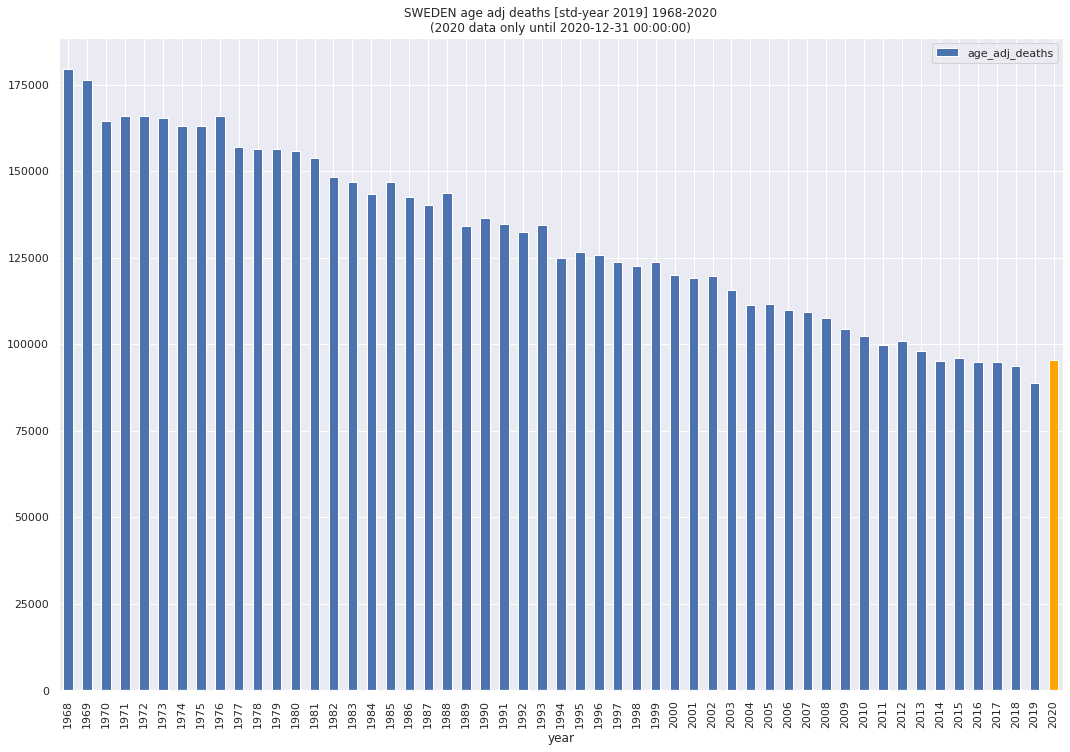

In [6303]:
colors = ['b'] * (nr_years -1) 
colors.extend(['orange'])
print (colors)

title = "SWEDEN age adj deaths [std-year 2019] 1968-2020\n(2020 data only until {})".format(df_age_2020.index[-1])

_= age_adj_deaths_inc_2020.plot(kind='bar',y='age_adj_deaths',figsize=(18,12),title=title,color=colors)

In [6304]:
# 2020 months reg at month end, rest month start
hist_deaths_ytd['rank'] = hist_deaths_ytd['dead'].rank(ascending=False)
hist_deaths_ytd

index         dead    rank
year                                
1851 1851-01-01  6261.000000  1318.5
1851 1851-02-01  6007.000000  1486.0
1851 1851-03-01  8812.000000    60.0
1851 1851-04-01  7818.000000   307.0
1851 1851-05-01  7406.000000   582.5
...         ...          ...     ...
2020 2020-08-31  6973.379770   919.0
2020 2020-09-30  6766.890475  1039.0
2020 2020-10-31  7246.644210   704.0
2020 2020-11-30  8222.588638   173.0
2020 2020-12-31  9362.902655    30.0

[2040 rows x 3 columns]

In [6305]:
hist_deaths_ytd.loc[hist_deaths_ytd['index'] == '2019-12-01']

index         dead   rank
year                               
2019 2019-12-01  7919.374672  273.0

In [6306]:
hist_deaths_ytd.sort_values('rank')[-50:]

index    dead    rank
year                           
1895 1895-08-01  4964.0  1991.0
1873 1873-09-01  4960.0  1992.0
1927 1927-08-01  4957.0  1993.0
1861 1861-08-01  4951.0  1994.0
1872 1872-06-01  4943.0  1995.0
1854 1854-06-01  4942.0  1996.0
1929 1929-09-01  4933.0  1997.0
1939 1939-09-01  4929.0  1998.0
1881 1881-09-01  4927.0  1999.0
1943 1943-08-01  4922.0  2000.0
1879 1879-09-01  4919.0  2001.0
1925 1925-08-01  4918.0  2002.0
1867 1867-08-01  4912.0  2003.0
1933 1933-08-01  4909.0  2004.0
1921 1921-09-01  4906.0  2005.0
1934 1934-09-01  4903.0  2006.0
1860 1860-06-01  4894.0  2007.0
1922 1922-09-01  4874.0  2008.0
1928 1928-09-01  4870.0  2009.5
1926 1926-09-01  4870.0  2009.5
1942 1942-07-01  4868.0  2011.0
1925 1925-09-01  4849.0  2012.0
1888 1888-09-01  4845.0  2013.0
1943 1943-09-01  4834.0  2014.5
1926 1926-08-01  4834.0  2014.5
1923 1923-08-01  4833.0  2016.5
1941 1941-08-01  4833.0  2016.5
1871 1871-07-01  4829.0  2018.0
1923 1923-09-01  4827.0  2019.0
1863 1863-09-01  4823.0  2020.0
1872 1872-09-01  4819.0  2021.0
1909 1909-09-01  4801.0  2022.0
1861 1861-07-01  4798.0  2023.0
1867 1867-09-01  4788.0  2024.0
1859 1859-07-01  4758.0  2025.0
1895 1895-09-01  4743.0  2026.0
1941 1941-09-01  4732.0  2027.0
1942 1942-08-01  4724.0  2028.0
1851 1851-10-01  4707.0  2029.0
1856 1856-08-01  4705.0  2030.0
1871 1871-09-01  4637.0  2031.0
1855 1855-07-01  4628.0  2032.0
1854 1854-07-01  4624.0  2033.0
1860 1860-09-01  4551.0  2034.0
1860 1860-08-01  4534.0  2035.0
1942 1942-09-01  4514.0  2036.0
1851 1851-08-01  4479.0  2037.0
1871 1871-08-01  4453.0  2038.0
1860 1860-07-01  4390.0  2039.0
1851 1851-09-01  4261.0  2040.0

In [6307]:
mortality_per_month['rank'] = mortality_per_month['mortality'].rank(ascending=True)
mortality_per_month

mortality  month    rank
index                               
1861-01-01   0.001873      1  1873.0
1861-02-01   0.001581      2  1742.0
1861-03-01   0.001775      3  1836.0
1861-04-01   0.001792      4  1845.0
1861-05-01   0.001836      5  1864.0
...               ...    ...     ...
2020-08-31   0.000675      8     5.0
2020-09-30   0.000655      9     2.0
2020-10-31   0.000702     10    20.0
2020-11-30   0.000796     11   219.0
2020-12-31   0.000907     12   814.0

[1920 rows x 3 columns]

In [6308]:
mortality_per_month.sort_values('rank',ascending=False)[:50]

mortality  month    rank
index                               
1918-10-01   0.002979     10  1920.0
1918-11-01   0.002862     11  1919.0
1869-03-01   0.002568      3  1918.0
1892-01-01   0.002384      1  1917.0
1890-01-01   0.002358      1  1916.0
1869-04-01   0.002354      4  1915.0
1864-01-01   0.002297      1  1914.0
1875-01-01   0.002272      1  1913.0
1869-05-01   0.002263      5  1912.0
1918-12-01   0.002249     12  1911.0
1894-01-01   0.002234      1  1910.0
1862-04-01   0.002211      4  1909.0
1869-01-01   0.002209      1  1908.0
1862-03-01   0.002162      3  1907.0
1867-03-01   0.002135      3  1906.0
1874-05-01   0.002118      5  1905.0
1863-03-01   0.002110      3  1904.0
1862-01-01   0.002108      1  1903.0
1868-12-01   0.002104     12  1902.0
1862-12-01   0.002069     12  1901.0
1875-03-01   0.002043      3  1900.0
1867-01-01   0.002031      1  1899.0
1870-03-01   0.002028      3  1898.0
1881-01-01   0.002022      1  1897.0
1870-02-01   0.002020      2  1896.0
1874-03-01   0.002018      3  1895.0
1892-02-01   0.002014      2  1894.0
1869-02-01   0.002003      2  1893.0
1876-12-01   0.001984     12  1892.0
1899-03-01   0.001979      3  1891.0
1867-12-01   0.001976     12  1890.0
1867-04-01   0.001966      4  1889.0
1876-01-01   0.001959      1  1888.0
1866-03-01   0.001957      3  1887.0
1874-12-01   0.001953     12  1886.0
1863-01-01   0.001949      1  1885.0
1875-12-01   0.001949     12  1884.0
1867-05-01   0.001933      5  1883.0
1877-01-01   0.001927      1  1882.0
1874-04-01   0.001925      4  1881.0
1864-03-01   0.001920      3  1880.0
1875-02-01   0.001917      2  1879.0
1870-04-01   0.001917      4  1878.0
1919-01-01   0.001892      1  1877.0
1875-04-01   0.001888      4  1876.0
1863-04-01   0.001883      4  1875.0
1864-05-01   0.001878      5  1874.0
1861-01-01   0.001873      1  1873.0
1862-02-01   0.001872      2  1872.0
1864-04-01   0.001865      4  1871.0

In [6309]:
mortality_per_month.sort_values('rank')[:50]

mortality  month  rank
index                             
2019-06-01   0.000650      6   1.0
2020-09-30   0.000655      9   2.0
2018-06-01   0.000660      6   3.0
2019-09-01   0.000672      9   4.0
2020-08-31   0.000675      8   5.0
2019-07-01   0.000681      7   6.0
2020-07-31   0.000681      7   7.0
2016-06-01   0.000682      6   8.0
2017-06-01   0.000685      6   9.0
2018-09-01   0.000689      9  10.0
2018-05-01   0.000689      5  11.0
2019-08-01   0.000689      8  12.0
2018-08-01   0.000691      8  13.0
2017-09-01   0.000693      9  14.0
2017-07-01   0.000695      7  15.0
2016-09-01   0.000699      9  16.0
2015-08-01   0.000700      8  17.0
2019-05-01   0.000701      5  18.0
2017-08-01   0.000701      8  19.0
2020-10-31   0.000702     10  20.0
2015-06-01   0.000703      6  21.0
2018-11-01   0.000704     11  22.0
1942-09-01   0.000705      9  23.0
1951-09-01   0.000705      9  24.0
2014-06-01   0.000707      6  25.0
2011-06-01   0.000713      6  26.0
1955-09-01   0.000713      9  27.0
2013-06-01   0.000716      6  28.0
2013-09-01   0.000716      9  29.0
2012-06-01   0.000716      6  30.0
2015-09-01   0.000719      9  31.0
2020-06-30   0.000720      6  32.0
1954-08-01   0.000721      8  33.0
1954-09-01   0.000722      9  34.0
2019-04-01   0.000723      4  35.0
1955-08-01   0.000724      8  36.0
2014-09-01   0.000725      9  37.0
2013-07-01   0.000725      7  38.0
2009-09-01   0.000726      9  39.0
2016-05-01   0.000726      5  40.0
2013-08-01   0.000726      8  41.0
2016-08-01   0.000728      8  42.0
1958-09-01   0.000728      9  43.0
2019-11-01   0.000729     11  44.0
1954-06-01   0.000730      6  45.0
2015-07-01   0.000731      7  46.0
2012-09-01   0.000732      9  47.0
1953-09-01   0.000732      9  48.0
2020-02-29   0.000733      2  49.0
2019-02-01   0.000734      2  50.0

In [6310]:
mortality_per_month.sort_values('rank',ascending=True)[:50]

mortality  month  rank
index                             
2019-06-01   0.000650      6   1.0
2020-09-30   0.000655      9   2.0
2018-06-01   0.000660      6   3.0
2019-09-01   0.000672      9   4.0
2020-08-31   0.000675      8   5.0
2019-07-01   0.000681      7   6.0
2020-07-31   0.000681      7   7.0
2016-06-01   0.000682      6   8.0
2017-06-01   0.000685      6   9.0
2018-09-01   0.000689      9  10.0
2018-05-01   0.000689      5  11.0
2019-08-01   0.000689      8  12.0
2018-08-01   0.000691      8  13.0
2017-09-01   0.000693      9  14.0
2017-07-01   0.000695      7  15.0
2016-09-01   0.000699      9  16.0
2015-08-01   0.000700      8  17.0
2019-05-01   0.000701      5  18.0
2017-08-01   0.000701      8  19.0
2020-10-31   0.000702     10  20.0
2015-06-01   0.000703      6  21.0
2018-11-01   0.000704     11  22.0
1942-09-01   0.000705      9  23.0
1951-09-01   0.000705      9  24.0
2014-06-01   0.000707      6  25.0
2011-06-01   0.000713      6  26.0
1955-09-01   0.000713      9  27.0
2013-06-01   0.000716      6  28.0
2013-09-01   0.000716      9  29.0
2012-06-01   0.000716      6  30.0
2015-09-01   0.000719      9  31.0
2020-06-30   0.000720      6  32.0
1954-08-01   0.000721      8  33.0
1954-09-01   0.000722      9  34.0
2019-04-01   0.000723      4  35.0
1955-08-01   0.000724      8  36.0
2014-09-01   0.000725      9  37.0
2013-07-01   0.000725      7  38.0
2009-09-01   0.000726      9  39.0
2016-05-01   0.000726      5  40.0
2013-08-01   0.000726      8  41.0
2016-08-01   0.000728      8  42.0
1958-09-01   0.000728      9  43.0
2019-11-01   0.000729     11  44.0
1954-06-01   0.000730      6  45.0
2015-07-01   0.000731      7  46.0
2012-09-01   0.000732      9  47.0
1953-09-01   0.000732      9  48.0
2020-02-29   0.000733      2  49.0
2019-02-01   0.000734      2  50.0

In [6311]:
mortality_per_month.index = mortality_per_month.index.date


In [6312]:
mortality_per_month[pd.DatetimeIndex(mortality_per_month.index).year == 2020]

mortality  month    rank
2020-01-31   0.000808      1   274.0
2020-02-29   0.000733      2    49.0
2020-03-31   0.000833      3   417.0
2020-04-30   0.001032      4  1129.0
2020-05-31   0.000866      5   614.0
2020-06-30   0.000720      6    32.0
2020-07-31   0.000681      7     7.0
2020-08-31   0.000675      8     5.0
2020-09-30   0.000655      9     2.0
2020-10-31   0.000702     10    20.0
2020-11-30   0.000796     11   219.0
2020-12-31   0.000907     12   814.0

In [6313]:
top_20 = mortality_per_month.sort_values('rank',ascending=True)[:20]
top_20

mortality  month  rank
2019-06-01   0.000650      6   1.0
2020-09-30   0.000655      9   2.0
2018-06-01   0.000660      6   3.0
2019-09-01   0.000672      9   4.0
2020-08-31   0.000675      8   5.0
2019-07-01   0.000681      7   6.0
2020-07-31   0.000681      7   7.0
2016-06-01   0.000682      6   8.0
2017-06-01   0.000685      6   9.0
2018-09-01   0.000689      9  10.0
2018-05-01   0.000689      5  11.0
2019-08-01   0.000689      8  12.0
2018-08-01   0.000691      8  13.0
2017-09-01   0.000693      9  14.0
2017-07-01   0.000695      7  15.0
2016-09-01   0.000699      9  16.0
2015-08-01   0.000700      8  17.0
2019-05-01   0.000701      5  18.0
2017-08-01   0.000701      8  19.0
2020-10-31   0.000702     10  20.0

In [6314]:
top_20_2020 = pd.DatetimeIndex(top_20.index).year == 2020
top_20_2020

array([False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [6315]:

colors = ['b' if not top_20_2020[i] else 'r' for i in range(len(top_20_2020))]
colors 

['b',
 'r',
 'b',
 'b',
 'r',
 'b',
 'r',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'r']

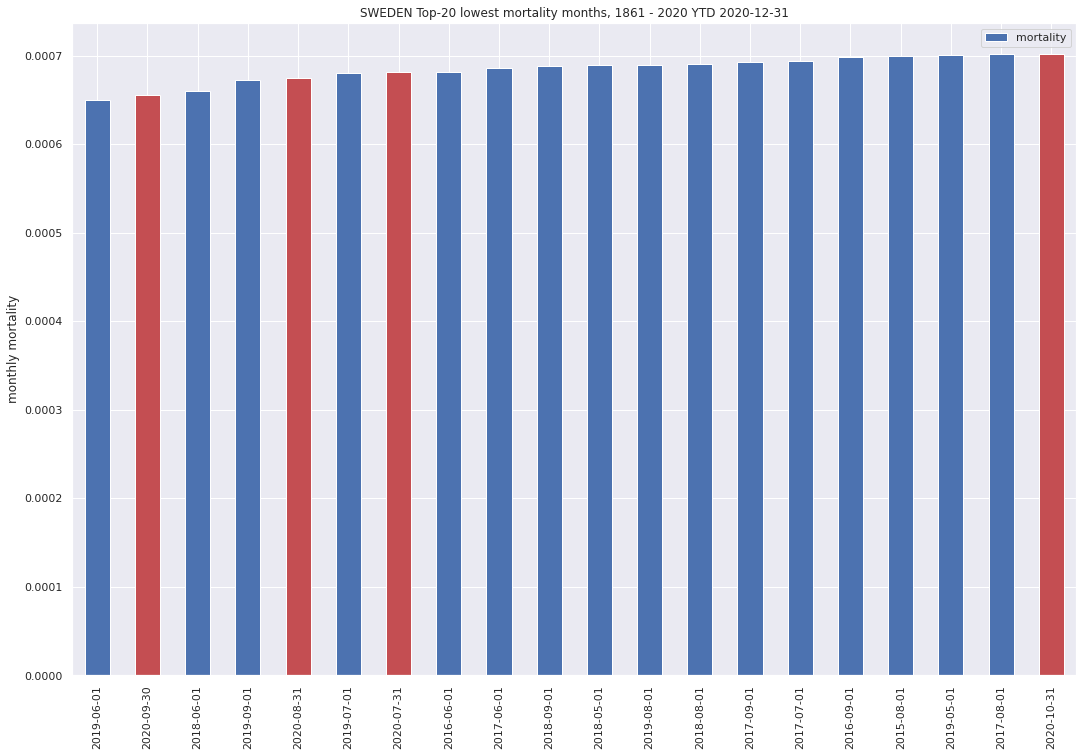

In [6316]:
title = 'SWEDEN Top-20 lowest mortality months, 1861 - 2020 YTD {}'.format(mortality_per_month.index[-1])

mortality_per_month.sort_values('rank',ascending=True)[:20].plot(figsize=(18,12),color=colors,
    kind='bar',y='mortality',title=title)

plt.ylabel('monthly mortality')
plt.savefig('swe_top_20_lowest_mortality_months.jpg',format='jpg')

In [6317]:
mortality_per_month

mortality  month    rank
1861-01-01   0.001873      1  1873.0
1861-02-01   0.001581      2  1742.0
1861-03-01   0.001775      3  1836.0
1861-04-01   0.001792      4  1845.0
1861-05-01   0.001836      5  1864.0
...               ...    ...     ...
2020-08-31   0.000675      8     5.0
2020-09-30   0.000655      9     2.0
2020-10-31   0.000702     10    20.0
2020-11-30   0.000796     11   219.0
2020-12-31   0.000907     12   814.0

[1920 rows x 3 columns]

In [6318]:
yearly_mortality

mortality  month
index                  
1861    0.018610     78
1862    0.021559     78
1863    0.019514     78
1864    0.020425     78
1865    0.019507     78
1866    0.020118     78
1867    0.019747     78
1868    0.020937     78
1869    0.022121     78
1870    0.019725     78
1871    0.017283     78
1872    0.016356     78
1873    0.017305     78
1874    0.020440     78
1875    0.020418     78
1876    0.019747     78
1877    0.018777     78
1878    0.018155     78
1879    0.017024     78
1880    0.018073     78
1881    0.017697     78
1882    0.017367     78
1883    0.017359     78
1884    0.017612     78
1885    0.017824     78
1886    0.016666     78
1887    0.016159     78
1888    0.016015     78
1889    0.016032     78
1890    0.017138     78
1891    0.016845     78
1892    0.017884     78
1893    0.016857     78
1894    0.016468     78
1895    0.015261     78
1896    0.015705     78
1897    0.015427     78
1898    0.015161     78
1899    0.017713     78
1900    0.016900     78
1901    0.016115     78
1902    0.015405     78
1903    0.015121     78
1904    0.015351     78
1905    0.015671     78
1906    0.014423     78
1907    0.014643     78
1908    0.014982     78
1909    0.013728     78
1910    0.014099     78
1911    0.013846     78
1912    0.014247     78
1913    0.013690     78
1914    0.013888     78
1915    0.014717     78
1916    0.013614     78
1917    0.013441     78
1918    0.018030     78
1919    0.014498     78
1920    0.013362     78
1921    0.012454     78
1922    0.012821     78
1923    0.011428     78
1924    0.011989     78
1925    0.011749     78
1926    0.011785     78
1927    0.012712     78
1928    0.012035     78
1929    0.012209     78
1930    0.011730     78
1931    0.012556     78
1932    0.011596     78
1933    0.011244     78
1934    0.011257     78
1935    0.011682     78
1936    0.011973     78
1937    0.012030     78
1938    0.011567     78
1939    0.011549     78
1940    0.011472     78
1941    0.011286     78
1942    0.009949     78
1943    0.010236     78
1944    0.011082     78
1945    0.010898     78
1946    0.010584     78
1947    0.010879     78
1948    0.009894     78
1949    0.010042     78
1950    0.010062     78
1951    0.009912     78
1952    0.009617     78
1953    0.009727     78
1954    0.009598     78
1955    0.009487     78
1956    0.009630     78
1957    0.009962     78
1958    0.009613     78
1959    0.009533     78
1960    0.010051     78
1961    0.009810     78
1962    0.010182     78
1963    0.010086     78
1964    0.010051     78
1965    0.010161     78
1966    0.010092     78
1967    0.010172     78
1968    0.010450     78
1969    0.010509     78
1970    0.009998     78
1971    0.010236     78
1972    0.010358     78
1973    0.010535     78
1974    0.010598     78
1975    0.010788     78
1976    0.011047     78
1977    0.010709     78
1978    0.010848     78
1979    0.010993     78
1980    0.011056     78
1981    0.011065     78
1982    0.010894     78
1983    0.010903     78
1984    0.010862     78
1985    0.011271     78
1986    0.011162     78
1987    0.011132     78
1988    0.011498     78
1989    0.010889     78
1990    0.011160     78
1991    0.011082     78
1992    0.010957     78
1993    0.011161     78
1994    0.010502     78
1995    0.010657     78
1996    0.010652     78
1997    0.010552     78
1998    0.010542     78
1999    0.010698     78
2000    0.010547     78
2001    0.010554     78
2002    0.010664     78
2003    0.010397     78
2004    0.010086     78
2005    0.010177     78
2006    0.010077     78
2007    0.010065     78
2008    0.009959     78
2009    0.009732     78
2010    0.009687     78
2011    0.009552     78
2012    0.009695     78
2013    0.009460     78
2014    0.009225     78
2015    0.009326     78
2016    0.009236     78
2017    0.009202     78
2018    0.009109     78
2019    0.008677     78
2020    0.009408     78

In [6319]:
age_adj_deaths

mortality   std_pop  age_adj_deaths  age_pop_adj_mortality
year                                                            
1968   7.910322  10327589   192447.503662               0.018634
1969   7.378283  10327589   188470.279907               0.018249
1970   6.742434  10327589   174723.843678               0.016918
1971   6.711811  10327589   175558.359079               0.016999
1972   7.161116  10327589   176400.120914               0.017080
1973   6.777326  10327589   175074.933125               0.016952
1974   6.794628  10327589   172565.464650               0.016709
1975   6.838526  10327589   173075.141733               0.016759
1976   7.038916  10327589   176096.825069               0.017051
1977   6.414906  10327589   166045.756978               0.016078
1978   6.411491  10327589   165000.826437               0.015977
1979   6.499791  10327589   164735.520590               0.015951
1980   6.548866  10327589   163566.919823               0.015838
1981   6.412136  10327589   161251.463836               0.015614
1982   6.119663  10327589   155104.027738               0.015018
1983   6.168865  10327589   153043.468160               0.014819
1984   5.963334  10327589   148838.131011               0.014412
1985   6.294339  10327589   152896.493230               0.014805
1986   6.008658  10327589   148523.779624               0.014381
1987   5.954834  10327589   145995.570115               0.014136
1988   6.399560  10327589   149786.681550               0.014504
1989   5.913057  10327589   139698.645873               0.013527
1990   6.018720  10327589   141937.667084               0.013744
1991   6.010575  10327589   139803.051162               0.013537
1992   5.904898  10327589   137107.046419               0.013276
1993   6.239817  10327589   139262.069774               0.013484
1994   5.580311  10327589   128748.975804               0.012467
1995   5.600896  10327589   129630.959035               0.012552
1996   5.803900  10327589   128619.113145               0.012454
1997   5.769938  10327589   125923.589515               0.012193
1998   5.482690  10327589   123719.086784               0.011979
1999   5.751007  10327589   124543.650838               0.012059
2000   5.578273  10327589   121273.220040               0.011743
2001   5.582049  10327589   120272.127814               0.011646
2002   5.705810  10327589   120960.661125               0.011712
2003   5.547367  10327589   116930.772565               0.011322
2004   5.262088  10327589   112150.065182               0.010859
2005   5.293151  10327589   112088.620658               0.010853
2006   5.316734  10327589   109970.149390               0.010648
2007   5.362980  10327589   109359.381971               0.010589
2008   5.302400  10327589   107636.158560               0.010422
2009   5.205486  10327589   104654.080882               0.010133
2010   5.084711  10327589   103606.357825               0.010032
2011   5.046269  10327589   101559.021788               0.009834
2012   5.261044  10327589   102799.024897               0.009954
2013   5.109698  10327589    99711.091169               0.009655
2014   4.937015  10327589    96443.580765               0.009338
2015   5.023273  10327589    97201.239201               0.009412
2016   4.916679  10327589    95710.225952               0.009267
2017   5.070704  10327589    95481.556967               0.009245
2018   4.958721  10327589    94190.305325               0.009120
2019   4.597594  10327589    88766.000000               0.008595

In [6320]:
yearly_mortality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 1861 to 2020
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mortality  160 non-null    float64
 1   month      160 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 8.8 KB


In [6321]:
age_adj_deaths.index = range(1968,2020)
age_adj_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 1968 to 2019
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mortality              52 non-null     float64
 1   std_pop                52 non-null     int64  
 2   age_adj_deaths         52 non-null     float64
 3   age_pop_adj_mortality  52 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.8 KB


In [6322]:
yearly_mortality['age_pop_adj_mortality'] = age_adj_deaths['age_pop_adj_mortality']
yearly_mortality

mortality  month  age_pop_adj_mortality
index                                         
1861    0.018610     78                    NaN
1862    0.021559     78                    NaN
1863    0.019514     78                    NaN
1864    0.020425     78                    NaN
1865    0.019507     78                    NaN
1866    0.020118     78                    NaN
1867    0.019747     78                    NaN
1868    0.020937     78                    NaN
1869    0.022121     78                    NaN
1870    0.019725     78                    NaN
1871    0.017283     78                    NaN
1872    0.016356     78                    NaN
1873    0.017305     78                    NaN
1874    0.020440     78                    NaN
1875    0.020418     78                    NaN
1876    0.019747     78                    NaN
1877    0.018777     78                    NaN
1878    0.018155     78                    NaN
1879    0.017024     78                    NaN
1880    0.018073     78                    NaN
1881    0.017697     78                    NaN
1882    0.017367     78                    NaN
1883    0.017359     78                    NaN
1884    0.017612     78                    NaN
1885    0.017824     78                    NaN
1886    0.016666     78                    NaN
1887    0.016159     78                    NaN
1888    0.016015     78                    NaN
1889    0.016032     78                    NaN
1890    0.017138     78                    NaN
1891    0.016845     78                    NaN
1892    0.017884     78                    NaN
1893    0.016857     78                    NaN
1894    0.016468     78                    NaN
1895    0.015261     78                    NaN
1896    0.015705     78                    NaN
1897    0.015427     78                    NaN
1898    0.015161     78                    NaN
1899    0.017713     78                    NaN
1900    0.016900     78                    NaN
1901    0.016115     78                    NaN
1902    0.015405     78                    NaN
1903    0.015121     78                    NaN
1904    0.015351     78                    NaN
1905    0.015671     78                    NaN
1906    0.014423     78                    NaN
1907    0.014643     78                    NaN
1908    0.014982     78                    NaN
1909    0.013728     78                    NaN
1910    0.014099     78                    NaN
1911    0.013846     78                    NaN
1912    0.014247     78                    NaN
1913    0.013690     78                    NaN
1914    0.013888     78                    NaN
1915    0.014717     78                    NaN
1916    0.013614     78                    NaN
1917    0.013441     78                    NaN
1918    0.018030     78                    NaN
1919    0.014498     78                    NaN
1920    0.013362     78                    NaN
1921    0.012454     78                    NaN
1922    0.012821     78                    NaN
1923    0.011428     78                    NaN
1924    0.011989     78                    NaN
1925    0.011749     78                    NaN
1926    0.011785     78                    NaN
1927    0.012712     78                    NaN
1928    0.012035     78                    NaN
1929    0.012209     78                    NaN
1930    0.011730     78                    NaN
1931    0.012556     78                    NaN
1932    0.011596     78                    NaN
1933    0.011244     78                    NaN
1934    0.011257     78                    NaN
1935    0.011682     78                    NaN
1936    0.011973     78                    NaN
1937    0.012030     78                    NaN
1938    0.011567     78                    NaN
1939    0.011549     78                    NaN
1940    0.011472     78                    NaN
1941    0.011286     78                    NaN
1942    0.009949     78                    NaN
1943    0.010236     78                    NaN
1944    0.01

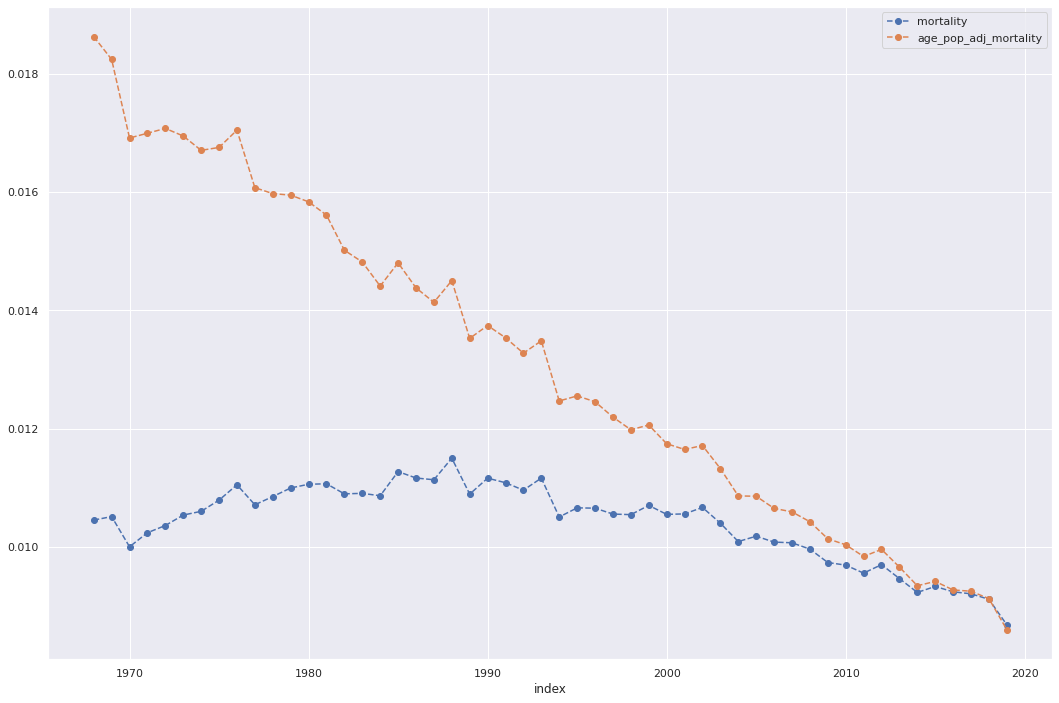

In [6323]:
title = 'SWEDEN mortality 1968 - 2019 : comparison mortality vs age adj mortality'
ax = yearly_mortality.dropna().plot(y=['mortality','age_pop_adj_mortality'],figsize=(18,12),
                              style=['o--','o--'])

In [6324]:
age_adj_deaths_inc_2020['age_pop_adj_mortality'] = age_adj_deaths_inc_2020['age_adj_deaths'] /\
age_adj_deaths_inc_2020['std_pop']

age_adj_deaths_inc_2020


std_pop  age_adj_deaths  age_pop_adj_mortality
year                                                   
1968  10327589.0   179497.390656               0.017380
1969  10327589.0   176436.404632               0.017084
1970  10327589.0   164381.466825               0.015917
1971  10327589.0   165827.214032               0.016057
1972  10327589.0   166072.657659               0.016080
1973  10327589.0   165269.437608               0.016003
1974  10327589.0   162919.430970               0.015775
1975  10327589.0   162991.476655               0.015782
1976  10327589.0   165927.041036               0.016066
1977  10327589.0   156856.656517               0.015188
1978  10327589.0   156328.985278               0.015137
1979  10327589.0   156519.977762               0.015156
1980  10327589.0   155714.042148               0.015077
1981  10327589.0   153713.410833               0.014884
1982  10327589.0   148324.674355               0.014362
1983  10327589.0   146762.929789               0.014211
1984  10327589.0   143375.794716               0.013883
1985  10327589.0   146887.523576               0.014223
1986  10327589.0   142572.676919               0.013805
1987  10327589.0   140182.827195               0.013574
1988  10327589.0   143764.523017               0.013920
1989  10327589.0   134234.539891               0.012998
1990  10327589.0   136393.169075               0.013207
1991  10327589.0   134754.873660               0.013048
1992  10327589.0   132309.272712               0.012811
1993  10327589.0   134580.083584               0.013031
1994  10327589.0   124951.463592               0.012099
1995  10327589.0   126529.565550               0.012252
1996  10327589.0   125853.103092               0.012186
1997  10327589.0   123652.865585               0.011973
1998  10327589.0   122458.285182               0.011857
1999  10327589.0   123738.706465               0.011981
2000  10327589.0   120116.200630               0.011631
2001  10327589.0   119079.395268               0.011530
2002  10327589.0   119767.680655               0.011597
2003  10327589.0   115786.660422               0.011211
2004  10327589.0   111283.031360               0.010775
2005  10327589.0   111677.655041               0.010814
2006  10327589.0   109854.257228               0.010637
2007  10327589.0   109317.461930               0.010585
2008  10327589.0   107533.585289               0.010412
2009  10327589.0   104284.636757               0.010098
2010  10327589.0   102398.894311               0.009915
2011  10327589.0    99845.224898               0.009668
2012  10327589.0   100887.918828               0.009769
2013  10327589.0    97991.493460               0.009488
2014  10327589.0    95140.288998               0.009212
2015  10327589.0    96067.742883               0.009302
2016  10327589.0    94972.137863               0.009196
2017  10327589.0    94954.079413               0.009194
2018  10327589.0    93815.014335               0.009084
2019  10327589.0    88766.000000               0.008595
2020  10327589.0    95462.907904               0.009243

In [6325]:
age_adj_deaths_inc_2020.index = range(1968,2021)

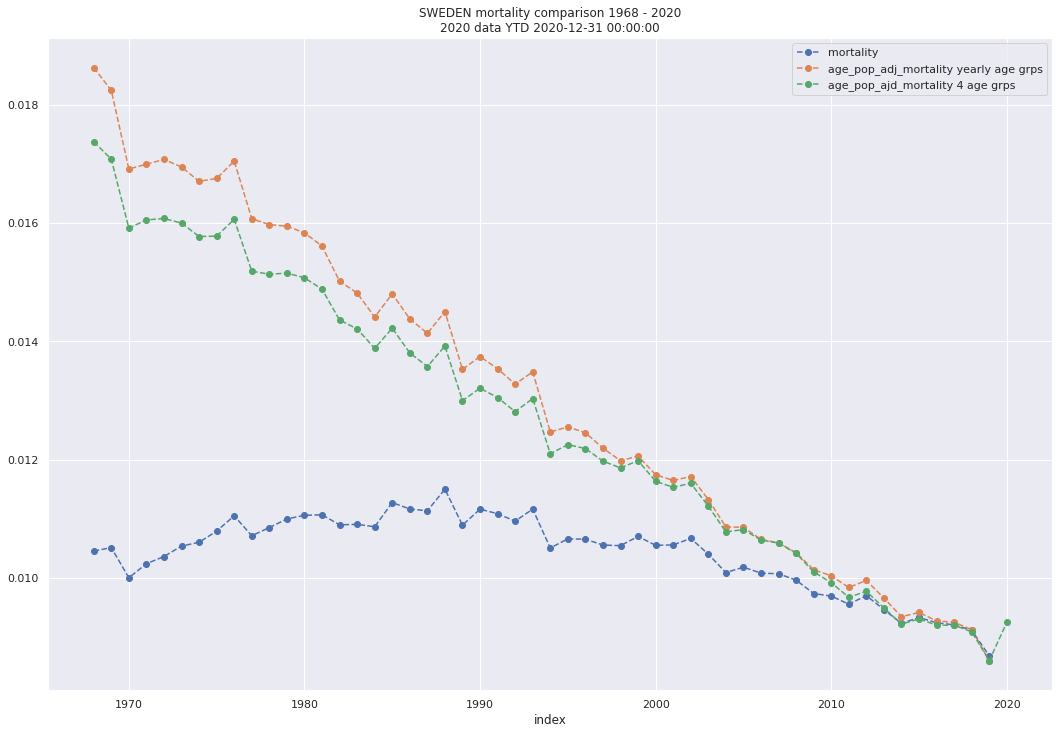

In [6326]:
title = 'SWEDEN mortality comparison 1968 - 2020\n2020 data YTD {}'.format(df_age_2020.index[-1])

ax = yearly_mortality.dropna().plot(y=['mortality','age_pop_adj_mortality'],figsize=(18,12),
                              style=['o--','o--'],title=title,
                                    label=['mortality','age_pop_adj_mortality yearly age grps'])

ax.plot(age_adj_deaths_inc_2020['age_pop_adj_mortality'],'o--',
        label='age_pop_ajd_mortality 4 age grps')
ax.legend(loc='upper right')

In [6327]:
age_adj_deaths_inc_2020

std_pop  age_adj_deaths  age_pop_adj_mortality
1968  10327589.0   179497.390656               0.017380
1969  10327589.0   176436.404632               0.017084
1970  10327589.0   164381.466825               0.015917
1971  10327589.0   165827.214032               0.016057
1972  10327589.0   166072.657659               0.016080
1973  10327589.0   165269.437608               0.016003
1974  10327589.0   162919.430970               0.015775
1975  10327589.0   162991.476655               0.015782
1976  10327589.0   165927.041036               0.016066
1977  10327589.0   156856.656517               0.015188
1978  10327589.0   156328.985278               0.015137
1979  10327589.0   156519.977762               0.015156
1980  10327589.0   155714.042148               0.015077
1981  10327589.0   153713.410833               0.014884
1982  10327589.0   148324.674355               0.014362
1983  10327589.0   146762.929789               0.014211
1984  10327589.0   143375.794716               0.013883
1985  10327589.0   146887.523576               0.014223
1986  10327589.0   142572.676919               0.013805
1987  10327589.0   140182.827195               0.013574
1988  10327589.0   143764.523017               0.013920
1989  10327589.0   134234.539891               0.012998
1990  10327589.0   136393.169075               0.013207
1991  10327589.0   134754.873660               0.013048
1992  10327589.0   132309.272712               0.012811
1993  10327589.0   134580.083584               0.013031
1994  10327589.0   124951.463592               0.012099
1995  10327589.0   126529.565550               0.012252
1996  10327589.0   125853.103092               0.012186
1997  10327589.0   123652.865585               0.011973
1998  10327589.0   122458.285182               0.011857
1999  10327589.0   123738.706465               0.011981
2000  10327589.0   120116.200630               0.011631
2001  10327589.0   119079.395268               0.011530
2002  10327589.0   119767.680655               0.011597
2003  10327589.0   115786.660422               0.011211
2004  10327589.0   111283.031360               0.010775
2005  10327589.0   111677.655041               0.010814
2006  10327589.0   109854.257228               0.010637
2007  10327589.0   109317.461930               0.010585
2008  10327589.0   107533.585289               0.010412
2009  10327589.0   104284.636757               0.010098
2010  10327589.0   102398.894311               0.009915
2011  10327589.0    99845.224898               0.009668
2012  10327589.0   100887.918828               0.009769
2013  10327589.0    97991.493460               0.009488
2014  10327589.0    95140.288998               0.009212
2015  10327589.0    96067.742883               0.009302
2016  10327589.0    94972.137863               0.009196
2017  10327589.0    94954.079413               0.009194
2018  10327589.0    93815.014335               0.009084
2019  10327589.0    88766.000000               0.008595
2020  10327589.0    95462.907904               0.009243

In [6328]:
df_age_2020.tail()

0-64       65-79      80-89        90+
2020-12-27  20.889090   82.273520  96.116756  72.346024
2020-12-28  31.883348   82.273520  89.034468  78.374859
2020-12-29  16.491387   63.527655  97.128511  84.403694
2020-12-30  36.281051  101.019386  89.034468  84.403694
2020-12-31  32.982773   72.900588  98.140266  57.273935

['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange']


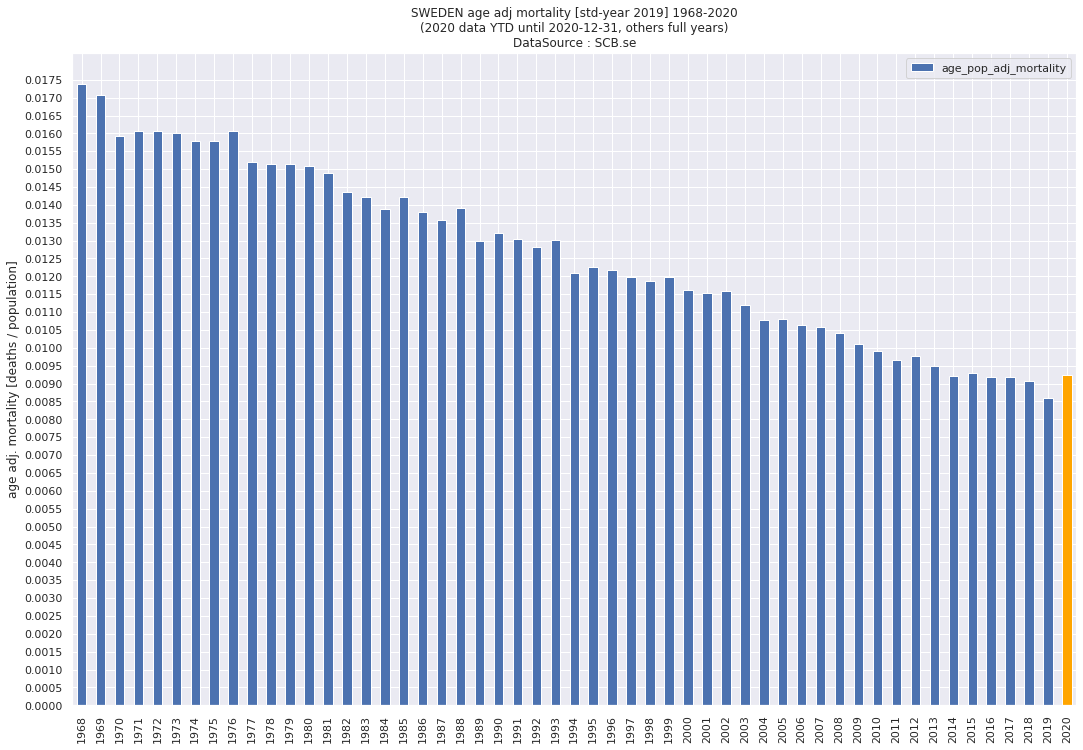

In [6329]:
colors = ['b'] * (nr_years -1) 
colors.extend(['orange'])
print (colors)

title = "SWEDEN age adj mortality [std-year 2019] \
1968-2020\n(2020 data YTD until {}, others full years)\nDataSource : SCB.se".format(df_age_2020.index[-1].date())

_= age_adj_deaths_inc_2020.plot(kind='bar',y='age_pop_adj_mortality',figsize=(18,12),title=title,color=colors)
plt.yticks(np.arange(0,0.018,0.0005))
plt.ylabel('age adj. mortality [deaths / population]')
plt.savefig('swe_age_adj_mortality_1968_2020_YTD.jpg',format='jpg')

In [6330]:
year = hist_deaths_ytd['index']
month = year.dt.month

hist_deaths_ytd.rename(columns={'index' : 'month'},inplace=True)

In [6331]:
hist_deaths_ytd.set_index('month',inplace=True)
hist_deaths_ytd

dead    rank
month                          
1851-01-01  6261.000000  1318.5
1851-02-01  6007.000000  1486.0
1851-03-01  8812.000000    60.0
1851-04-01  7818.000000   307.0
1851-05-01  7406.000000   582.5
...                 ...     ...
2020-08-31  6973.379770   919.0
2020-09-30  6766.890475  1039.0
2020-10-31  7246.644210   704.0
2020-11-30  8222.588638   173.0
2020-12-31  9362.902655    30.0

[2040 rows x 2 columns]

In [6332]:
hist_cum_deaths = hist_deaths_ytd.groupby(hist_deaths_ytd.index.get_level_values(0).year).cumsum()
hist_cum_deaths

dead    rank
month                           
1851-01-01   6261.000000  1318.5
1851-02-01  12268.000000  2804.5
1851-03-01  21080.000000  2864.5
1851-04-01  28898.000000  3171.5
1851-05-01  36304.000000  3754.0
...                  ...     ...
2020-08-31  65564.974022  3060.0
2020-09-30  72331.864497  4099.0
2020-10-31  79578.508707  4803.0
2020-11-30  87801.097345  4976.0
2020-12-31  97164.000000  5006.0

[2040 rows x 2 columns]

In [6333]:
deaths_year_month = hist_deaths_ytd.reset_index()

In [6334]:
deaths_year_month.rename(columns={'month': 'date'},inplace=True)
deaths_year_month

date         dead    rank
0    1851-01-01  6261.000000  1318.5
1    1851-02-01  6007.000000  1486.0
2    1851-03-01  8812.000000    60.0
3    1851-04-01  7818.000000   307.0
4    1851-05-01  7406.000000   582.5
...         ...          ...     ...
2035 2020-08-31  6973.379770   919.0
2036 2020-09-30  6766.890475  1039.0
2037 2020-10-31  7246.644210   704.0
2038 2020-11-30  8222.588638   173.0
2039 2020-12-31  9362.902655    30.0

[2040 rows x 3 columns]

In [6335]:
deaths_year_month['year'] = deaths_year_month['date'].apply(lambda d : d.year)
deaths_year_month['month'] = deaths_year_month['date'].apply(lambda d : d.month)

In [6336]:
deaths_year_month

date         dead    rank  year  month
0    1851-01-01  6261.000000  1318.5  1851      1
1    1851-02-01  6007.000000  1486.0  1851      2
2    1851-03-01  8812.000000    60.0  1851      3
3    1851-04-01  7818.000000   307.0  1851      4
4    1851-05-01  7406.000000   582.5  1851      5
...         ...          ...     ...   ...    ...
2035 2020-08-31  6973.379770   919.0  2020      8
2036 2020-09-30  6766.890475  1039.0  2020      9
2037 2020-10-31  7246.644210   704.0  2020     10
2038 2020-11-30  8222.588638   173.0  2020     11
2039 2020-12-31  9362.902655    30.0  2020     12

[2040 rows x 5 columns]

In [6337]:
deaths_year_month_ranked = deaths_year_month.sort_values('rank',ascending=True)
deaths_year_month_ranked

date     dead    rank  year  month
813  1918-10-01  17278.0     1.0  1918     10
814  1918-11-01  16600.0     2.0  1918     11
80   1857-09-01  15116.0     3.0  1857      9
815  1918-12-01  13045.0     4.0  1918     12
492  1892-01-01  11448.0     5.0  1892      1
...         ...      ...     ...   ...    ...
1100 1942-09-01   4514.0  2036.0  1942      9
7    1851-08-01   4479.0  2037.0  1851      8
247  1871-08-01   4453.0  2038.0  1871      8
114  1860-07-01   4390.0  2039.0  1860      7
8    1851-09-01   4261.0  2040.0  1851      9

[2040 rows x 5 columns]

In [6338]:
month_grps = deaths_year_month_ranked.groupby('month')
nov = month_grps.get_group(11)
nov = nov.sort_values('dead',ascending=False)
nov['nov_rank'] = range(1,len(nov) + 1)
nov

date          dead    rank  year  month  nov_rank
814  1918-11-01  16600.000000     2.0  1918     11         1
2038 2020-11-30   8222.588638   173.0  2020     11         2
1714 1993-11-01   7915.990818   274.0  1993     11         3
1654 1988-11-01   7905.338941   277.0  1988     11         4
310  1876-11-01   7904.000000   278.0  1876     11         5
1678 1990-11-01   7894.259548   279.0  1990     11         6
1690 1991-11-01   7883.223488   288.0  1991     11         7
1774 1998-11-01   7876.400706   289.0  1998     11         8
1822 2002-11-01   7752.721546   335.0  2002     11         9
1702 1992-11-01   7751.214867   337.0  1992     11        10
1810 2001-11-01   7739.590070   340.0  2001     11        11
1738 1995-11-01   7738.888010   341.0  1995     11        12
1618 1985-11-01   7707.967599   358.0  1985     11        13
1786 1999-11-01   7654.545131   388.0  1999     11        14
1870 2006-11-01   7635.314927   402.0  2006     11        15
1750 1996-11-01   7569.950338   428.0  1996     11        16
1990 2016-11-01   7565.466540   431.0  2016     11        17
82   1857-11-01   7552.000000   447.0  1857     11        18
1726 1994-11-01   7540.518744   454.0  1994     11        19
1546 1979-11-01   7520.789575   473.0  1979     11        20
214  1868-11-01   7505.282121   487.0  1868     11        21
2002 2017-11-01   7498.060518   495.0  2017     11        22
1882 2007-11-01   7487.264076   503.0  2007     11        23
1798 2000-11-01   7479.651357   507.0  2000     11        24
1570 1981-11-01   7476.417596   511.0  1981     11        25
1846 2004-11-01   7463.524494   519.0  2004     11        26
1666 1989-11-01   7462.314317   520.0  1989     11        27
2026 2019-11-01   7460.018847   524.0  2019     11        28
1642 1987-11-01   7456.146294   528.0  1987     11        29
1918 2010-11-01   7453.706796   535.0  2010     11        30
1894 2008-11-01   7452.126816   538.0  2008     11        31
358  1880-11-01   7444.000000   546.0  1880     11        32
1834 2003-11-01   7420.125203   566.0  2003     11        33
298  1875-11-01   7408.000000   581.0  1875     11        34
1906 2009-11-01   7395.852379   590.0  2009     11        35
1522 1977-11-01   7372.346410   608.0  1977     11        36
1558 1980-11-01   7355.807717   617.0  1980     11        37
1978 2015-11-01   7350.357877   624.0  2015     11        38
1582 1982-11-01   7317.730155   647.0  1982     11        39
1534 1978-11-01   7317.345315   648.0  1978     11        40
1942 2012-11-01   7297.746290   666.0  2012     11        41
1630 1986-11-01   7295.585313   667.0  1986     11        42
826  1919-11-01   7289.000000   676.0  1919     11        43
1606 1984-11-01   7282.082250   678.0  1984     11        44
1966 2014-11-01   7253.793556   698.0  2014     11        45
1954 2013-11-01   7239.601646   709.0  2013     11        46
1762 1997-11-01   7218.180458   729.0  1997     11        47
1594 1983-11-01   7212.719904   735.0  1983     11        48
1930 2011-11-01   7195.160069   749.0  2011     11        49
1474 1973-11-01   7192.083980   751.0  1973     11        50
1510 1976-11-01   7191.172214   752.0  1976     11        51
70   1856-11-01   7167.000000   775.5  1856     11        52
22   1852-11-01   7160.000000   780.0  1852     11        53
1858 2005-11-01   7159.080805   781.0  2005     11        54
166  1864-11-01   7124.000000   804.0  1864     11        55
2014 2018-11-01   7121.157641   806.0  2018     11        56
1498 1975-11-01   7090.803873   825.0  1975     11        57
286  1874-11-01   7030.000000   869.5  1874     11        58
226  1869-11-01   6973.000000   920.0  1869     11        59
142  1862-11-01   6971.000000   923.5  1862     11        60
1450 1971-11-01   6969.337021   927.0  1971     11        61
382  1882-11-01   6959.000000   932.0  1882     11        62
418  1885-11-01   6894.000000   966.5  1885     11        63
1486 1974-11-01   6866.159094   979.0  1974     11        64
1462 1972-11-01   6863.000000   982.0  1972   

In [6339]:
mort_mont_grps = mortality_per_month.groupby('month')
mort_nov = mort_mont_grps.get_group(11)
mort_nov = mort_nov.sort_values('mortality',ascending=False)
mort_nov.index = pd.DatetimeIndex(mort_nov.index)
mort_nov['nov_rank'] = range(1,len(mort_nov) + 1)
mort_nov

mortality  month    rank  nov_rank
1918-11-01   0.002862     11  1919.0         1
1876-11-01   0.001808     11  1852.0         2
1868-11-01   0.001790     11  1841.0         3
1862-11-01   0.001782     11  1839.0         4
1864-11-01   0.001776     11  1837.0         5
1875-11-01   0.001710     11  1811.0         6
1869-11-01   0.001663     11  1782.0         7
1866-11-01   0.001644     11  1770.0         8
1874-11-01   0.001637     11  1765.0         9
1880-11-01   0.001626     11  1759.0        10
1867-11-01   0.001579     11  1741.0        11
1865-11-01   0.001579     11  1740.0        12
1861-11-01   0.001556     11  1724.0        13
1882-11-01   0.001522     11  1699.0        14
1873-11-01   0.001504     11  1691.0        15
1885-11-01   0.001484     11  1673.0        16
1863-11-01   0.001484     11  1672.0        17
1884-11-01   0.001476     11  1667.0        18
1870-11-01   0.001468     11  1656.0        19
1877-11-01   0.001467     11  1655.0        20
1878-11-01   0.001465     11  1652.0        21
1879-11-01   0.001439     11  1628.0        22
1871-11-01   0.001412     11  1602.0        23
1881-11-01   0.001391     11  1588.0        24
1888-11-01   0.001380     11  1578.0        25
1883-11-01   0.001369     11  1569.0        26
1887-11-01   0.001363     11  1562.0        27
1893-11-01   0.001358     11  1558.0        28
1896-11-01   0.001343     11  1541.0        29
1890-11-01   0.001322     11  1524.0        30
1886-11-01   0.001318     11  1514.0        31
1892-11-01   0.001316     11  1513.0        32
1872-11-01   0.001315     11  1511.0        33
1891-11-01   0.001297     11  1487.0        34
1901-11-01   0.001280     11  1469.0        35
1904-11-01   0.001258     11  1442.0        36
1894-11-01   0.001258     11  1441.0        37
1919-11-01   0.001254     11  1435.0        38
1899-11-01   0.001243     11  1424.0        39
1889-11-01   0.001231     11  1407.0        40
1895-11-01   0.001225     11  1401.0        41
1898-11-01   0.001223     11  1398.0        42
1908-11-01   0.001217     11  1385.0        43
1902-11-01   0.001202     11  1374.0        44
1910-11-01   0.001195     11  1365.0        45
1905-11-01   0.001193     11  1364.0        46
1897-11-01   0.001192     11  1363.0        47
1900-11-01   0.001191     11  1360.0        48
1903-11-01   0.001147     11  1311.0        49
1912-11-01   0.001146     11  1310.0        50
1907-11-01   0.001127     11  1281.0        51
1906-11-01   0.001119     11  1276.0        52
1915-11-01   0.001119     11  1275.0        53
1909-11-01   0.001082     11  1217.0        54
1914-11-01   0.001079     11  1211.0        55
1911-11-01   0.001062     11  1186.0        56
1920-11-01   0.001017     11  1102.0        57
1916-11-01   0.001016     11  1101.0        58
1913-11-01   0.001004     11  1075.0        59
1921-11-01   0.001001     11  1072.0        60
1922-11-01   0.000999     11  1070.0        61
1917-11-01   0.000977     11  1024.0        62
1930-11-01   0.000949     11   965.0        63
1988-11-01   0.000940     11   939.0        64
1924-11-01   0.000938     11   935.0        65
1927-11-01   0.000935     11   923.0        66
1937-11-01   0.000931     11   906.0        67
1990-11-01   0.000926     11   881.0        68
1985-11-01   0.000924     11   875.0        69
1923-11-01   0.000919     11   858.0        70
1991-11-01   0.000918     11   853.0        71
1928-11-01   0.000917     11   851.0        72
1993-11-01   0.000911     11   825.0        73
1936-11-01   0.000909     11   821.0        74
1979-11-01   0.000908     11   819.0        75
1944-11-01   0.000907     11   816.0        76
1931-11-01   0.000900     11   796.0        77
1926-11-01   0.000899     11   794.0        78
1981-11-01   0.000899     11   791.0        79
1932-11-01   0.000898     11   789.0        80
1925-11-01   0.000898     11   788.0        81
1935-11-01   0.000897     11   783.0        82
1992-11-01   0.000897     11   780.0        83
1977-11-01   0.000895     11   772.0        84
1998-11-01   0.00

In [6340]:
pd.options.display.max_rows = 999
mort_nov

mortality  month    rank  nov_rank
1918-11-01   0.002862     11  1919.0         1
1876-11-01   0.001808     11  1852.0         2
1868-11-01   0.001790     11  1841.0         3
1862-11-01   0.001782     11  1839.0         4
1864-11-01   0.001776     11  1837.0         5
1875-11-01   0.001710     11  1811.0         6
1869-11-01   0.001663     11  1782.0         7
1866-11-01   0.001644     11  1770.0         8
1874-11-01   0.001637     11  1765.0         9
1880-11-01   0.001626     11  1759.0        10
1867-11-01   0.001579     11  1741.0        11
1865-11-01   0.001579     11  1740.0        12
1861-11-01   0.001556     11  1724.0        13
1882-11-01   0.001522     11  1699.0        14
1873-11-01   0.001504     11  1691.0        15
1885-11-01   0.001484     11  1673.0        16
1863-11-01   0.001484     11  1672.0        17
1884-11-01   0.001476     11  1667.0        18
1870-11-01   0.001468     11  1656.0        19
1877-11-01   0.001467     11  1655.0        20
1878-11-01   0.001465     11  1652.0        21
1879-11-01   0.001439     11  1628.0        22
1871-11-01   0.001412     11  1602.0        23
1881-11-01   0.001391     11  1588.0        24
1888-11-01   0.001380     11  1578.0        25
1883-11-01   0.001369     11  1569.0        26
1887-11-01   0.001363     11  1562.0        27
1893-11-01   0.001358     11  1558.0        28
1896-11-01   0.001343     11  1541.0        29
1890-11-01   0.001322     11  1524.0        30
1886-11-01   0.001318     11  1514.0        31
1892-11-01   0.001316     11  1513.0        32
1872-11-01   0.001315     11  1511.0        33
1891-11-01   0.001297     11  1487.0        34
1901-11-01   0.001280     11  1469.0        35
1904-11-01   0.001258     11  1442.0        36
1894-11-01   0.001258     11  1441.0        37
1919-11-01   0.001254     11  1435.0        38
1899-11-01   0.001243     11  1424.0        39
1889-11-01   0.001231     11  1407.0        40
1895-11-01   0.001225     11  1401.0        41
1898-11-01   0.001223     11  1398.0        42
1908-11-01   0.001217     11  1385.0        43
1902-11-01   0.001202     11  1374.0        44
1910-11-01   0.001195     11  1365.0        45
1905-11-01   0.001193     11  1364.0        46
1897-11-01   0.001192     11  1363.0        47
1900-11-01   0.001191     11  1360.0        48
1903-11-01   0.001147     11  1311.0        49
1912-11-01   0.001146     11  1310.0        50
1907-11-01   0.001127     11  1281.0        51
1906-11-01   0.001119     11  1276.0        52
1915-11-01   0.001119     11  1275.0        53
1909-11-01   0.001082     11  1217.0        54
1914-11-01   0.001079     11  1211.0        55
1911-11-01   0.001062     11  1186.0        56
1920-11-01   0.001017     11  1102.0        57
1916-11-01   0.001016     11  1101.0        58
1913-11-01   0.001004     11  1075.0        59
1921-11-01   0.001001     11  1072.0        60
1922-11-01   0.000999     11  1070.0        61
1917-11-01   0.000977     11  1024.0        62
1930-11-01   0.000949     11   965.0        63
1988-11-01   0.000940     11   939.0        64
1924-11-01   0.000938     11   935.0        65
1927-11-01   0.000935     11   923.0        66
1937-11-01   0.000931     11   906.0        67
1990-11-01   0.000926     11   881.0        68
1985-11-01   0.000924     11   875.0        69
1923-11-01   0.000919     11   858.0        70
1991-11-01   0.000918     11   853.0        71
1928-11-01   0.000917     11   851.0        72
1993-11-01   0.000911     11   825.0        73
1936-11-01   0.000909     11   821.0        74
1979-11-01   0.000908     11   819.0        75
1944-11-01   0.000907     11   816.0        76
1931-11-01   0.000900     11   796.0        77
1926-11-01   0.000899     11   794.0        78
1981-11-01   0.000899     11   791.0        79
1932-11-01   0.000898     11   789.0        80
1925-11-01   0.000898     11   788.0        81
1935-11-01   0.000897     11   783.0        82
1992-11-01   0.000897     11   780.0        83
1977-11-01   0.000895     11   772.0        84
1998-11-01   0.00

In [6341]:
mort_nov.loc['2020-11-30']

mortality  month   rank  nov_rank
2020-11-30   0.000796     11  219.0       140

In [6342]:
idx = mort_nov.index
idx = idx.strftime('%Y-%m-%d')
mort_nov.index = idx




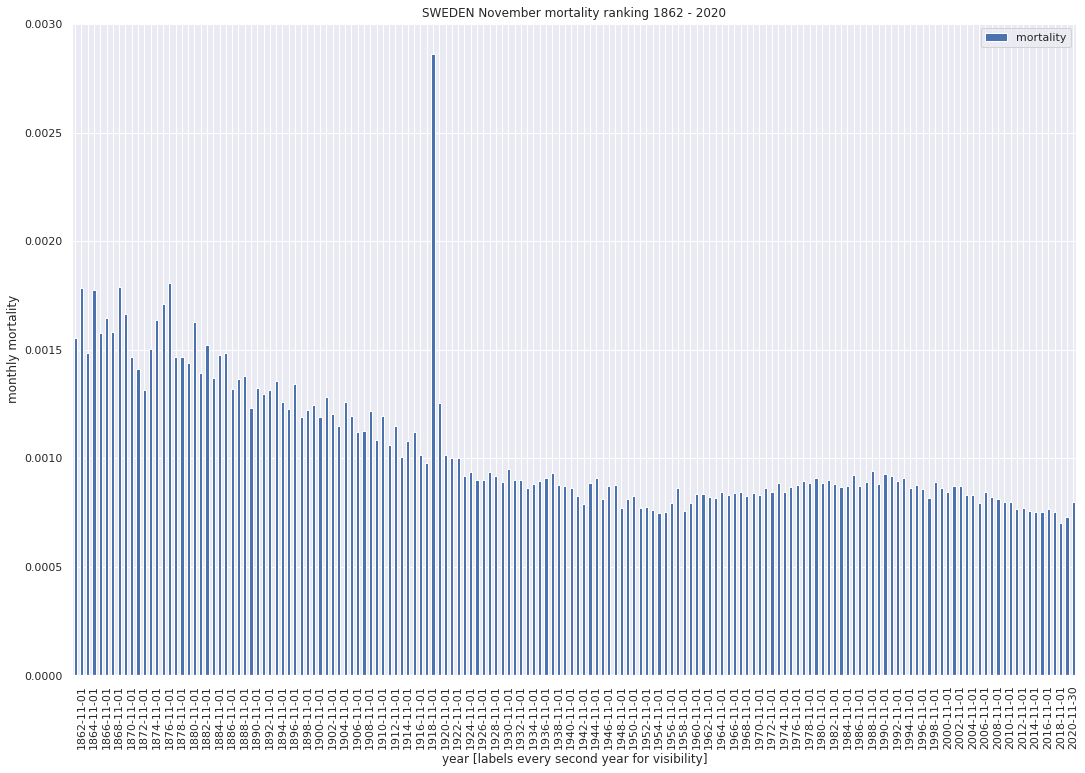

In [6343]:
title = 'SWEDEN November mortality ranking 1862 - 2020'
ax = mort_nov.sort_index().plot(kind='bar',figsize=(18,12),y='mortality',title=title)

for label in ax.xaxis.get_ticklabels()[0::2]:
        label.set_visible(False)
        
plt.ylabel('monthly mortality')
plt.xlabel('year [labels every second year for visibility]')
plt.savefig('swe_nov_mortality_1862_2020.jpg',format='jpg')

In [6344]:
deaths_year_month = deaths_year_month.pivot(index='year',columns='month',values='dead')

In [6345]:
deaths_year_month

month            1            2             3             4            5   \
year                                                                        
1851    6261.000000  6007.000000   8812.000000   7818.000000  7406.000000   
1852    6563.000000  6937.000000   8026.000000   8399.000000  7844.000000   
1853    7011.000000  8191.000000   8777.000000   7471.000000  6559.000000   
1854    6086.000000  5336.000000   6355.000000   6808.000000  6251.000000   
1855    6633.000000  7819.000000   7684.000000   6841.000000  7025.000000   
1856    7105.000000  6971.000000   8011.000000   8307.000000  7978.000000   
1857    8249.000000  7412.000000   7930.000000   7887.000000  7862.000000   
1858    8780.000000  7196.000000   8660.000000   8176.000000  7154.000000   
1859    7013.000000  6309.000000   7854.000000   7608.000000  7044.000000   
1860    5963.000000  6109.000000   6619.000000   6326.000000  6104.000000   
1861    7228.000000  6104.000000   6852.000000   6917.000000  7085.000000   
1862    8247.000000  7324.000000   8457.000000   8650.000000  7228.000000   
1863    7715.000000  7267.000000   8350.000000   7452.000000  7001.000000   
1864    9216.000000  7079.000000   7701.000000   7480.000000  7533.000000   
1865    7291.034860  7299.062424   7261.934941   7038.166599  6686.960681   
1866    6836.000000  6657.000000   8041.000000   7411.000000  7436.000000   
1867    8443.000000  6762.000000   8872.000000   8171.000000  8036.000000   
1868    7515.283830  6868.173285   7413.266402   7674.310996  7515.283830   
1869    9264.000000  8400.000000  10772.000000   9873.000000  9491.000000   
1870    7676.000000  8442.000000   8477.000000   8014.000000  7352.000000   
1871    7473.000000  6992.000000   6193.000000   6674.000000  7105.000000   
1872    6129.000000  6130.000000   7062.000000   6406.000000  5811.000000   
1873    6200.000000  6144.000000   6834.000000   6926.000000  7343.000000   
1874    7553.000000  7506.000000   8663.000000   8267.000000  9092.000000   
1875    9839.000000  8305.000000   8850.000000   8179.000000  7811.000000   
1876    8565.000000  7514.000000   7645.000000   7506.000000  7973.000000   
1877    8534.000000  7080.000000   8081.000000   7575.000000  8022.000000   
1878    7769.000000  6793.000000   7539.000000   7547.000000  7575.000000   
1879    7334.000000  6669.000000   6960.000000   7510.000000  7431.000000   
1880    7105.000000  7190.000000   7452.000000   7714.000000  7602.000000   
1881    9233.000000  7665.000000   8179.000000   7643.000000  7608.000000   
1882    6698.000000  6656.000000   7028.000000   7378.000000  6964.000000   
1883    7543.000000  6769.000000   8288.000000   7975.000000  7579.000000   
1884    7218.000000  6764.000000   7635.000000   7764.000000  7820.000000   
1885    8245.000000  7033.000000   8026.000000   8084.000000  7891.000000   
1886    7393.000000  6278.000000   7850.000000   6859.000000  7242.000000   
1887    7365.000000  6295.000000   7420.000000   7030.000000  6709.000000   
1888    7214.000000  6941.000000   7763.000000   6690.000000  6639.000000   
1889    6888.000000  6713.000000   7168.000000   6946.000000  6710.000000   
1890   11256.000000  7270.000000   8202.000000   7020.000000  6751.000000   
1891    8291.000000  6442.000000   7687.000000   8031.000000  8065.000000   
1892   11448.000000  9673.000000   8779.000000   7538.000000  7219.000000   
1893    8339.000000  7322.000000   7461.000000   7061.000000  7439.000000   
1894   10777.000000  7156.000000   7221.000000   6657.000000  6529.000000   
1895    7306.000000  7290.000000   7036.000000   7253.000000  6537.000000   
1896    6859.000000  6407.000000   7342.000000   7125.000000  7001.000000   
1897    7665.000000  7173.000000   7416.000000   7317.000000  6758.000000   
1898    6819.000000  6317.000000   7082.000000   7031.000000  7104.000000   
1899    8307.000000  8438.000000  10018.000000   8633.000000  8085.000000   
1900    7866.000000  7692.000000   8451.000000   9432.000000  9349.000000

In [6346]:
sns.axes_style()

{'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'white',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

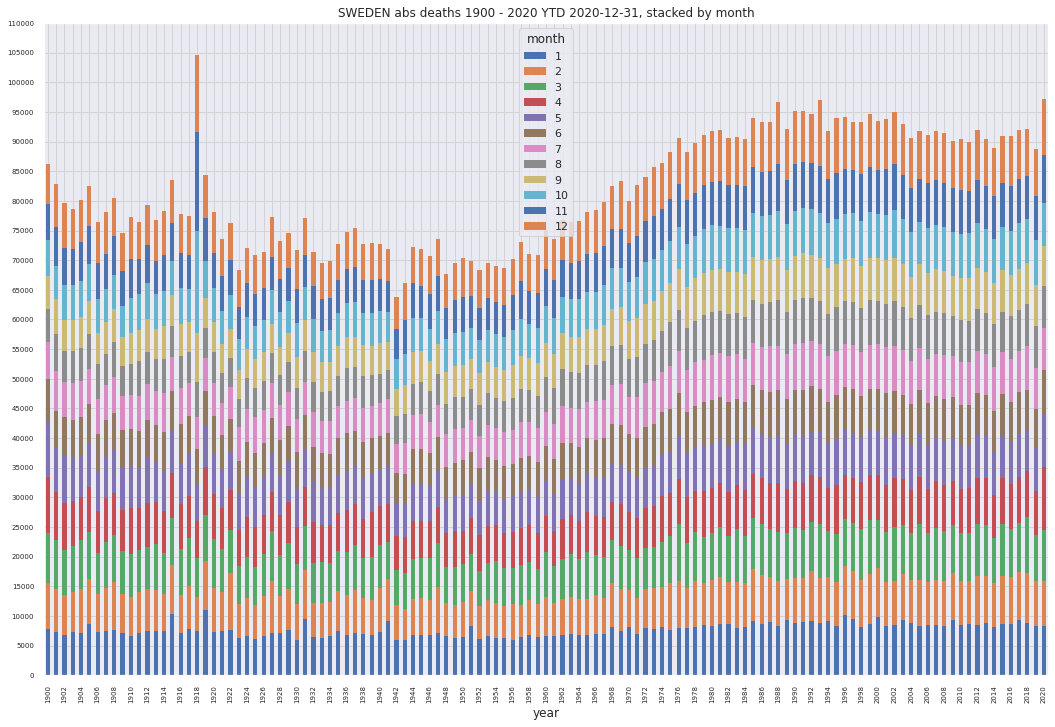

In [6400]:
start_year = 1900
sns.set()
sns.set_style({"grid.color": "lightgrey"})
title = 'SWEDEN abs deaths {} - 2020 YTD {}, stacked by month'.format(start_year,df_age_2020.index[-1].date())
deaths_year_month.loc[start_year:].plot(kind='bar',stacked=True,title=title,
                                        figsize=(18,12),edgecolor='none',fontsize=7)
ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

_= plt.yticks(range(0,115000,5000))
plt.savefig('swe_deaths_stacked_by_month_1860_2020_ytd.jpg',format='jpg')


In [6348]:
full_mortality_per_month['year'] = pd.DatetimeIndex(full_mortality_per_month.index).year
full_mortality_per_month

mortality  month  year
index                             
1861-01-01   0.001873      1  1861
1861-02-01   0.001581      2  1861
1861-03-01   0.001775      3  1861
1861-04-01   0.001792      4  1861
1861-05-01   0.001836      5  1861
...               ...    ...   ...
2020-08-31   0.000675      8  2020
2020-09-30   0.000655      9  2020
2020-10-31   0.000702     10  2020
2020-11-30   0.000796     11  2020
2020-12-31   0.000907     12  2020

[1920 rows x 3 columns]

In [6349]:
full_mortality_year_month = full_mortality_per_month.pivot(index='year',columns='month',values='mortality')
full_mortality_year_month

month        1         2         3         4         5         6         7   \
year                                                                          
1861   0.001873  0.001581  0.001775  0.001792  0.001836  0.001354  0.001243   
1862   0.002108  0.001872  0.002162  0.002211  0.001847  0.001543  0.001530   
1863   0.001949  0.001836  0.002110  0.001883  0.001769  0.001532  0.001368   
1864   0.002297  0.001765  0.001920  0.001865  0.001878  0.001534  0.001381   
1865   0.001795  0.001797  0.001788  0.001733  0.001647  0.001492  0.001499   
1866   0.001664  0.001620  0.001957  0.001804  0.001810  0.001489  0.001432   
1867   0.002031  0.001627  0.002135  0.001966  0.001933  0.001571  0.001323   
1868   0.001792  0.001638  0.001768  0.001830  0.001792  0.001476  0.001617   
1869   0.002209  0.002003  0.002568  0.002354  0.002263  0.001819  0.001470   
1870   0.001836  0.002020  0.002028  0.001917  0.001759  0.001572  0.001346   
1871   0.001793  0.001677  0.001486  0.001601  0.001704  0.001372  0.001158   
1872   0.001457  0.001457  0.001679  0.001523  0.001381  0.001175  0.001290   
1873   0.001459  0.001446  0.001608  0.001630  0.001728  0.001321  0.001243   
1874   0.001759  0.001748  0.002018  0.001925  0.002118  0.001733  0.001565   
1875   0.002272  0.001917  0.002043  0.001888  0.001803  0.001444  0.001351   
1876   0.001959  0.001719  0.001749  0.001717  0.001824  0.001499  0.001376   
1877   0.001927  0.001598  0.001824  0.001710  0.001811  0.001489  0.001367   
1878   0.001732  0.001515  0.001681  0.001683  0.001689  0.001442  0.001371   
1879   0.001618  0.001472  0.001536  0.001657  0.001640  0.001280  0.001232   
1880   0.001552  0.001570  0.001627  0.001685  0.001660  0.001392  0.001280   
1881   0.002022  0.001679  0.001791  0.001674  0.001666  0.001334  0.001182   
1882   0.001465  0.001456  0.001537  0.001614  0.001523  0.001301  0.001298   
1883   0.001647  0.001478  0.001810  0.001742  0.001655  0.001365  0.001264   
1884   0.001568  0.001469  0.001658  0.001687  0.001699  0.001365  0.001267   
1885   0.001775  0.001514  0.001728  0.001741  0.001699  0.001427  0.001247   
1886   0.001579  0.001341  0.001676  0.001465  0.001547  0.001272  0.001263   
1887   0.001561  0.001334  0.001573  0.001490  0.001422  0.001296  0.001199   
1888   0.001524  0.001466  0.001640  0.001413  0.001402  0.001280  0.001158   
1889   0.001451  0.001414  0.001510  0.001463  0.001413  0.001247  0.001313   
1890   0.002358  0.001523  0.001718  0.001470  0.001414  0.001210  0.001136   
1891   0.001733  0.001346  0.001606  0.001678  0.001685  0.001423  0.001246   
1892   0.002384  0.002014  0.001828  0.001570  0.001503  0.001219  0.001176   
1893   0.001735  0.001523  0.001552  0.001469  0.001548  0.001268  0.001225   
1894   0.002234  0.001483  0.001497  0.001380  0.001353  0.001255  0.001152   
1895   0.001499  0.001496  0.001444  0.001488  0.001341  0.001201  0.001088   
1896   0.001394  0.001302  0.001493  0.001448  0.001423  0.001280  0.001176   
1897   0.001545  0.001445  0.001494  0.001474  0.001362  0.001221  0.001095   
1898   0.001361  0.001261  0.001414  0.001403  0.001418  0.001228  0.001130   
1899   0.001641  0.001667  0.001979  0.001705  0.001597  0.001363  0.001371   
1900   0.001543  0.001509  0.001658  0.001850  0.001834  0.001406  0.001217   
1901   0.001422  0.001397  0.001626  0.001584  0.001430  0.001220  0.001316   
1902   0.001298  0.001307  0.001492  0.001524  0.001542  0.001256  0.001141   
1903   0.001420  0.001295  0.001474  0.001457  0.001411  0.001239  0.001170   
1904   0.001379  0.001422  0.001564  0.001386  0.001347  0.001242  0.001154   
1905   0.001634  0.001439  0.001506  0.001455  0.001413  0.001237  0.001146   
1906   0.001393  0.001195  0.001319  0.001325  0.001288  0.001171  0.001111   
1907   0.001415  0.001343  0.001454  0.001376  0.001313  0.001174  0.001091   
1908   0.001424  0.001491  0.001480  0.001320  0.001345  0.001168  0.001131   
1909   0.001305  0.001218  0.001350  0.001262  0.0

In [6350]:
full_mortality_year_month.sum(axis=1)

year
1861    0.018610
1862    0.021559
1863    0.019514
1864    0.020425
1865    0.019507
1866    0.020118
1867    0.019747
1868    0.020937
1869    0.022121
1870    0.019725
1871    0.017283
1872    0.016356
1873    0.017305
1874    0.020440
1875    0.020418
1876    0.019747
1877    0.018777
1878    0.018155
1879    0.017024
1880    0.018073
1881    0.017697
1882    0.017367
1883    0.017359
1884    0.017612
1885    0.017824
1886    0.016666
1887    0.016159
1888    0.016015
1889    0.016032
1890    0.017138
1891    0.016845
1892    0.017884
1893    0.016857
1894    0.016468
1895    0.015261
1896    0.015705
1897    0.015427
1898    0.015161
1899    0.017713
1900    0.016900
1901    0.016115
1902    0.015405
1903    0.015121
1904    0.015351
1905    0.015671
1906    0.014423
1907    0.014643
1908    0.014982
1909    0.013728
1910    0.014099
1911    0.013846
1912    0.014247
1913    0.013690
1914    0.013888
1915    0.014717
1916    0.013614
1917    0.013441
1918    0.018030
1919    0

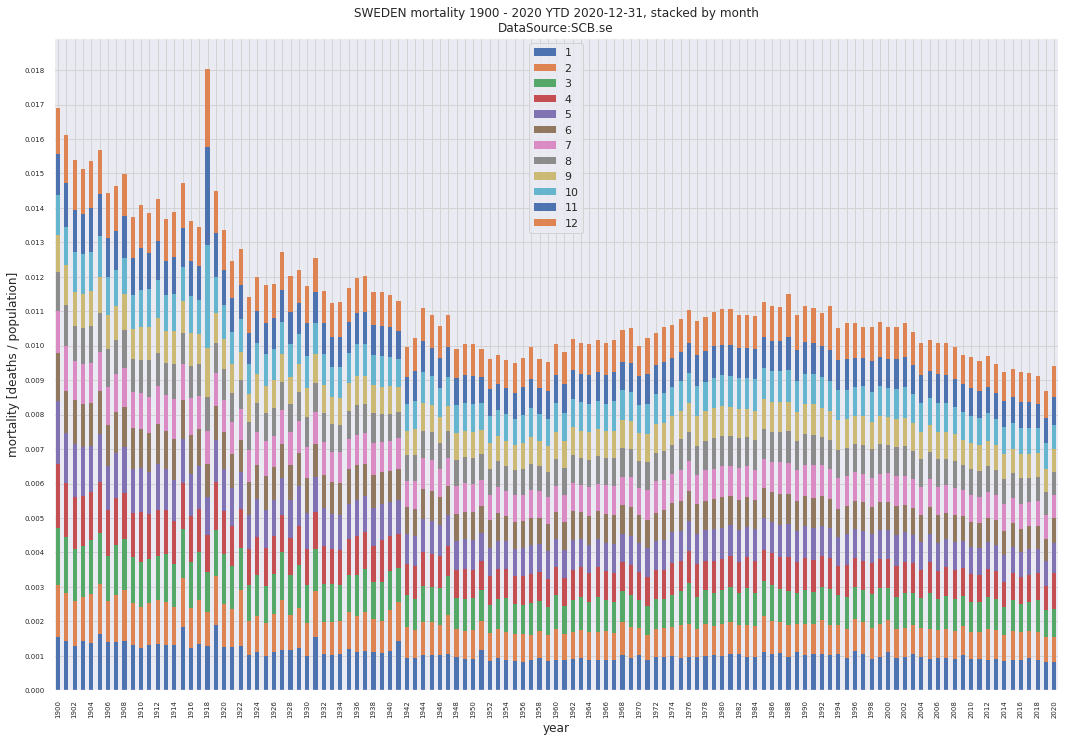

In [6351]:
title = 'SWEDEN mortality {} - 2020 YTD {}, stacked by month\nDataSource:SCB.se'.format(start_year,
                                                                                        df_age_2020.index[-1].date())

full_mortality_year_month.loc[start_year:].plot(kind='bar',
    stacked=True,figsize=(18,12),edgecolor='none',title=title,fontsize=7)

ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

_= plt.yticks(np.arange(0,0.019,0.001))
plt.legend(loc='upper center')
plt.ylabel('mortality [deaths / population]')
plt.savefig('swe_spot_the_pandemic.jpg',format='jpg')

In [6352]:
yearly_mortality.loc[linreg_start_year:]

mortality  month  age_pop_adj_mortality
index                                         
2010    0.009687     78               0.010032
2011    0.009552     78               0.009834
2012    0.009695     78               0.009954
2013    0.009460     78               0.009655
2014    0.009225     78               0.009338
2015    0.009326     78               0.009412
2016    0.009236     78               0.009267
2017    0.009202     78               0.009245
2018    0.009109     78               0.009120
2019    0.008677     78               0.008595
2020    0.009408     78                    NaN

In [6353]:
yearly_mortality = full_mortality_year_month.sum(axis=1)
yearly_mortality = yearly_mortality.loc[linreg_start_year:]
yearly_mortality

year
2010    0.009687
2011    0.009552
2012    0.009695
2013    0.009460
2014    0.009225
2015    0.009326
2016    0.009236
2017    0.009202
2018    0.009109
2019    0.008677
2020    0.009408
dtype: float64

In [6354]:
mortality_growth = yearly_mortality / yearly_mortality.shift()
mortality_growth = pd.DataFrame(mortality_growth,columns=['growth'])
mortality_growth['hue'] = np.random.randint(0,2,size=len(mortality_growth))
mortality_growth

growth  hue
year               
2010       NaN    0
2011  0.986027    1
2012  1.014984    0
2013  0.975778    1
2014  0.975147    0
2015  1.010960    0
2016  0.990293    0
2017  0.996304    1
2018  0.989927    0
2019  0.952563    1
2020  1.084285    0

In [6355]:
mean_growth = mortality_growth['growth'].mean()
mean_growth

0.9976267589586094

In [6356]:
mortality_growth['growth_vs_avg'] = mortality_growth['growth'] / mean_growth
mortality_growth

growth  hue  growth_vs_avg
year                              
2010       NaN    0            NaN
2011  0.986027    1       0.988373
2012  1.014984    0       1.017399
2013  0.975778    1       0.978099
2014  0.975147    0       0.977467
2015  1.010960    0       1.013364
2016  0.990293    0       0.992649
2017  0.996304    1       0.998674
2018  0.989927    0       0.992282
2019  0.952563    1       0.954829
2020  1.084285    0       1.086864

<AxesSubplot:xlabel='year'>

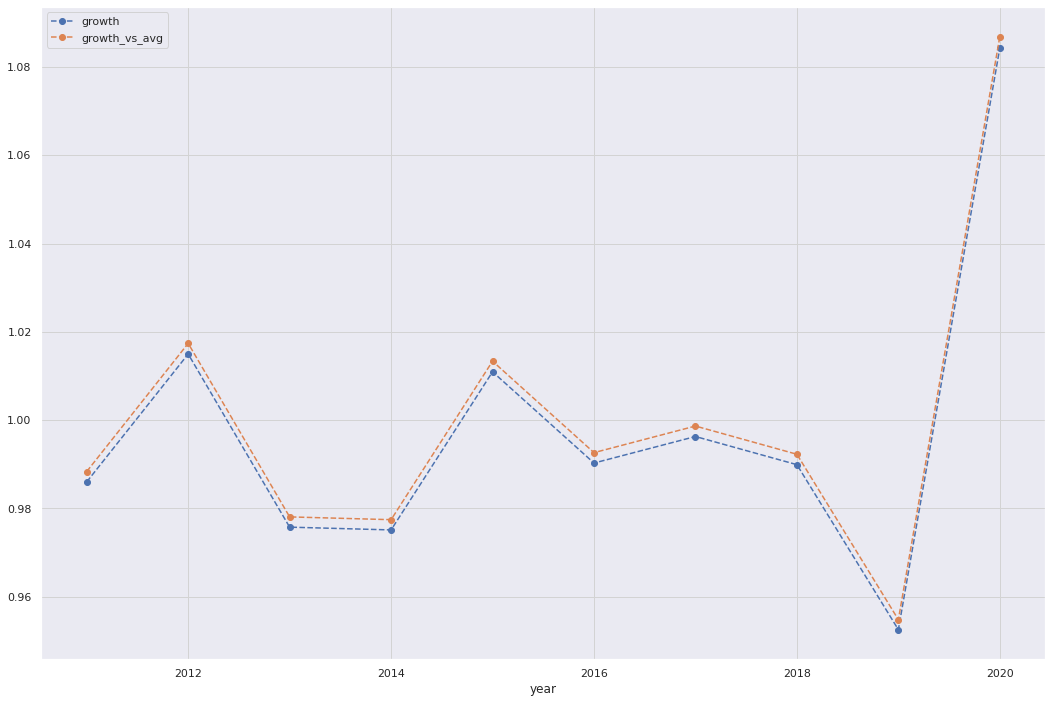

In [6357]:
mortality_growth.plot(style='o--',y=['growth','growth_vs_avg'],figsize=(18,12))

Text(0, 0.5, 'growth factor Y2Y')

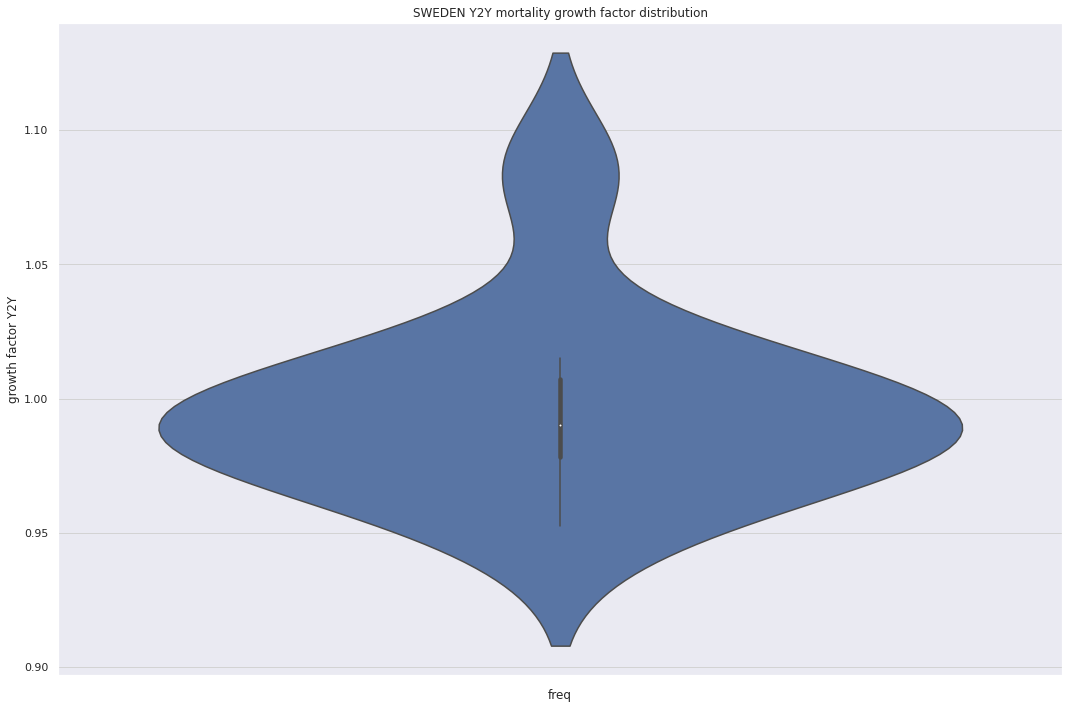

In [6358]:
plt.figure(figsize=(18,12))
sns.violinplot(data=mortality_growth,y='growth',inner='box')
plt.title('SWEDEN Y2Y mortality growth factor distribution')
plt.xlabel('freq')
plt.ylabel('growth factor Y2Y')

<AxesSubplot:xlabel='year'>

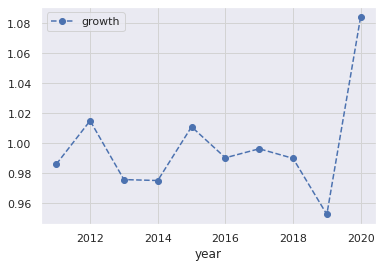

In [6359]:


mortality_growth.plot(y='growth',style='o--')

<AxesSubplot:ylabel='Frequency'>

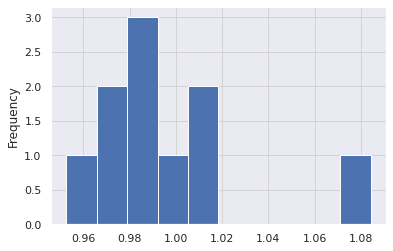

In [6360]:
mortality_growth.dropna(inplace=True)

mortality_growth['growth'].plot(kind='hist')


In [6361]:
mortality_growth['growth'] 

year
2011    0.986027
2012    1.014984
2013    0.975778
2014    0.975147
2015    1.010960
2016    0.990293
2017    0.996304
2018    0.989927
2019    0.952563
2020    1.084285
Name: growth, dtype: float64

In [6362]:
mortality_growth

growth  hue  growth_vs_avg
year                              
2011  0.986027    1       0.988373
2012  1.014984    0       1.017399
2013  0.975778    1       0.978099
2014  0.975147    0       0.977467
2015  1.010960    0       1.013364
2016  0.990293    0       0.992649
2017  0.996304    1       0.998674
2018  0.989927    0       0.992282
2019  0.952563    1       0.954829
2020  1.084285    0       1.086864

<AxesSubplot:xlabel='year'>

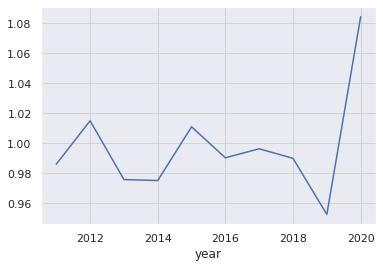

In [6363]:
mortality_growth['growth'].plot()

In [6364]:
import pymc3 as pm
import arviz as az

model = pm.Model()
with model:
    x = range(len(mortality_growth))
    
    alpha = pm.Normal('alpha',mu=1,sd=1)
    beta = pm.Normal('beta',mu=0,sd=1)
    sigma = pm.Normal('sigma',1,3)
    
    reg = pm.Deterministic('reg', alpha + x * beta)
    
    obs = pm.Normal('obs',mu=reg,sd=sigma,observed=mortality_growth['growth'])
    
    trace = pm.sample(500,tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.


         mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha   0.983  0.026     0.936      1.021      0.001    0.001     391.0   
beta    0.003  0.005    -0.003      0.012      0.000    0.000     338.0   
sigma   0.043  0.014     0.025      0.059      0.001    0.001     292.0   
reg[0]  0.983  0.026     0.936      1.021      0.001    0.001     391.0   
reg[1]  0.986  0.022     0.947      1.019      0.001    0.001     422.0   
reg[2]  0.989  0.019     0.955      1.014      0.001    0.001     482.0   
reg[3]  0.993  0.016     0.966      1.016      0.001    0.000     617.0   
reg[4]  0.996  0.015     0.972      1.016      0.000    0.000     905.0   
reg[5]  0.999  0.014     0.976      1.019      0.000    0.000    1108.0   
reg[6]  1.003  0.016     0.980      1.030      0.000    0.000    1067.0   
reg[7]  1.006  0.018     0.978      1.037      0.001    0.000     741.0   
reg[8]  1.009  0.022     0.977      1.046      0.001    0.001     551.0   
reg[9]  1.012  0.026     

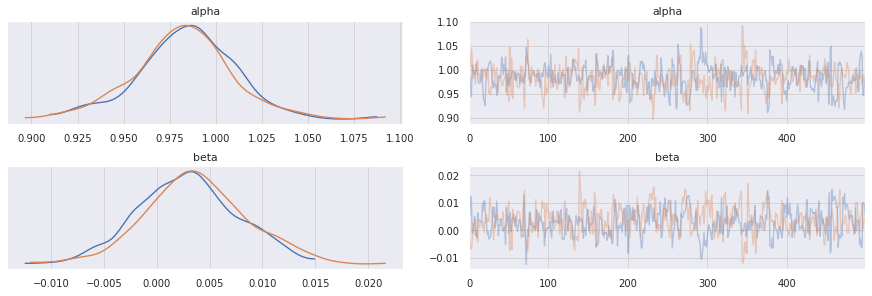

In [6365]:
with model:
    print (pm.summary(trace,hdi_prob=0.89))
    az.plot_trace(trace,var_names=['alpha','beta'])

In [6366]:
trace['reg']

array([[0.97557677, 0.98304424, 0.99051171, ..., 1.02784906, 1.03531653,
        1.042784  ],
       [0.98563258, 0.99129252, 0.99695246, ..., 1.02525214, 1.03091208,
        1.03657202],
       [0.9621629 , 0.97468472, 0.98720654, ..., 1.04981563, 1.06233745,
        1.07485926],
       ...,
       [0.98905012, 0.99046431, 0.99187851, ..., 0.99894947, 1.00036366,
        1.00177785],
       [0.97728282, 0.98147544, 0.98566806, ..., 1.00663115, 1.01082377,
        1.01501639],
       [0.98522205, 0.98810702, 0.99099199, ..., 1.00541684, 1.00830181,
        1.01118678]])

In [6367]:
total_pop = pop_df.groupby(['year'])['pop'].sum()
total_pop['2020'] = 10378483 # scb november population, updated dec 2020
total_pop

year
1860     3859728
1861     3912498
1862     3957501
1863     4011652
1864     4060806
1865     4108964
1866     4156245
1867     4193830
1868     4194051
1869     4180029
1870     4168525
1871     4206465
1872     4248826
1873     4293477
1874     4331345
1875     4372029
1876     4429713
1877     4484542
1878     4531863
1879     4578901
1880     4565668
1881     4572245
1882     4579115
1883     4603595
1884     4644448
1885     4682769
1886     4717189
1887     4734901
1888     4748257
1889     4774409
1890     4784981
1891     4802751
1892     4806865
1893     4824150
1894     4873183
1895     4919260
1896     4962568
1897     5009632
1898     5062918
1899     5097402
1900     5136441
1901     5175228
1902     5198752
1903     5221291
1904     5260811
1905     5294885
1906     5337055
1907     5377713
1908     5429600
1909     5476441
1910     5522403
1911     5561799
1912     5604192
1913     5638583
1914     5679607
1915     5712740
1916     5757566
1917     5800847
1918     

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


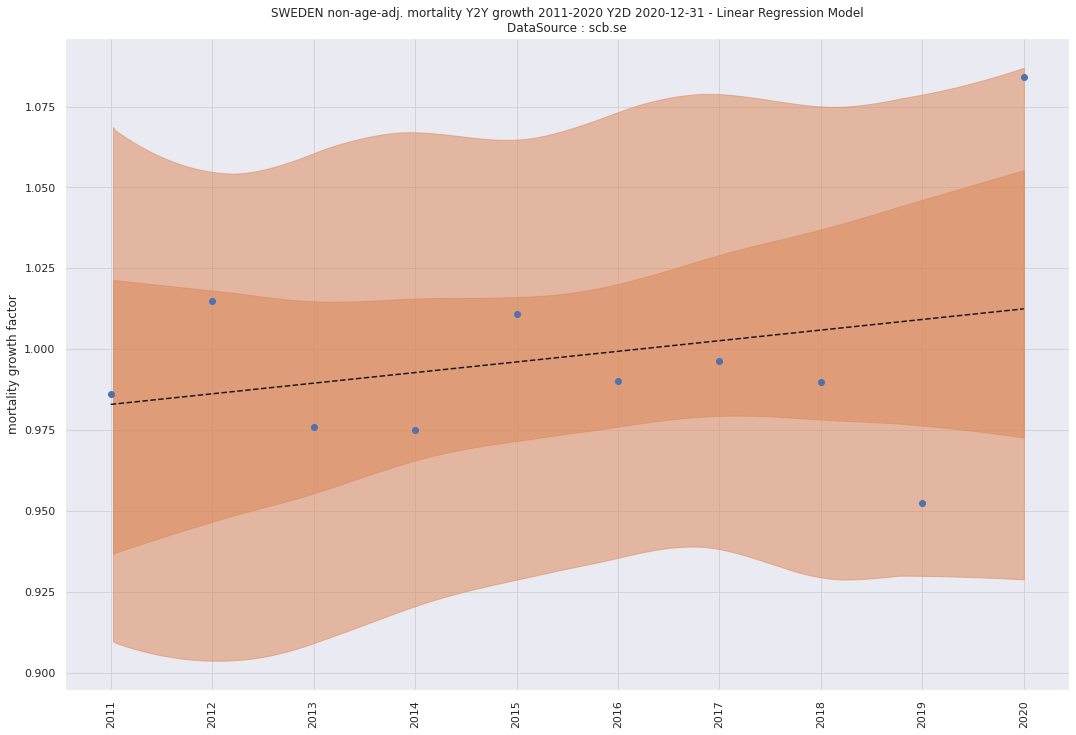

In [6368]:
fig,ax = plt.subplots(figsize=(18,12))
with model:
    
    
    title1 = 'SWEDEN non-age-adj. mortality Y2Y growth {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year + 1,last_good_date)
    
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1 + title4 )
    plt.ylabel('mortality growth factor')
    
    ppc = pm.sample_posterior_predictive(trace,samples=1000,model=model)
    
    az.plot_hpd(x,trace['reg'],hdi_prob=0.89,ax=ax)
    ax.plot(trace['alpha'].mean() + x * trace['beta'].mean(),color='k',ls='dashed')
    ax.plot(range(len(mortality_growth)),mortality_growth['growth'],'o')
    ax.set_xticks(range(len(mortality_growth)))
    ax.set_xticklabels(range(linreg_start_year+1,2021),rotation=90)
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    '''
        
    plt.savefig('swe_mortality__Y2Y_growth_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')


In [6369]:
linreg_growth_mean = trace['alpha'].mean() + x * trace['beta'].mean()

growth_diff = mortality_growth['growth'] - linreg_growth_mean

growth_diff

year
2011    0.003111
2012    0.028784
2013   -0.013707
2014   -0.017622
2015    0.014907
2016   -0.009044
2017   -0.006318
2018   -0.015979
2019   -0.056627
2020    0.071811
Name: growth, dtype: float64

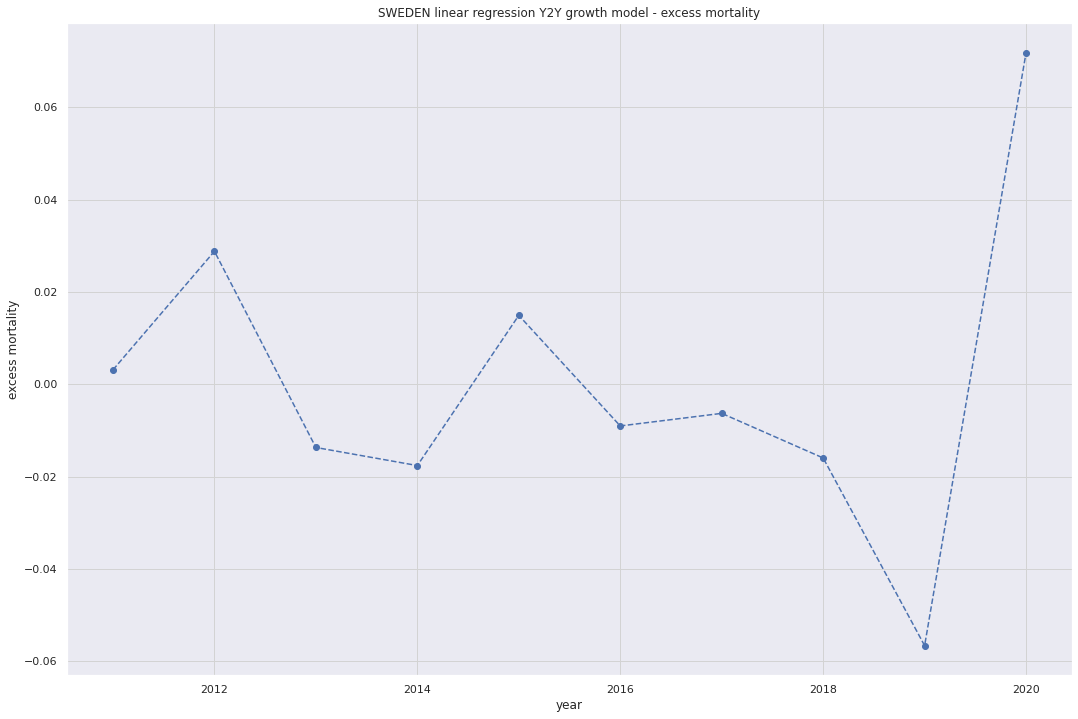

In [6370]:
title = 'SWEDEN linear regression Y2Y growth model - excess mortality'
growth_diff.plot(figsize=(18,12),style='o--',title=title)
plt.ylabel('excess mortality')
plt.savefig('swe_linreg_YTY_growth_excess_{}.jpg'.format(linreg_start_year),format='jpg')

In [6371]:
yearly_mortality *= 1000 # to get pymc to process the otherwise very small numbers


In [6372]:
yearly_mortality

year
2010    9.687408
2011    9.552050
2012    9.695181
2013    9.460340
2014    9.225221
2015    9.326325
2016    9.235798
2017    9.201660
2018    9.108972
2019    8.676871
2020    9.408198
dtype: float64

<AxesSubplot:xlabel='year'>

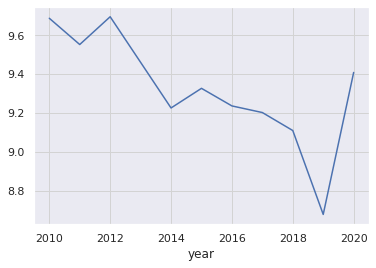

In [6373]:
yearly_mortality.plot()

In [6374]:
model2 = pm.Model()
with model2:
    

    ### it might be necessary to modify the params to alpha when changing period. Look at the trace plots.
    x = range(len(yearly_mortality))
    
    alpha = pm.Normal('alpha',20,10)
    beta = pm.Normal('beta',0, 2)
    sigma = pm.Normal('sigma',10, 5)
    
    reg = pm.Deterministic('reg',alpha + x * beta)
    
    obs = pm.Normal('obs',reg, sigma,observed=yearly_mortality)
    
    trace2 = pm.sample(500,tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8967727095964613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799601560696092, but should be close to 0.8. Try to increase the number of tuning steps.


          mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha    9.652  0.138     9.428      9.864      0.006    0.005     454.0   
beta    -0.065  0.025    -0.105     -0.029      0.001    0.001     431.0   
sigma    0.243  0.070     0.139      0.329      0.005    0.003     233.0   
reg[0]   9.652  0.138     9.428      9.864      0.006    0.005     454.0   
reg[1]   9.587  0.118     9.391      9.768      0.005    0.004     482.0   
reg[2]   9.522  0.100     9.348      9.666      0.004    0.003     538.0   
reg[3]   9.456  0.086     9.327      9.597      0.003    0.002     655.0   
reg[4]   9.391  0.077     9.276      9.518      0.003    0.002     830.0   
reg[5]   9.326  0.075     9.212      9.437      0.002    0.002     983.0   
reg[6]   9.261  0.081     9.141      9.380      0.002    0.002    1059.0   
reg[7]   9.196  0.093     9.066      9.332      0.003    0.002     883.0   
reg[8]   9.131  0.110     8.961      9.289      0.004    0.003     745.0   
reg[9]   9.0

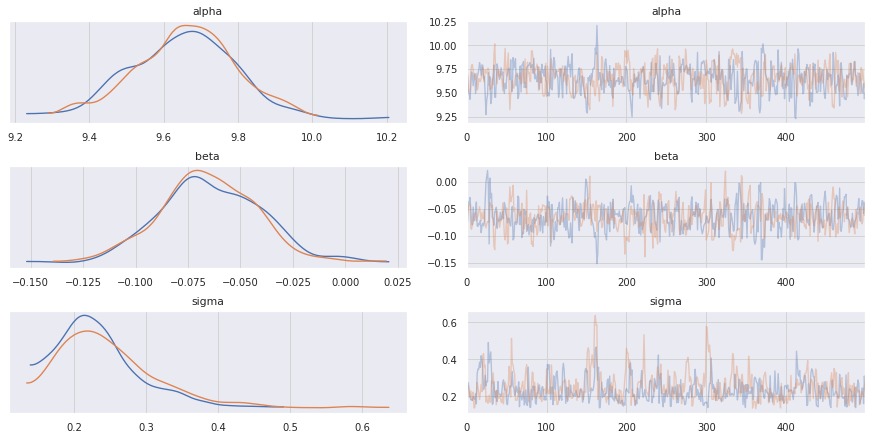

In [6375]:
with model2:
    print (pm.summary(trace2,hdi_prob=0.89))
    az.plot_trace(trace2,var_names=['alpha','beta','sigma'])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


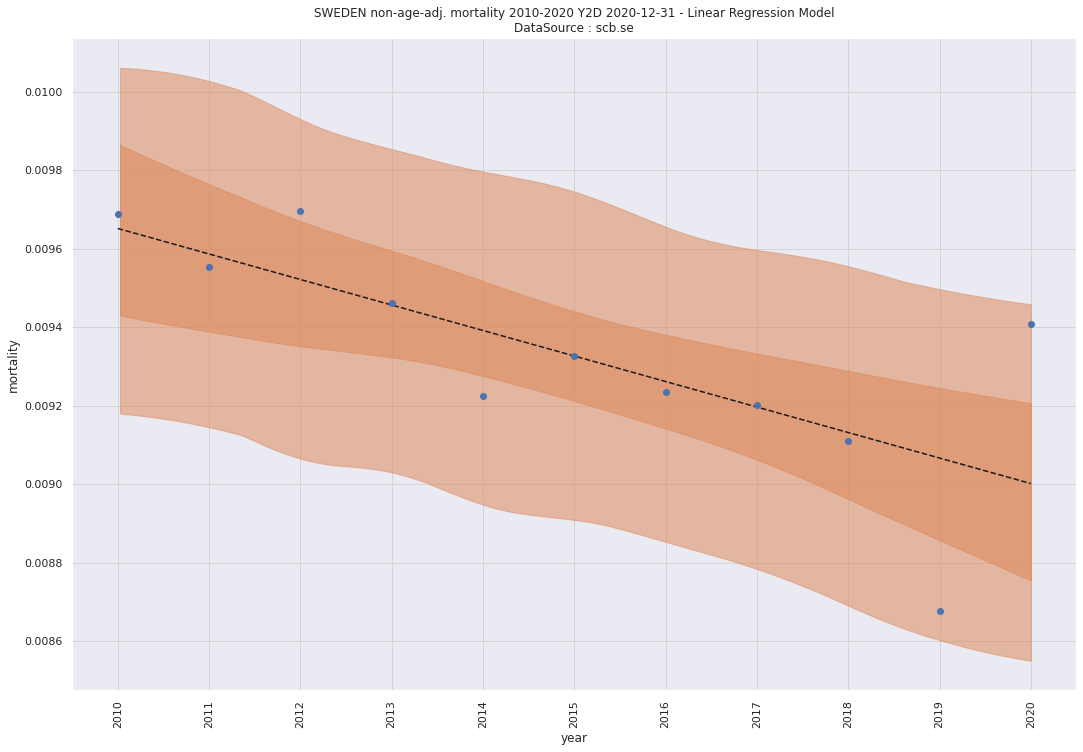

In [6376]:
fig,ax = plt.subplots(figsize=(18,12))

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:.4f}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function


with model2:
    
    title1 = 'SWEDEN non-age-adj. mortality {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year,last_good_date)
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title3 = '\nAccording to this model - and many others using "Excess Deaths" - SWE has had excess deaths since late 70:ies'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1+title4)
    
    ppc = pm.sample_posterior_predictive(trace2,samples=1000,model=model2)

    az.plot_hpd(x,trace2['reg'],hdi_prob=0.89,ax=ax)
    
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    ax.plot(x,trace2['alpha'].mean() + x * trace2['beta'].mean(),color='k',ls='--')
    ax.plot(x,yearly_mortality,'o')
    ax.set_xticks(range(len(yearly_mortality)))
    ax.set_xticklabels(range(linreg_start_year,2021),rotation=90)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    '''
    
    ax.yaxis.set_major_formatter(yfmt)
    
    plt.ylabel('mortality')
    plt.xlabel('year')
        
    plt.savefig('swe_mortality_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')

In [6377]:
linreg_mort_mean = (trace2['alpha'].mean() + x * trace2['beta'].mean()) / 1000
mort_diff = yearly_mortality/1000 - linreg_mort_mean
mort_diff

year
2010    3.586003e-05
2011   -3.448058e-05
2012    1.736676e-04
2013    3.843607e-06
2014   -1.662588e-04
2015   -1.374549e-07
2016   -2.564754e-05
2017    5.231992e-06
2018   -2.243898e-05
2019   -3.895223e-04
2020    4.068212e-04
dtype: float64

In [6378]:
total_pop = pop_df.groupby(['year'])['pop'].sum()
total_pop['2020'] = 10378483 # scb november population, updated dec 2020
total_pop


year
1860     3859728
1861     3912498
1862     3957501
1863     4011652
1864     4060806
1865     4108964
1866     4156245
1867     4193830
1868     4194051
1869     4180029
1870     4168525
1871     4206465
1872     4248826
1873     4293477
1874     4331345
1875     4372029
1876     4429713
1877     4484542
1878     4531863
1879     4578901
1880     4565668
1881     4572245
1882     4579115
1883     4603595
1884     4644448
1885     4682769
1886     4717189
1887     4734901
1888     4748257
1889     4774409
1890     4784981
1891     4802751
1892     4806865
1893     4824150
1894     4873183
1895     4919260
1896     4962568
1897     5009632
1898     5062918
1899     5097402
1900     5136441
1901     5175228
1902     5198752
1903     5221291
1904     5260811
1905     5294885
1906     5337055
1907     5377713
1908     5429600
1909     5476441
1910     5522403
1911     5561799
1912     5604192
1913     5638583
1914     5679607
1915     5712740
1916     5757566
1917     5800847
1918     

In [6379]:
idx = [int(x) for x in total_pop.index]
total_pop.index = idx


excess = mort_diff * total_pop.loc[linreg_start_year:]
excess

year
2010     337.642596
2011    -326.974353
2012    1659.548649
2013      37.071067
2014   -1620.583146
2015      -1.354071
2016    -256.351061
2017      52.949021
2018    -229.554955
2019   -4022.826012
2020    4222.187364
dtype: float64

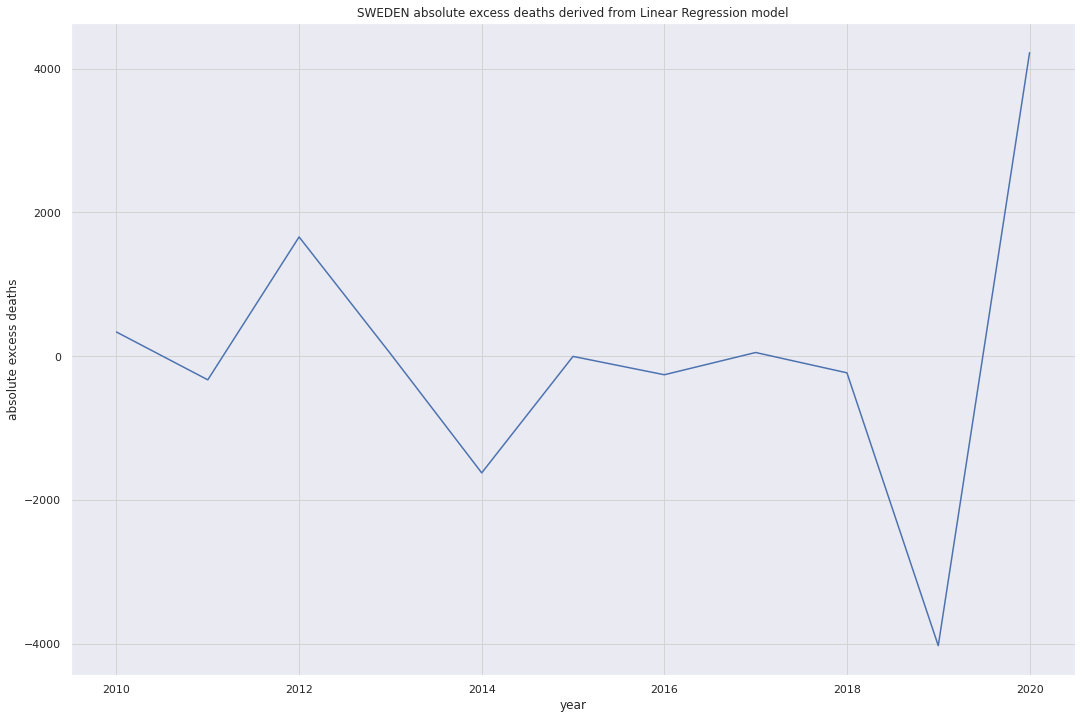

In [6380]:
excess.plot(figsize=(18,12),title='SWEDEN absolute excess deaths derived from Linear Regression model')
plt.ylabel('absolute excess deaths')
plt.xlabel('year')

plt.savefig('swe_linreg_excess_{}.jpg'.format(linreg_start_year),format='jpg')


In [6381]:
yearly_mortality.index[0]

2010

In [6382]:
pop_df = pop_df.set_index(['year','grp'])
pop_df

age     pop  age_num
year grp                              
1860 (-1, 64]       0  119426        0
     (-1, 64]       1  110834        1
     (-1, 64]       2  104550        2
     (-1, 64]       3   92409        3
     (-1, 64]       4   86322        4
...               ...     ...      ...
2019 (89, 1000]    96    5241       96
     (89, 1000]    97    3655       97
     (89, 1000]    98    2709       98
     (89, 1000]    99    1854       99
     (89, 1000]  100+    2207      100

[16160 rows x 3 columns]

In [6383]:
grouped_pop = pop_df.reset_index().groupby(['year','grp']).sum()
grouped_pop

pop  age_num
year grp                         
1860 (-1, 64]    3658083     2080
     (64, 79]     181778     1080
     (79, 89]      18478      845
     (89, 1000]     1389     1045
1861 (-1, 64]    3704392     2080
     (64, 79]     187642     1080
     (79, 89]      19088      845
     (89, 1000]     1376     1045
1862 (-1, 64]    3744694     2080
     (64, 79]     192039     1080
     (79, 89]      19387      845
     (89, 1000]     1381     1045
1863 (-1, 64]    3793991     2080
     (64, 79]     196779     1080
     (79, 89]      19586      845
     (89, 1000]     1296     1045
1864 (-1, 64]    3841232     2080
     (64, 79]     198797     1080
     (79, 89]      19382      845
     (89, 1000]     1395     1045
1865 (-1, 64]    3888039     2080
     (64, 79]     199949     1080
     (79, 89]      19568      845
     (89, 1000]     1408     1045
1866 (-1, 64]    3933755     2080
     (64, 79]     200810     1080
     (79, 89]      20310      845
     (89, 1000]     1370     1045
1867 (-1, 64]    3970178     2080
     (64, 79]     202668     1080
     (79, 89]      19759      845
     (89, 1000]     1225     1045
1868 (-1, 64]    3970004     2080
     (64, 79]     202609     1080
     (79, 89]      20301      845
     (89, 1000]     1137     1045
1869 (-1, 64]    3955441     2080
     (64, 79]     203228     1080
     (79, 89]      20326      845
     (89, 1000]     1034     1045
1870 (-1, 64]    3941319     2080
     (64, 79]     204166     1080
     (79, 89]      21311      845
     (89, 1000]     1729     1045
1871 (-1, 64]    3977998     2080
     (64, 79]     204584     1080
     (79, 89]      22164      845
     (89, 1000]     1719     1045
1872 (-1, 64]    4015755     2080
     (64, 79]     207514     1080
     (79, 89]      23830      845
     (89, 1000]     1727     1045
1873 (-1, 64]    4058023     2080
     (64, 79]     208539     1080
     (79, 89]      25203      845
     (89, 1000]     1712     1045
1874 (-1, 64]    4096952     2080
     (64, 79]     206650     1080
     (79, 89]      26005      845
     (89, 1000]     1738     1045
1875 (-1, 64]    4134218     2080
     (64, 79]     209860     1080
     (79, 89]      26270      845
     (89, 1000]     1681     1045
1876 (-1, 64]    4184685     2080
     (64, 79]     216416     1080
     (79, 89]      27531      845
     (89, 1000]     1081     1045
1877 (-1, 64]    4232760     2080
     (64, 79]     222269     1080
     (79, 89]      28554      845
     (89, 1000]      959     1045
1878 (-1, 64]    4276484     2080
     (64, 79]     224924     1080
     (79, 89]      29357      845
     (89, 1000]     1098     1045
1879 (-1, 64]    4317113     2080
     (64, 79]     230339     1080
     (79, 89]      30541      845
     (89, 1000]      908     1045
1880 (-1, 64]    4296448     2080
     (64, 79]     237563     1080
     (79, 89]      29951      845
     (89, 1000]     1706     1045
1881 (-1, 64]    4295483     2080
     (64, 79]     245442     1080
     (79, 89]      29722      845
     (89, 1000]     1598     1045
1882 (-1, 64]    4294082     2080
     (64, 79]     252015     1080
     (79, 89]      31226      845
     (89, 1000]     1792     1045
1883 (-1, 64]    4310162     2080
     (64, 79]     259541     1080
     (79, 89]      32017      845
     (89, 1000]     1875     1045
1884 (-1, 64]    4344126     2080
     (64, 79]     265819     1080
     (79, 89]      32652      845
     (89, 1000]     1851     1045
1885 (-1, 64]    4374962     2080
     (64, 79]     272757     1080
     (79, 89]      33238      845
     (89, 1000]     1812     1045
1886 (-1, 64]    4398113     2080
     (64, 79]     283504     1080
     (79, 89]      33687      845
     (89, 1000]     1885     1045
1887 (-1, 64]    4403141     2080
     (64, 79]     295198     1080
     (79, 89]      34672      845
     (89, 1000]     1890     1045
1888 (-1, 64]    4404176     2080
     (64, 79]     307451     1080
     (79, 89]      34657      845
     (89, 1000]     1973     1045
1889 (-1,

In [6384]:
pop_pivot = (grouped_pop.reset_index()).pivot(index='year',columns='grp',values='pop')
pop_pivot

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
1860     3658083      181778       18478        1389
1861     3704392      187642       19088        1376
1862     3744694      192039       19387        1381
1863     3793991      196779       19586        1296
1864     3841232      198797       19382        1395
1865     3888039      199949       19568        1408
1866     3933755      200810       20310        1370
1867     3970178      202668       19759        1225
1868     3970004      202609       20301        1137
1869     3955441      203228       20326        1034
1870     3941319      204166       21311        1729
1871     3977998      204584       22164        1719
1872     4015755      207514       23830        1727
1873     4058023      208539       25203        1712
1874     4096952      206650       26005        1738
1875     4134218      209860       26270        1681
1876     4184685      216416       27531        1081
1877     4232760      222269       28554         959
1878     4276484      224924       29357        1098
1879     4317113      230339       30541         908
1880     4296448      237563       29951        1706
1881     4295483      245442       29722        1598
1882     4294082      252015       31226        1792
1883     4310162      259541       32017        1875
1884     4344126      265819       32652        1851
1885     4374962      272757       33238        1812
1886     4398113      283504       33687        1885
1887     4403141      295198       34672        1890
1888     4404176      307451       34657        1973
1889     4420480      317901       33917        2111
1890     4417243      328782       36858        2098
1891     4426195      335509       38941        2106
1892     4429804      335613       39304        2144
1893     4440874      341740       39272        2264
1894     4481482      348623       40732        2346
1895     4520446      352988       43479        2347
1896     4559654      354373       46201        2340
1897     4601116      358422       47597        2497
1898     4645265      365526       49535        2592
1899     4675752      369144       50271        2235
1900     4706607      375056       52272        2506
1901     4739994      377209       55232        2793
1902     4760645      377225       57910        2972
1903     4780946      375839       61444        3062
1904     4819467      375411       62819        3114
1905     4849589      376979       64879        3438
1906     4887494      378766       67021        3774
1907     4924813      382355       66807        3738
1908     4974831      384128       66827        3814
1909     5015695      388435       68316        3995
1910     5056333      391628       70226        4216
1911     5094549      392610       70045        4595
1912     5136865      392386       69979        4962
1913     5168958      392988       71351        5286
1914     5205201      396333       72743        5330
1915     5237852      397056       72591        5241
1916     5277884      400622       73611        5449
1917     5319908      401870       73848        5221
1918     5330134      405081       73368        5267
1919     5357430      411463       72875        5269
1920     5408296      415232       75257        5704
1921     5453469      419267       75866        5714
1922     5483833      422590       75261        5836
1923     5491819      431299       76588        6053
1924     5512607      439203       78076        6232
1925     5521266      447120       78747        6429
1926     5536757      452831       78236        6544
1927     5546121      458625       76943        6234
1928     5555517      465858       77742        6073
1929     5562854      471743       79344        6139
1930     5576232      478217       81248        6494
1931     5594207      482245       80073        5921
1932     5618873      485373       80093        6025
1933     5639886      483

In [6385]:
pop_pivot.sum(axis=1)

year
1860     3859728
1861     3912498
1862     3957501
1863     4011652
1864     4060806
1865     4108964
1866     4156245
1867     4193830
1868     4194051
1869     4180029
1870     4168525
1871     4206465
1872     4248826
1873     4293477
1874     4331345
1875     4372029
1876     4429713
1877     4484542
1878     4531863
1879     4578901
1880     4565668
1881     4572245
1882     4579115
1883     4603595
1884     4644448
1885     4682769
1886     4717189
1887     4734901
1888     4748257
1889     4774409
1890     4784981
1891     4802751
1892     4806865
1893     4824150
1894     4873183
1895     4919260
1896     4962568
1897     5009632
1898     5062918
1899     5097402
1900     5136441
1901     5175228
1902     5198752
1903     5221291
1904     5260811
1905     5294885
1906     5337055
1907     5377713
1908     5429600
1909     5476441
1910     5522403
1911     5561799
1912     5604192
1913     5638583
1914     5679607
1915     5712740
1916     5757566
1917     5800847
1918     

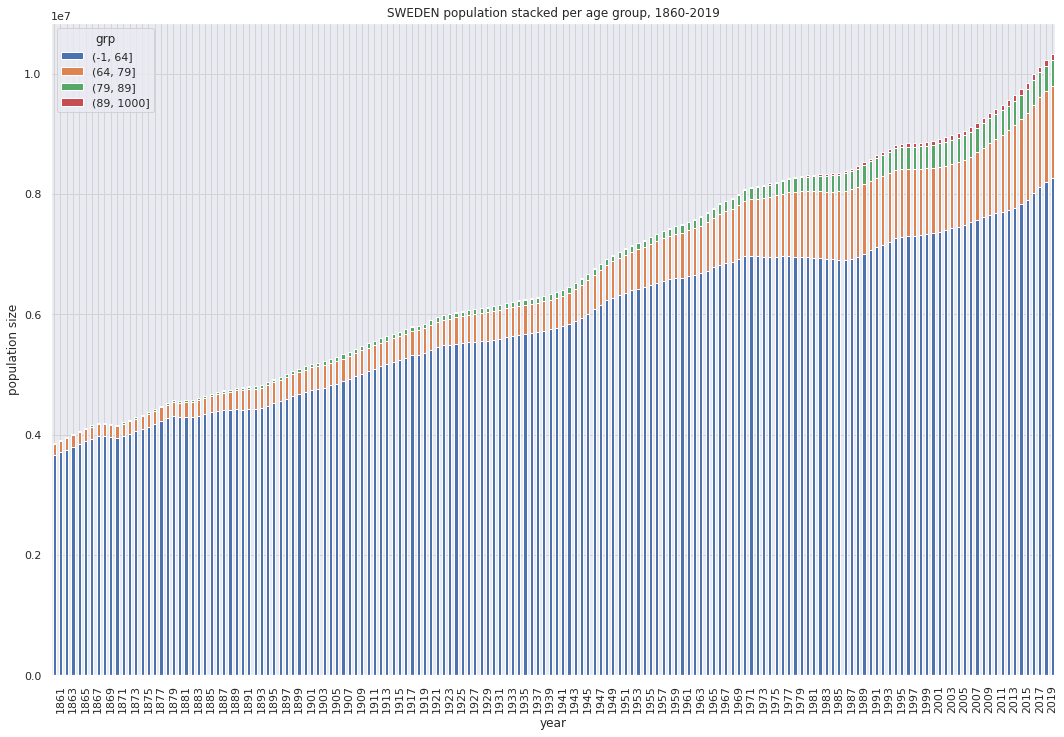

In [6386]:
title = 'SWEDEN population stacked per age group, 1860-2019'
ax = pop_pivot.plot(kind='bar',stacked=True,figsize=(18,12),title=title)

for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
        
plt.ylabel('population size')
plt.savefig('swe_abs_pop_age_grp_1860_2019.jpg',format='jpg')

In [6387]:
rel_pop_pivot = pop_pivot.div(pop_pivot.sum(axis=1),axis=0)
rel_pop_pivot

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
1860    0.947757    0.047096    0.004787    0.000360
1861    0.946810    0.047960    0.004879    0.000352
1862    0.946227    0.048525    0.004899    0.000349
1863    0.945743    0.049052    0.004882    0.000323
1864    0.945928    0.048955    0.004773    0.000344
1865    0.946233    0.048662    0.004762    0.000343
1866    0.946469    0.048315    0.004887    0.000330
1867    0.946671    0.048325    0.004711    0.000292
1868    0.946580    0.048309    0.004840    0.000271
1869    0.946271    0.048619    0.004863    0.000247
1870    0.945495    0.048978    0.005112    0.000415
1871    0.945687    0.048636    0.005269    0.000409
1872    0.945145    0.048840    0.005609    0.000406
1873    0.945160    0.048571    0.005870    0.000399
1874    0.945884    0.047710    0.006004    0.000401
1875    0.945606    0.048001    0.006009    0.000384
1876    0.944685    0.048856    0.006215    0.000244
1877    0.943856    0.049563    0.006367    0.000214
1878    0.943648    0.049632    0.006478    0.000242
1879    0.942827    0.050304    0.006670    0.000198
1880    0.941034    0.052032    0.006560    0.000374
1881    0.939469    0.053681    0.006501    0.000350
1882    0.937754    0.055036    0.006819    0.000391
1883    0.936260    0.056378    0.006955    0.000407
1884    0.935337    0.057234    0.007030    0.000399
1885    0.934268    0.058247    0.007098    0.000387
1886    0.932359    0.060100    0.007141    0.000400
1887    0.929933    0.062345    0.007323    0.000399
1888    0.927535    0.064750    0.007299    0.000416
1889    0.925870    0.066584    0.007104    0.000442
1890    0.923147    0.068711    0.007703    0.000438
1891    0.921596    0.069858    0.008108    0.000438
1892    0.921558    0.069820    0.008177    0.000446
1893    0.920551    0.070839    0.008141    0.000469
1894    0.919621    0.071539    0.008358    0.000481
1895    0.918928    0.071756    0.008839    0.000477
1896    0.918809    0.071409    0.009310    0.000472
1897    0.918454    0.071547    0.009501    0.000498
1898    0.917507    0.072197    0.009784    0.000512
1899    0.917281    0.072418    0.009862    0.000438
1900    0.916317    0.073019    0.010177    0.000488
1901    0.915901    0.072887    0.010672    0.000540
1902    0.915728    0.072561    0.011139    0.000572
1903    0.915664    0.071982    0.011768    0.000586
1904    0.916107    0.071360    0.011941    0.000592
1905    0.915901    0.071197    0.012253    0.000649
1906    0.915766    0.070969    0.012558    0.000707
1907    0.915782    0.071100    0.012423    0.000695
1908    0.916243    0.070747    0.012308    0.000702
1909    0.915868    0.070928    0.012475    0.000729
1910    0.915604    0.070916    0.012717    0.000763
1911    0.915989    0.070590    0.012594    0.000826
1912    0.916611    0.070017    0.012487    0.000885
1913    0.916712    0.069696    0.012654    0.000937
1914    0.916472    0.069782    0.012808    0.000938
1915    0.916872    0.069504    0.012707    0.000917
1916    0.916687    0.069582    0.012785    0.000946
1917    0.917092    0.069278    0.012731    0.000900
1918    0.916799    0.069675    0.012620    0.000906
1919    0.916264    0.070371    0.012464    0.000901
1920    0.915963    0.070325    0.012746    0.000966
1921    0.915885    0.070414    0.012741    0.000960
1922    0.915877    0.070578    0.012570    0.000975
1923    0.914425    0.071814    0.012752    0.001008
1924    0.913270    0.072762    0.012935    0.001032
1925    0.912069    0.073861    0.013008    0.001062
1926    0.911495    0.074548    0.012880    0.001077
1927    0.911004    0.075334    0.012639    0.001024
1928    0.909966    0.076305    0.012734    0.000995
1929    0.908951    0.077081    0.012965    0.001003
1930    0.907857    0.077858    0.013228    0.001057
1931    0.907790    0.078255    0.012994    0.000961
1932    0.907681    0.078408    0.012938    0.000973
1933    0.907965    0.077

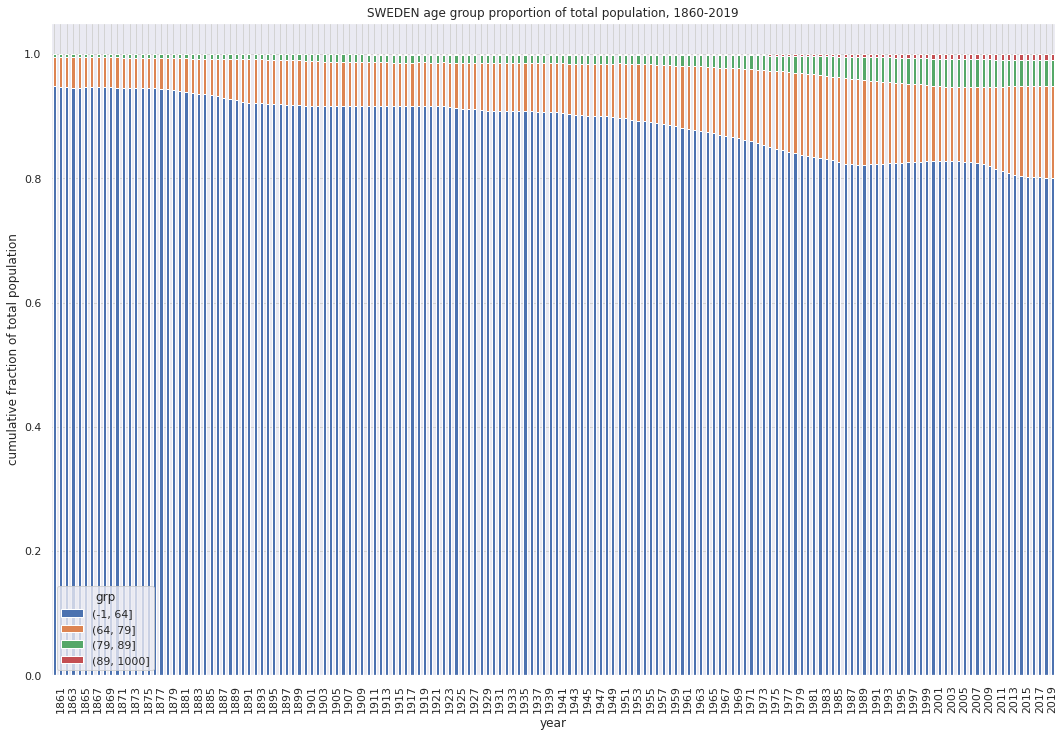

In [6388]:
title = 'SWEDEN age group proportion of total population, 1860-2019'


ax = rel_pop_pivot.plot(kind='bar',stacked=True,figsize=(18,12),title=title)

for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

plt.ylabel('cumulative fraction of total population')
plt.savefig('swe_rel_pop_age_grp_1860_2019.jpg',format='jpg')        

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='year'>

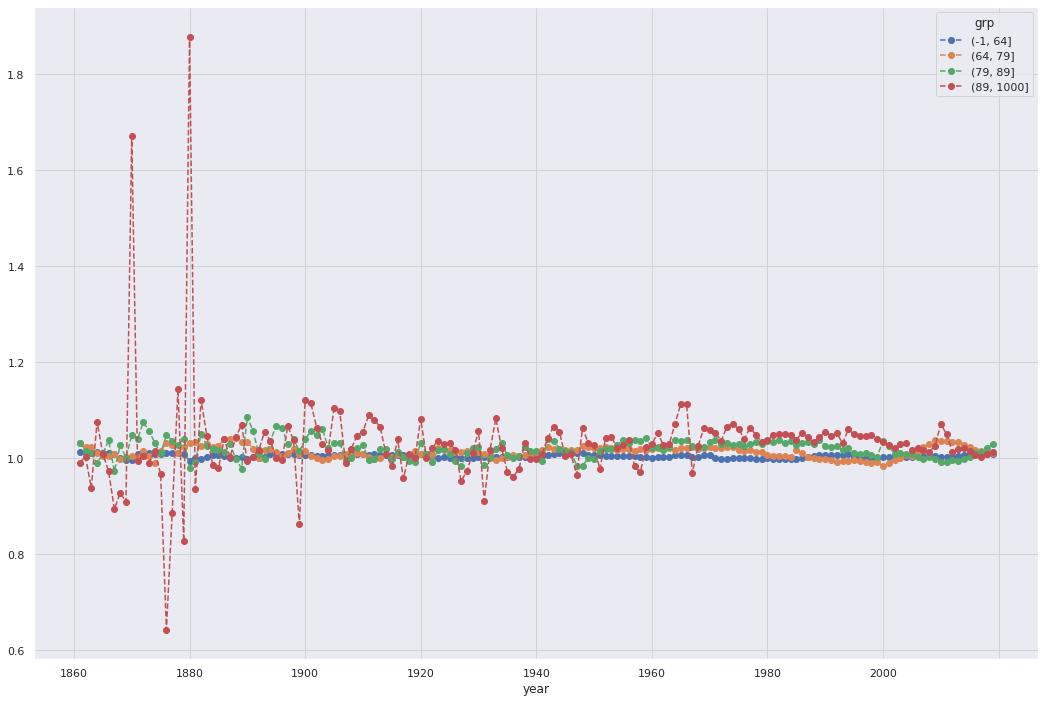

In [6389]:
(pop_pivot / pop_pivot.shift()).plot(figsize=(18,12),style=['o--'] * 4)

In [6390]:
pop_growth_since_1860 = pop_pivot / pop_pivot.loc['1860']
pop_growth_since_1860

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
1860    1.000000    1.000000    1.000000    1.000000
1861    1.012659    1.032259    1.033012    0.990641
1862    1.023677    1.056448    1.049194    0.994240
1863    1.037153    1.082524    1.059963    0.933045
1864    1.050067    1.093625    1.048923    1.004320
1865    1.062862    1.099963    1.058989    1.013679
1866    1.075360    1.104699    1.099145    0.986321
1867    1.085317    1.114920    1.069326    0.881929
1868    1.085269    1.114596    1.098658    0.818575
1869    1.081288    1.118001    1.100011    0.744420
1870    1.077427    1.123161    1.153317    1.244780
1871    1.087454    1.125461    1.199480    1.237581
1872    1.097776    1.141579    1.289642    1.243341
1873    1.109330    1.147218    1.363946    1.232541
1874    1.119972    1.136826    1.407349    1.251260
1875    1.130160    1.154485    1.421691    1.210223
1876    1.143956    1.190551    1.489934    0.778258
1877    1.157098    1.222750    1.545297    0.690425
1878    1.169051    1.237355    1.588754    0.790497
1879    1.180157    1.267145    1.652830    0.653708
1880    1.174508    1.306885    1.620901    1.228222
1881    1.174244    1.350229    1.608507    1.150468
1882    1.173861    1.386389    1.689902    1.290137
1883    1.178257    1.427791    1.732709    1.349892
1884    1.187542    1.462328    1.767074    1.332613
1885    1.195971    1.500495    1.798788    1.304536
1886    1.202300    1.559617    1.823087    1.357091
1887    1.203674    1.623948    1.876394    1.360691
1888    1.203957    1.691354    1.875582    1.420446
1889    1.208414    1.748842    1.835534    1.519798
1890    1.207529    1.808701    1.994696    1.510439
1891    1.209977    1.845707    2.107425    1.516199
1892    1.210963    1.846280    2.127070    1.543557
1893    1.213989    1.879985    2.125338    1.629950
1894    1.225090    1.917850    2.204351    1.688985
1895    1.235742    1.941863    2.353014    1.689705
1896    1.246460    1.949482    2.500325    1.684665
1897    1.257794    1.971757    2.575874    1.797696
1898    1.269863    2.010837    2.680755    1.866091
1899    1.278197    2.030741    2.720587    1.609071
1900    1.286632    2.063264    2.828878    1.804176
1901    1.295759    2.075108    2.989068    2.010799
1902    1.301404    2.075196    3.133997    2.139669
1903    1.306954    2.067571    3.325252    2.204464
1904    1.317484    2.065217    3.399664    2.241901
1905    1.325719    2.073843    3.511148    2.475162
1906    1.336081    2.083673    3.627070    2.717063
1907    1.346282    2.103417    3.615489    2.691145
1908    1.359956    2.113171    3.616571    2.745860
1909    1.371127    2.136865    3.697153    2.876170
1910    1.382236    2.154430    3.800520    3.035277
1911    1.392683    2.159832    3.790724    3.308135
1912    1.404251    2.158600    3.787152    3.572354
1913    1.413024    2.161912    3.861403    3.805616
1914    1.422931    2.180313    3.936736    3.837293
1915    1.431857    2.184291    3.928510    3.773218
1916    1.442801    2.203908    3.983710    3.922966
1917    1.454288    2.210774    3.996536    3.758819
1918    1.457084    2.228438    3.970560    3.791937
1919    1.464546    2.263547    3.943879    3.793377
1920    1.478451    2.284281    4.072789    4.106551
1921    1.490800    2.306478    4.105747    4.113751
1922    1.499100    2.324759    4.073006    4.201584
1923    1.501283    2.372669    4.144821    4.357811
1924    1.506966    2.416150    4.225349    4.486681
1925    1.509333    2.459704    4.261663    4.628510
1926    1.513568    2.491121    4.234008    4.711303
1927    1.516128    2.522995    4.164033    4.488121
1928    1.518696    2.562785    4.207274    4.372210
1929    1.520702    2.595160    4.293971    4.419726
1930    1.524359    2.630775    4.397013    4.675306
1931    1.529273    2.652934    4.333424    4.262779
1932    1.536016    2.670142    4.334506    4.337653
1933    1.541760    2.659

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='year'>

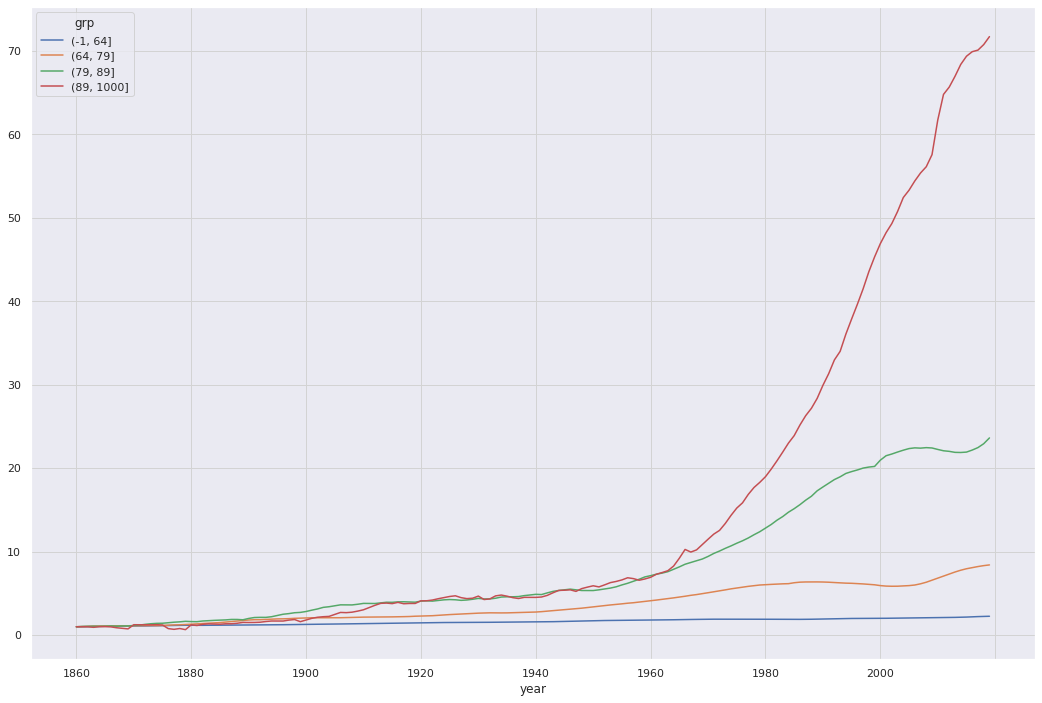

In [6391]:
pop_growth_since_1860.plot(figsize=(18,12))

In [6406]:
y = '2015'
pop_growth_since_year = pop_pivot / pop_pivot.loc[y]
pop_growth_since_year = pop_growth_since_year.loc[y:]
pop_growth_since_year

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
2015    1.000000    1.000000    1.000000    1.000000
2016    1.014487    1.016869    1.011074    1.007845
2017    1.026608    1.033135    1.024671    1.010595
2018    1.036778    1.047041    1.045753    1.020132
2019    1.045349    1.057751    1.077456    1.033872

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='year'>

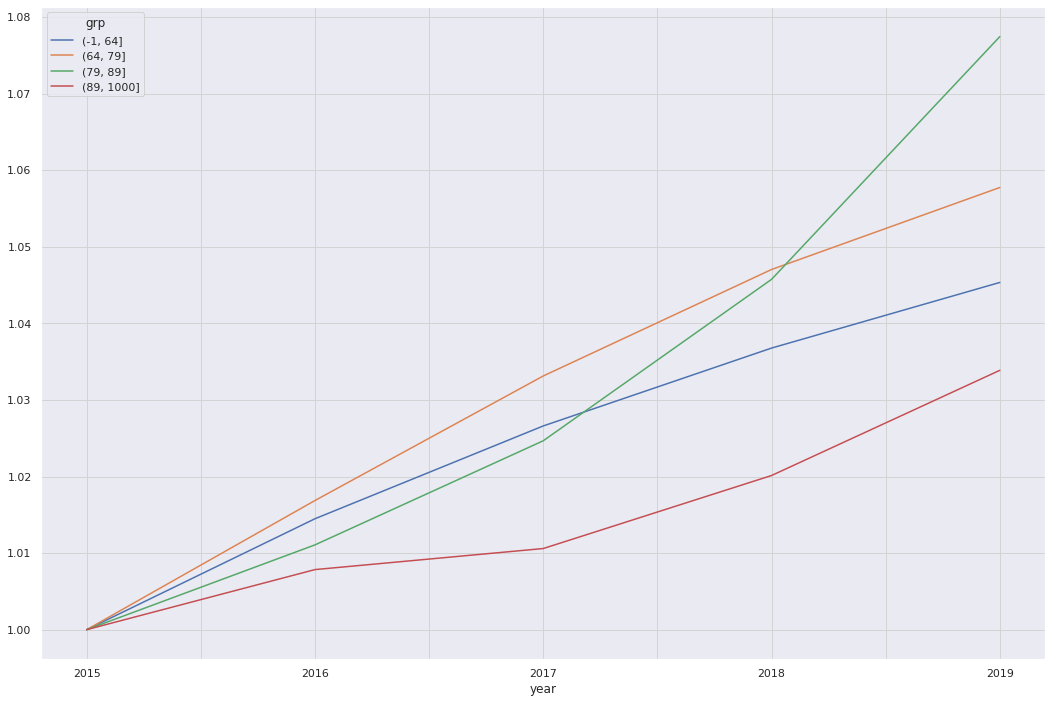

In [6407]:
pop_growth_since_year.plot(figsize=(18,12))

In [6392]:
rel_pop_pivot

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
1860    0.947757    0.047096    0.004787    0.000360
1861    0.946810    0.047960    0.004879    0.000352
1862    0.946227    0.048525    0.004899    0.000349
1863    0.945743    0.049052    0.004882    0.000323
1864    0.945928    0.048955    0.004773    0.000344
1865    0.946233    0.048662    0.004762    0.000343
1866    0.946469    0.048315    0.004887    0.000330
1867    0.946671    0.048325    0.004711    0.000292
1868    0.946580    0.048309    0.004840    0.000271
1869    0.946271    0.048619    0.004863    0.000247
1870    0.945495    0.048978    0.005112    0.000415
1871    0.945687    0.048636    0.005269    0.000409
1872    0.945145    0.048840    0.005609    0.000406
1873    0.945160    0.048571    0.005870    0.000399
1874    0.945884    0.047710    0.006004    0.000401
1875    0.945606    0.048001    0.006009    0.000384
1876    0.944685    0.048856    0.006215    0.000244
1877    0.943856    0.049563    0.006367    0.000214
1878    0.943648    0.049632    0.006478    0.000242
1879    0.942827    0.050304    0.006670    0.000198
1880    0.941034    0.052032    0.006560    0.000374
1881    0.939469    0.053681    0.006501    0.000350
1882    0.937754    0.055036    0.006819    0.000391
1883    0.936260    0.056378    0.006955    0.000407
1884    0.935337    0.057234    0.007030    0.000399
1885    0.934268    0.058247    0.007098    0.000387
1886    0.932359    0.060100    0.007141    0.000400
1887    0.929933    0.062345    0.007323    0.000399
1888    0.927535    0.064750    0.007299    0.000416
1889    0.925870    0.066584    0.007104    0.000442
1890    0.923147    0.068711    0.007703    0.000438
1891    0.921596    0.069858    0.008108    0.000438
1892    0.921558    0.069820    0.008177    0.000446
1893    0.920551    0.070839    0.008141    0.000469
1894    0.919621    0.071539    0.008358    0.000481
1895    0.918928    0.071756    0.008839    0.000477
1896    0.918809    0.071409    0.009310    0.000472
1897    0.918454    0.071547    0.009501    0.000498
1898    0.917507    0.072197    0.009784    0.000512
1899    0.917281    0.072418    0.009862    0.000438
1900    0.916317    0.073019    0.010177    0.000488
1901    0.915901    0.072887    0.010672    0.000540
1902    0.915728    0.072561    0.011139    0.000572
1903    0.915664    0.071982    0.011768    0.000586
1904    0.916107    0.071360    0.011941    0.000592
1905    0.915901    0.071197    0.012253    0.000649
1906    0.915766    0.070969    0.012558    0.000707
1907    0.915782    0.071100    0.012423    0.000695
1908    0.916243    0.070747    0.012308    0.000702
1909    0.915868    0.070928    0.012475    0.000729
1910    0.915604    0.070916    0.012717    0.000763
1911    0.915989    0.070590    0.012594    0.000826
1912    0.916611    0.070017    0.012487    0.000885
1913    0.916712    0.069696    0.012654    0.000937
1914    0.916472    0.069782    0.012808    0.000938
1915    0.916872    0.069504    0.012707    0.000917
1916    0.916687    0.069582    0.012785    0.000946
1917    0.917092    0.069278    0.012731    0.000900
1918    0.916799    0.069675    0.012620    0.000906
1919    0.916264    0.070371    0.012464    0.000901
1920    0.915963    0.070325    0.012746    0.000966
1921    0.915885    0.070414    0.012741    0.000960
1922    0.915877    0.070578    0.012570    0.000975
1923    0.914425    0.071814    0.012752    0.001008
1924    0.913270    0.072762    0.012935    0.001032
1925    0.912069    0.073861    0.013008    0.001062
1926    0.911495    0.074548    0.012880    0.001077
1927    0.911004    0.075334    0.012639    0.001024
1928    0.909966    0.076305    0.012734    0.000995
1929    0.908951    0.077081    0.012965    0.001003
1930    0.907857    0.077858    0.013228    0.001057
1931    0.907790    0.078255    0.012994    0.000961
1932    0.907681    0.078408    0.012938    0.000973
1933    0.907965    0.077

In [6393]:
rel_pop_growth_since_1860 = rel_pop_pivot / rel_pop_pivot.loc['1860']
rel_pop_growth_since_1860

grp   (-1, 64]    (64, 79]    (79, 89]    (89, 1000]
year                                                
1860    1.000000    1.000000    1.000000    1.000000
1861    0.999001    1.018336    1.019079    0.977279
1862    0.998386    1.030348    1.023273    0.969677
1863    0.997875    1.041528    1.019822    0.897710
1864    0.998071    1.039472    0.996984    0.954589
1865    0.998393    1.033243    0.994754    0.952193
1866    0.998641    1.025887    1.020729    0.915954
1867    0.998855    1.026100    0.984138    0.811670
1868    0.998758    1.025747    1.011080    0.753323
1869    0.998433    1.032333    1.015721    0.687378
1870    0.997614    1.039959    1.067882    1.152569
1871    0.997816    1.032690    1.100608    1.135568
1872    0.997244    1.037036    1.171539    1.129478
1873    0.997260    1.031320    1.226153    1.108024
1874    0.998025    1.013043    1.254111    1.115017
1875    0.997731    1.019206    1.255101    1.068413
1876    0.996759    1.037359    1.298220    0.678117
1877    0.995884    1.052389    1.329997    0.594231
1878    0.995665    1.053839    1.353121    0.673256
1879    0.994799    1.068124    1.393233    0.551035
1880    0.992907    1.104816    1.370278    1.038315
1881    0.991256    1.139816    1.357845    0.971184
1882    0.989446    1.168585    1.424415    1.087454
1883    0.987870    1.197083    1.452731    1.131771
1884    0.986896    1.215255    1.468512    1.107457
1885    0.985768    1.236769    1.482634    1.075251
1886    0.983753    1.276119    1.491698    1.110408
1887    0.981194    1.323786    1.529571    1.109188
1888    0.978664    1.374856    1.524609    1.154642
1889    0.976906    1.413799    1.483883    1.228636
1890    0.974034    1.458959    1.608990    1.218371
1891    0.972397    1.483302    1.693631    1.218492
1892    0.972357    1.482492    1.707956    1.239417
1893    0.971294    1.504147    1.700450    1.304098
1894    0.970314    1.519003    1.745922    1.337734
1895    0.969582    1.523616    1.846212    1.325769
1896    0.969457    1.516246    1.944673    1.310279
1897    0.969082    1.519162    1.984611    1.385055
1898    0.968083    1.532967    2.043681    1.422619
1899    0.967845    1.537667    2.060015    1.218381
1900    0.966827    1.550419    2.125732    1.355730
1901    0.966388    1.547633    2.229272    1.499671
1902    0.966206    1.540695    2.326785    1.588562
1903    0.966138    1.528408    2.458121    1.629603
1904    0.966606    1.515199    2.494250    1.644828
1905    0.966388    1.511736    2.559466    1.804279
1906    0.966246    1.506901    2.623077    1.964964
1907    0.966263    1.509679    2.594933    1.931506
1908    0.966749    1.502185    2.570904    1.951944
1909    0.966353    1.506036    2.605708    2.027089
1910    0.966075    1.505778    2.656266    2.121421
1911    0.966482    1.498861    2.630653    2.295750
1912    0.967138    1.486674    2.608294    2.460357
1913    0.967244    1.479874    2.643211    2.605023
1914    0.966991    1.481690    2.675313    2.607735
1915    0.967413    1.475784    2.654239    2.549319
1916    0.967217    1.477445    2.670580    2.629858
1917    0.967645    1.470989    2.659188    2.501018
1918    0.967336    1.479427    2.635995    2.517410
1919    0.966771    1.494205    2.603421    2.504072
1920    0.966454    1.493220    2.662357    2.684427
1921    0.966372    1.495114    2.661442    2.666630
1922    0.966363    1.498607    2.625577    2.708462
1923    0.964831    1.524846    2.663757    2.800640
1924    0.963613    1.544980    2.701852    2.868958
1925    0.962345    1.568298    2.717220    2.951120
1926    0.961740    1.582889    2.690341    2.993620
1927    0.961221    1.599573    2.639986    2.845457
1928    0.960126    1.620204    2.659857    2.764131
1929    0.959055    1.636680    2.708063    2.787372
1930    0.957901    1.653168    2.763065    2.937943
1931    0.957830    1.661613    2.714155    2.669909
1932    0.957715    1.664849    2.702590    2.704552
1933    0.958015    1.652

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


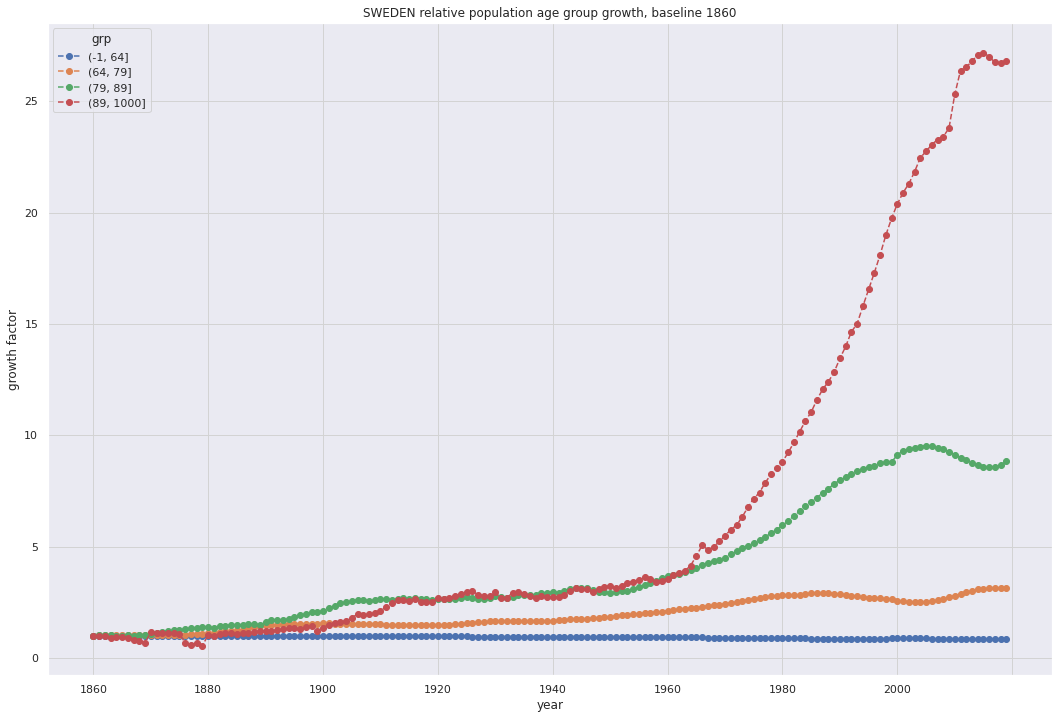

In [6394]:
title = 'SWEDEN relative population age group growth, baseline 1860'
rel_pop_growth_since_1860.plot(figsize=(18,12),style=['o--'] * 4,title=title)
plt.ylabel('growth factor')
plt.savefig('swe_age_group_rel_growth.jpg',format='jpg')

In [6395]:
age_adj_deaths_inc_2020['mort_x_1000'] = age_adj_deaths_inc_2020['age_pop_adj_mortality'] * 1000
age_adj_deaths_inc_2020 = age_adj_deaths_inc_2020.loc[linreg_start_year:].copy()
age_adj_deaths_inc_2020

std_pop  age_adj_deaths  age_pop_adj_mortality  mort_x_1000
2010  10327589.0   102398.894311               0.009915     9.915082
2011  10327589.0    99845.224898               0.009668     9.667815
2012  10327589.0   100887.918828               0.009769     9.768777
2013  10327589.0    97991.493460               0.009488     9.488322
2014  10327589.0    95140.288998               0.009212     9.212246
2015  10327589.0    96067.742883               0.009302     9.302049
2016  10327589.0    94972.137863               0.009196     9.195964
2017  10327589.0    94954.079413               0.009194     9.194216
2018  10327589.0    93815.014335               0.009084     9.083922
2019  10327589.0    88766.000000               0.008595     8.595036
2020  10327589.0    95462.907904               0.009243     9.243484

In [6396]:
model3 = pm.Model()
with model3:
    

    ### it might be necessary to modify the params to alpha when changing period. Look at the trace plots.
    x = range(len(age_adj_deaths_inc_2020))
    
    alpha = pm.Normal('alpha',20,5)
    beta = pm.Normal('beta',0, 1)
    sigma = pm.Normal('sigma',10, 5)
    
    reg = pm.Deterministic('reg',alpha + x * beta)
    
    obs = pm.Normal('obs',reg, sigma,observed=age_adj_deaths_inc_2020['mort_x_1000'])
    
    trace3 = pm.sample(500,tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8848345267625388, but should be close to 0.8. Try to increase the number of tuning steps.


          mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha    9.813  0.138     9.589     10.025      0.008    0.005     328.0   
beta    -0.096  0.023    -0.132     -0.061      0.001    0.001     331.0   
sigma    0.232  0.065     0.145      0.322      0.004    0.003     241.0   
reg[0]   9.813  0.138     9.589     10.025      0.008    0.005     328.0   
reg[1]   9.717  0.119     9.523      9.901      0.006    0.005     352.0   
reg[2]   9.621  0.103     9.441      9.766      0.005    0.004     405.0   
reg[3]   9.524  0.089     9.378      9.658      0.004    0.003     500.0   
reg[4]   9.428  0.080     9.298      9.546      0.003    0.002     636.0   
reg[5]   9.332  0.077     9.214      9.458      0.003    0.002     805.0   
reg[6]   9.236  0.081     9.122      9.378      0.003    0.002     829.0   
reg[7]   9.139  0.091     9.013      9.297      0.003    0.002     726.0   
reg[8]   9.043  0.105     8.892      9.217      0.004    0.003     622.0   
reg[9]   8.9

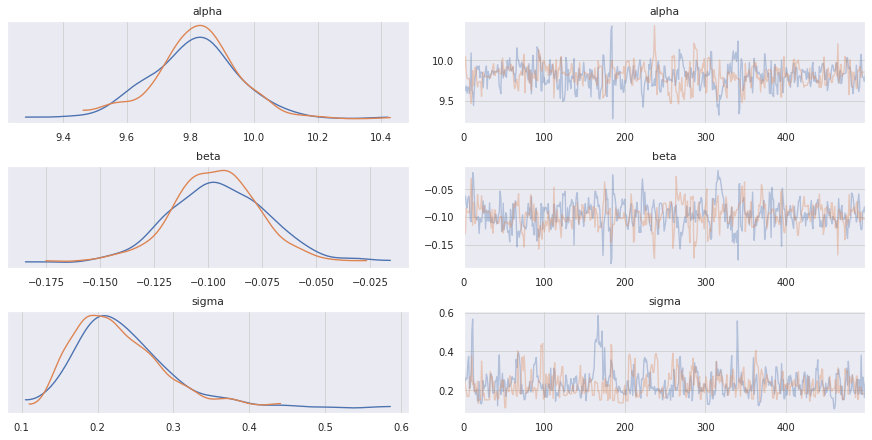

In [6397]:
with model3:
    print (pm.summary(trace3,hdi_prob=0.89))
    az.plot_trace(trace3,var_names=['alpha','beta','sigma'])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


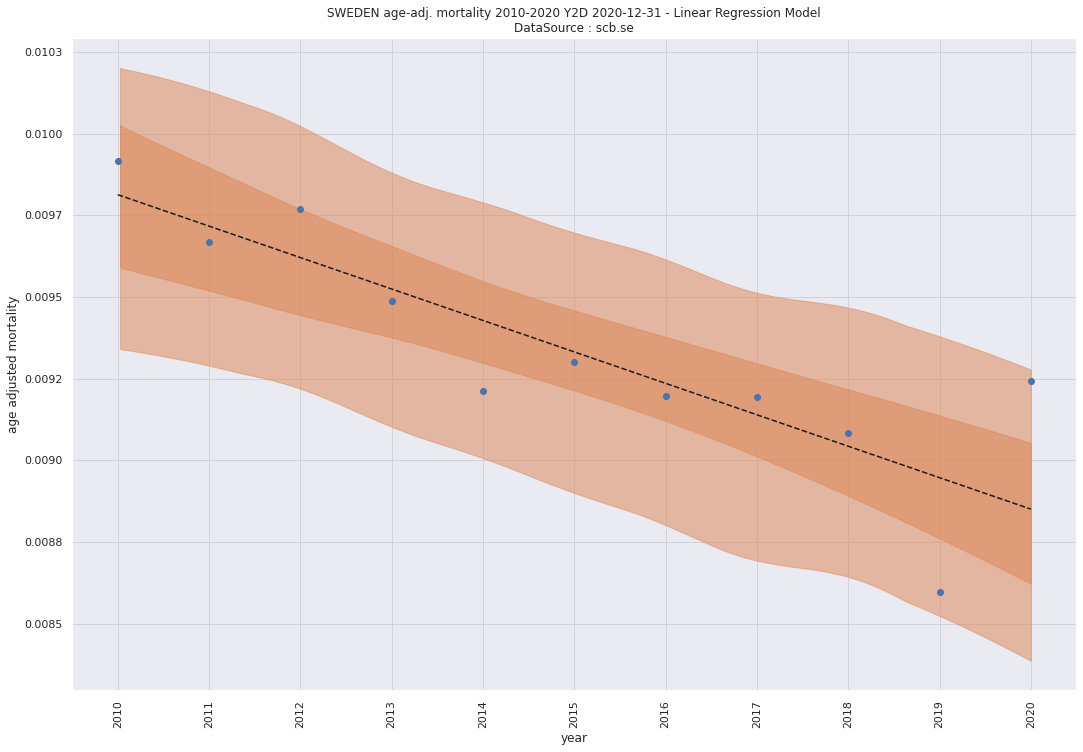

In [6398]:
fig,ax = plt.subplots(figsize=(18,12))

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:.4f}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function


with model3:
    
    title1 = 'SWEDEN age-adj. mortality {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year,last_good_date)
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title3 = '\nAccording to this model - and many others using "Excess Deaths" - SWE has had excess deaths since late 70:ies'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1+title4)
    
    ppc = pm.sample_posterior_predictive(trace3,samples=1000,model=model3)

    az.plot_hpd(x,trace3['reg'],hdi_prob=0.89,ax=ax)
    
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    ax.plot(x,trace3['alpha'].mean() + x * trace3['beta'].mean(),color='k',ls='--')
    ax.plot(x,age_adj_deaths_inc_2020['mort_x_1000'],'o')
    ax.set_xticks(range(len(age_adj_deaths_inc_2020)))
    ax.set_xticklabels(range(linreg_start_year,2021),rotation=90)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ''' 
    
    ax.yaxis.set_major_formatter(yfmt)
    
    plt.ylabel('age adjusted mortality')
    plt.xlabel('year')
    
    plt.savefig('swe_age_adj_mortality_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')
        

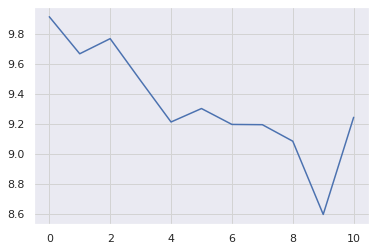

In [6399]:
plt.plot(range(len(age_adj_deaths_inc_2020)),age_adj_deaths_inc_2020['mort_x_1000'])